Python 2. Don't run this code  
### Содержание
    1.1. Доверительные интервалы   
    1.2. Проверка гипотез  
    2.1. Параметрические критерии  
    2.2. Непараметрические критерии  
    3. Закономерности и зависимости  
# Week 1 - Доверительные интервалы
# 2.4. ДИ для оценки среднего (stat.mean_conf_int)
Часто недостаточно просто построить точечную оценку среднего по выборке, — выборочное среднее, — а хочется понять, в каких диапазонах это среднее может изменяться. Для этого используют доверительные интервалы для оценки среднего. Сгенерируем некоторый набор данных, будем решать задачу бинарной классификации. При этом на этом наборе данных обучим две линейные модели и будем сравнивать их качество. Причем качество будем сравнивать не в точке, а сравнивать его интервально с помощью интервальной оценки на среднее по некоторой метрике. 

In [1]:
# from sklearn.model_selection import cross_validate, datasets, linear_model, metrics
from sklearn import model_selection
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
import numpy as np
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Генерация данных
Для начала получим такой набор данных - функция make_blobs (из datasets библиотеки sklearn). Сгенерируем два облака из 300 точек, они будут несколько накладываться друг на друга. 

In [2]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

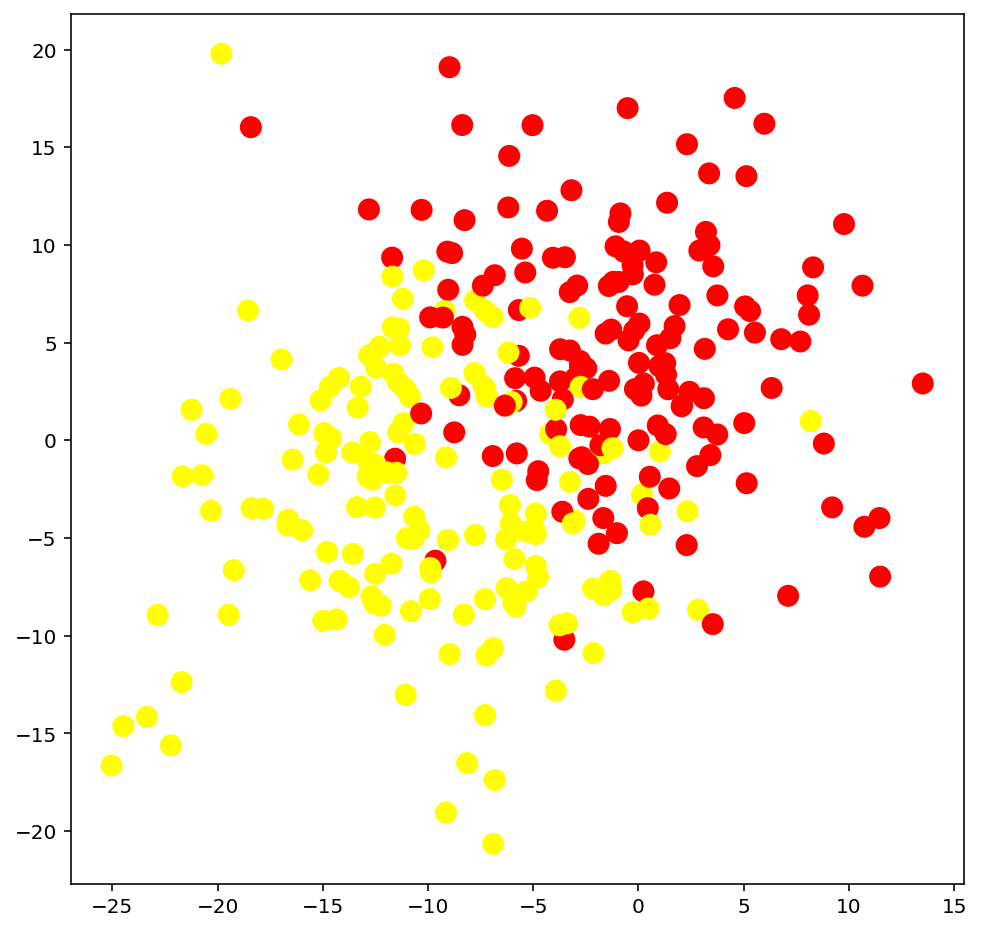

In [3]:
# Отрисуем
pylab.figure(figsize(8, 8))
x = list(map(lambda x: x[0], blobs[0]))
y = list(map(lambda x: x[1], blobs[0]))
pylab.scatter(x, y, c = blobs[1], cmap = 'autumn', s=100)

## Сравнение линейных моделей
### Точечная оценка
Разбиваем данные на обучение и тест. На обучении строим наши модели, далее на тесте их оцениваем и сравниваем их качество. Разбивать данные будем с помощью  train_test_split из модуля cross_validate (sklearn)

In [4]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(blobs[0], blobs[1], 
                                                                                    test_size = 15,
                                                                                    random_state = 1)

Теперь строим две модели. 
Первая модель (RidgeClassifier, Ridge-классификатор). Создаем модель, далее обучаем ее с помощью meta_fit на обучающей части данных, train_data и train_labels, соответственно, признаки и метки классов. 
И далее, оцениваем качество с помощью метрики roc_auc, в реализации модуля metrics.roc_auc_score 

In [5]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))
# Видим, что получили качество 0,89. 

0.8888888888888888

Теперь вторая модель (SGDClassifier, классификатор на основе стохастического градиентного спуска). Точно так же создаем классификатор. Делаем это снова с параметрами по умолчанию. Конечно, это не самый лучший способ обучения модели, но в данном случае нам он подходит. Далее, с помощью метода fit обучаем модель и сразу же снова оцениваем метрику roc_auc. 

In [6]:
sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))
# 0.8888888888888888

0.7777777777777778

Качество получается такое же. Можно предположить, что модель работает абсолютно одинаково и можно выбрать любую. 


### Оценка среднего
Попробуем уточнить оценку. В данном случаем мы оценили наши модели только по одному разбиению, а на самом деле можно оценить их по нескольким разбиениям. Из предыдущих курсов известна кросс-валидация, когда мы разбиваем наши доступные данные сразу же на несколько пар обучение–тест и оцениваем качество на каждой такой паре. 
Сделаем это для нашей задачи - используем cross_val_score. Она разбивает наши данные на обучение и тест в соответствии с той стратегией, которую мы с вами выберем, и далее возвращает нам список оценок качества нашей модели на тестовых подвыборках. Вот давайте в данном случае сделаем следующее. 
Будем разбивать наши данные по стратегии key fold на 20 фолдов, и оценим качество в каждом из них. Оценивать качество будем с помощью метрики roc_auc. 

In [7]:
# Для начала сделаем это для SGD-классификатора
sgd_auc_scores = model_selection.cross_val_score(linear_model.SGDClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [8]:
# и теперь для Ridge-классификатора. 
ridge_auc_scores = model_selection.cross_val_score(linear_model.RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

Итак, в результате мы с вами получили два массива, два списка оценок на тестах. 
 


### Точечная оценка среднего
Выведем среднее и отклонение метрики roc_auc для каждой из моделей (mean.std) и сравним полученные результаты    
  
Как считается стандартное отклонение (НЕПОНЯТНОО!)
ddof - дельта степени свободы. Обычно, принято (и по умолчанию установлено) считать ddof = 0, но в разных источниках (например ГОСТ) требуется что бы параметр ddof имел значение отличное от 0, например 1 или 1,5. Мы указываем 1 так как одну единицу мы уже истратили когда оценивали среднее выборочное

In [9]:
print ("sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print ("ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))
# sgd model auc: mean 0.923, std 0.068
# ridge model auc: mean 0.948, std 0.054

sgd model auc: mean 0.923, std 0.071
ridge model auc: mean 0.937, std 0.071


Видим, что теперь уже наши оценки неодинаковы, модели работают по-разному. Кажется в среднем модель Ridge-классификатор работает лучше и отклонение тоже меньше. Исходя из этого можно предположить, что выбрать стоило бы эту модель. 

Тут мы получили точечную оценку среднего. Теперь посмотрим, в каких диапазонах это среднее может изменяться.
### Интервальная оценка среднего 

In [10]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

Рассмотрим два метода для построения доверительных интервалов для среднего (реализация находится в библиотеке statsmodels). И далее нам обязательно понадобится выборочное среднее (метод mean()), поэтому давайте сразу же его рассчитаем и запишем соответствующие переменные.

In [11]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал (zconfint_generic)

Итак, для начала z-интервал. Чтобы этот интервал построить,  нужно откуда-то взять оценку дисперсии. Соответственно, для того чтобы строить z-интервал мы либо дисперсию должны знать, либо, раз мы ее не знаем, сделать некоторые предположения. Вот в данном случае предположим, что дисперсия равняется 0,25. Это предположение очень плохое, потому что оно фактически ни на чем не основано. 

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

Теперь строим этот интервал (метод zconfint _generic). Для начала передаем в него наше выборочное среднее, мы его рассчитали шагом ранее. Также указываем отклонение. Говорим, что мы используем уровень значимости 0,05 и двустороннюю альтернативу. 

In [12]:
print ("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print ("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))
# sgd model mean auc 95%% confidence interval (0.7037647730191199, 1.1420260433074105)
# ridge model mean auc 95%% confidence interval (0.728860436284426, 1.1671217065727166)

sgd model mean auc 95%% confidence interval (0.7040836505701402, 1.1423449208584309)
ridge model mean auc 95%% confidence interval (0.7174765077129974, 1.155737778001288)


интервалы получились достаточно широкими. Причем видно, что для второй модели Ridge-классификатор наш интервал находится весь несколько правее, поэтому, казалось бы, можно сделать предположение, что эта модель чуть лучше. Здесь мы использовали дисперсию, которую мы фактически не знаем, поэтому доверие к этой оценке не очень большое. Построим интервалы таким образом, чтобы не использовать никаких рандомных предположений.   
Вместо гипотетической и теоретической дисперсии, которую мы на самом деле не знаем и взяли непонятно откуда, давайте для построения доверительного интервала использовать выборочную оценку дисперсии. Здесь уже сигма квадрат не участвует, но зато участвует выборочная дисперсия. 

#### t-интервал (tconfint_generic)

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [13]:
type(sgd_auc_scores)

numpy.ndarray

In [14]:
# Для начала нужно рассчитать дисперсию. 
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

Теперь воспользуемся tconfint_generic для построения доверительного интервала. Передаем туда выборочное среднее и дисперсию. Нужно указать количество степеней свободы, которые у нас есть, так как мы уже использовали одну степень свободы для того, чтобы рассчитать выборочную дисперсию, вот давайте оценим количество степеней свободы как размер выборки минус 1. И остальные параметры остаются без изменения. Уровень значимости и тип альтернативы. 


In [15]:
print ("sgd model mean auc 95%% confidence interval", \
_tconfint_generic(sgd_mean, sgd_mean_std, len(sgd_auc_scores) - 1, 0.05, 'two-sided'))

print ("ridge model mean auc 95%% confidence interval", \
_tconfint_generic(ridge_mean, ridge_mean_std, len(sgd_auc_scores) - 1, 0.05, 'two-sided'))
# sgd model mean auc 95%% confidence interval (0.8909679433637532, 0.9548228729627772)
# ridge model mean auc 95%% confidence interval (0.9228783259302369, 0.9731038169269057)

sgd model mean auc 95%% confidence interval (0.8898838014034128, 0.9565447700251583)
ridge model mean auc 95%% confidence interval (0.903235324375978, 0.9699789613383075)


В данном случае наши интервалы сильно уже, то есть наша оценка получилась более точной. И из этой оценки снова следует, что модель RidgeClassifier немного лучше. 

# 2.5. ДИ для доли (stat.proporion_conf_int)
Работать будем с генеральной совокупностью, состоящей из бинарных событий (каждое из которых можно связать с 0 или с 1, или с успехом и неудачей). В жизни много примеров таких: проигрыш или выигрыш в лотерею, покупка или не покупка товара, клик или не клик на рекомендацию. 
Предположим, что мы работаем с некоторой рекламной сетью и у нас есть возможность откручивать баннер на нескольких рекламных площадках. В этом случае нам хочется измерять качество открутки наших баннеров и понимать — достаточно ли прекрасен каждый из тех баннеров, которые мы показываем, то есть, нравятся они пользователям или нет? Для того чтобы это понять, мы можем померить, как часто пользователи кликают на эти баннеры, а как часто они их просто игнорируют. Такой показатель называется click through rate, или «доля кликов по баннеру». В нашем случае это как раз и есть доля успехов в нашей генеральной совокупности. Чтобы оценить эту долю точно нам нужно дождаться конца открутки нашего баннера, далее, собрать все данные, данные с каждой из площадок, на которых мы его откручивали, и честно эту метрику посчитать. Понятно, что это занимает существенное время и часто нам хочется делать вывод о качестве баннера сильно раньше, чем заканчивается открутка. Например, это может помочь нам прекратить показывать неудачные баннеры. Таким образом, мы приходим к задаче оценки доли успехов по выборке.
Давайте для начала сгенерируем такие данные. 
Импортируем необходимые библиотеки.

## Генерация данных

В рамках предложенной задачи мы работаем с конечной генеральной совокупностью. Вот давайте такую сгенерируем, делать это будем с помощью random из библиотеки NumPy и будем использовать функцию randint. Нас интересует два значения: 0 и 1, и выборка размера 100 000. 
Сгенерируем случайную подвыборку из генеральной совокупности, сделаем это с помощью random.choice. Сгенерируем подвыборку размером 1000 и по ней будем оценивать долю успехов. 

In [16]:
np.random.seed(1)

statistical_population = np.random.randint(2, size = 100000) 

random_sample = np.random.choice(statistical_population, size = 1000)

In [17]:
# Теперь посмотрим истинное значение доли, 
# оценив среднее по генеральной совокупности. 
statistical_population.mean()

0.49771

Истинное значение = 0,498. 

## Точечная оценка доли
Теперь попробуем получить оценку истинного значения доли по нашей выборке. Из предыдущих уроков вы знаете, что самая лучшая оценка среднего – это выборочная средняя (несмещенная, асимптотически нормальная, эффективная). Это делается с помощью метода mean. 

In [18]:
random_sample.mean()
# мы получили 0,502 и это хорошее продвижение. 

0.502

## Доверительный интервал для доли
Однако часто такой оценки недостаточно. Например, когда мы хотим знать, в каких диапазонах меняется настоящая доля, то есть какое минимальное и максимальное значение на нашу оценку среднего. Чтобы такую оценку получить, нужно построить доверительный интервал на среднее (библиотека Statsmodels)

In [19]:
from statsmodels.stats.proportion import proportion_confint

### Доверительный интервал на основе нормального распределения
Чаще всего доверительные интервалы строятся на основе нормального распределения с использованием центральной предельной теоремы:

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

Давайте и мы начнем с этого. Для того чтобы такие интервалы получить, мы будем использовать функцию proportion confint.  Первый аргумент — количество успехов в нашей подвыборке. Второй аргумент — количество событий, то есть размер нашей подвыборки. И метод, с помощью которого мы хотим это оценивать - нормальное распределение (normal). Cтроим интервал.

In [20]:
normal_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'normal')

Теперь отобразим заданные границы. Помимо самих границ интервала нас также будет интересовать его ширина (чем уже получился наш интервал, тем более точную оценку диапазона мы получили)

In [21]:
print ('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1], 
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.471010, 0.532990] with width 0.061979


Интервал получился неплохой. Наше настоящее среднее 0,498, оно в этот интервал попадает. Ширина интервала 0,06 — довольно узкий интервал.

### Доверительный интервал Уилсона
А теперь попробуем эту оценку улучшить. 
Следующий метод - это доверительный интервал Уилсона. Это некоторое улучшение предыдущего метода, которое позволяет получать качественные оценки в крайних случаях. То есть тогда, когда наша доля очень близка к 0 или очень близка к 1. Более того, этот интервал получается неплохим в случае, когда наша случайная подвыборка довольно мала, то есть включает в себя очень мало событий. Формула:

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

Это делается с помощью той же самой функции и первые два параметра не меняются. Однако нужно изменить метод, с помощью которого мы будем строить интервал. В данном случае мы будем пользоваться методом Уилсона (wilson)

In [22]:
wilson_interval = proportion_confint(sum(random_sample), len(random_sample), method = 'wilson')

Полученный интервал сравним с предыдущим. 

In [23]:
print ('wilson_interval [%f, %f] with width %f' \
% (wilson_interval[0], wilson_interval[1],wilson_interval[1] - wilson_interval[0]))

wilson_interval [0.471062, 0.532922] with width 0.061860


Границы практически не изменились, изменения только в пятом знаке после запятой, ну и с данной точностью мы даже не можем увидеть разницу в ширине интервала, то есть фактически они одинаковые. Ну почему так получается? Здесь мы не видим явных преимуществ, потому что наша случайная подвыборка довольно хороша. Значение доли не является крайним. Объектов целых событий, вернее целых 1000. Поэтому мы и так можем довольно не плохо это оценить.   

## Размер выборки для интервала заданной ширины
Посмотрим еще раз на ширину интервала. В данном случае интервал имеет ширину 0,6. Часто мы можем хотеть задать некоторое ограничение на ширину интервала. Например, мы хотим знать более точную оценку и получить интервал меньшей ширины. Т.о. возникает вопрос: сколько событий нужно знать для того, чтобы оценить долю с достаточной точностью? Для того чтобы этот вопрос решить, существует метод под названием sample size confint proportion. Он позволяет задать ограничение на ширину интервала и получить количество событий, которое необходимо для того, чтобы получить оценку заданной ширины. 
Сначала импортируем нужную функциональность.

In [24]:
from statsmodels.stats.proportion import samplesize_confint_proportion

Для разнообразия получим интервал в 3 раза у́же, то есть интервал ширины 0,02. Для этого сначала указываем среднее выборочное по нашей выборке и теперь укажем ширину интервала. На самом деле нам нужно указать половину ширины этого интервала для того, чтобы в дальнейшем получить интервал заданной ширины. Вот давайте получим количество объектов n samples

In [25]:
n_samples = int(np.ceil(samplesize_confint_proportion(random_sample.mean(), 0.01)))
n_samples

9604

Оказывается, чтобы получить оценку заданной точности, то есть в 3 раза, чтобы получить ширину в 3 раза у́же, нужно взять почти в 10 раз больше событий. 
Сделаем это, перегенерируем случайную выборку, снова будем использовать метод random choice, однако теперь скажем, что количество объектов будет равняться переменной n samples – тому количеству, которое мы рассчитали шагом выше. 

In [26]:
np.random.seed(1)
random_sample = np.random.choice(statistical_population, size = n_samples)

Перестраиваем выборку. Теперь снова получим интервал на долю с помощью метода proportion confint.

In [27]:
normal_interval = proportion_confint(sum(random_sample), 
                                     len(random_sample), 
                                     method = 'normal')

Теперь смотрим, нас интересует, получился ли у нас интервал заданной ширины. 

In [28]:
print ('normal_interval [%f, %f] with width %f' % (normal_interval[0],
                                                  normal_interval[1],
                                                  normal_interval[1] - normal_interval[0]))

normal_interval [0.481776, 0.501773] with width 0.019997


Все получилось. Интервал по-прежнему достаточно хороший. Наше истинное значение входит в заданный интервал и при этом он стал в 3 раза у́же. Мы получили оценку интервала шириной 0,002.

# 2.6. ДИ для двух долей (stat.two_proporions_conf_int_upd)
(вернее, для разности двух долей). Предположим, что есть некоторый товар или услуга, которую мы хотим рекламировать. При этом у нас уже есть рекламный баннер, который мы используем для этих целей. Предположим, что дизайнеры нарисовали новый баннер и нам хочется проверить, какой из них лучше. Прежде чем везде показыать новый баннер, сделаем простенькую веб-формочку и загрузим туда два наших баннера. Попросим некоторое количество людей, например, 1000 человек, посмотреть на них и нажать на кнопку «лайк», если баннер им понравился. Тот баннер, который окажется значимо лучше, и будем показывать.

In [29]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

## Загрузка данных
Загрузим данные и посмотрим на них 

In [30]:
data = pd.read_csv('data/banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']
data.head()

Два столбца, каждый столбец соответствует кликам или не-кликам по одному из баннеров, и соответственно, 0 означает, что человек не стал нажимать на кнопку «лайк», 1 означает - нажал. 

In [32]:
# с помощью метода describe посмотрим на статистику по кликам. 
data.describe()

,banner_a,banner_b
count,1000.000000,1000.000000
mean,0.037000,0.053000
std,0.188856,0.224146
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Количество наблюдений одинаково: и в том, и в другом случае мы показали баннер 1000 человек. По баннеру A (старый баннер) — кликов несколько меньше. Ну вот мы видим, что доля (mean) меньше.

## Интервальные оценки долей

Для начала интервально оценим баннеры. Видно, что доля кликов (или доля успехов) у нас относительно небольшая, поэтому для того, чтобы построить интервальную оценку доли, нам подойдет метод Уилсона. Из предыдущих лекции вы помните, что он хорошо работает в случае крайних значений на вероятность.

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

Итак, давайте построим доверительные интервалы (с помощью метода proportion_confint из библиотеки StatsModels)

In [33]:
conf_interval_banner_a = proportion_confint(sum(data.banner_a), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(data.banner_b), 
                                            data.shape[0],
                                            method = 'wilson')
print ('interval for banner a [%f, %f]' % conf_interval_banner_a)
print ('interval for banner b [%f, %f]' % conf_interval_banner_b)

interval for banner a [0.026961, 0.050582]
interval for banner b [0.040747, 0.068675]


Интервалы достаточно узкие, но они пересекаются. Это не очень удобно, потому что если бы один интервал лежал, например, полностью левее, чем другой, тогда нам было бы легко понять, что один баннер действительно лучше. А сейчас они пересекаются и не очень понятно, как их сравнить?

## Доверительный интервал для разности долей (независимые выборки)
Для того, чтобы их сравнить, поступим следующим образом: построим доверительный интервал на разность двух долей. Чтобы это сделать, нужно сначала построить  табличку: выпишем статистику по кликам на первый баннер и на второй, соответственно, посчитаем, сколько у нас было кликов — сколько было 1 в выборке, и сколько было не-кликов, или сколько было 0. На основе этого давайте рассчитаем статистики p1 и p2 и по формуле ниже оценим интервально разность долей:

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

Сначала мы с вами честно рассчитываем все те слагаемые, которые входят в формулу, а дальше просто по формуле выписываем левую и правую границы интервала.

In [34]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [35]:
print ("confidence interval: [%f, %f]" % proportions_confint_diff_ind(data.banner_a, data.banner_b))

confidence interval: [-0.034157, 0.002157]


Мы видим, что относительно 0 наш интервал более сильно сдвинут влево, большая часть его лежит в отрицательной плоскости, но тем не менее 0 внутри и не очень понятно, действительно ли старый баннер хуже, чем новый. 

## Доверительный интервал для разности долей (связанные выборки)
Следующая ситуация: Предположим, что мы показывали баннер одним и тем же людям, то есть одни и те же люди оценивали как баннер A, старый баннер, так и баннер B. В этом случае мы с вами можем сказать, что речь идет уже о связанных выборках, они уже не являются независимыми. В этом случае мы можем использовать другую оценку разности долей. Для того, чтобы такую оценку получить, сначала нужно выписать таблицу сопряженности. Это очень простая таблица, у которой по строкам и по столбцам написаны значения случайных величин, в данном случае это 1 и 0, и в ячейках написано количество наблюдений, соответствующих данным значениям величин.

  $X_1$ \ $X_2$ | 1| 0 | $\sum$  
  1  | e | f | e + f  
  0  | g | h | g + h  
  $\sum$ | e + g| f + h | n    
  

Для того, чтобы получить доверительный интервал, нужно по формулам рассчитать p1 и p2, дальше рассчитать их разность и подставить всё это  чтобы получить левую и правую границу. 


$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

Сначала оцениваем z, дальше оцениваем f и g и подставляем их в формулу для получения интервалов.

In [36]:
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [37]:
print ("confidence interval: [%f, %f]" % proportions_confint_diff_rel(data.banner_a, data.banner_b))

confidence interval: [-0.026689, -0.005311]


весь наш интервал лежит полностью левее нуля. Из этого можно сделать вывод, что действительно наш новый баннер лучше, чем старый, и выбрать нужно именно его.

# 2.7. ДИ на основе bootstrap (stat.bootstrap_intervals)
Часто нам нужно построить интервальную оценку для некоторой не очень удобной статистики, при распределении которой нам просто ничего не известно. Это могут быть такие статистики, как квантили, например, медиана, или некоторое сочетание известных статистик, например, отношение долей. В принципе, это может быть любая функция, которую вы можете посчитать от выборки. Как же быть в этом случае? Вообще, для того чтобы оценить интервально некоторую статистику, нам нужно знать её распределение. Возникает вопрос: как же его получить?  
Первое, что приходит в голову — это породить много случайных выборок из генеральной совокупности. Дальше на каждой из этих выборок оценить нужную нам статистику и таким образом установить эмпирическую функцию распределения. Казалось бы, неплохой способ, однако он скорее теоретический, чем практический, потому что, если мы можем неограниченно генерировать выборки из генеральной совокупности, то, получается, и посчитать саму статистику на генеральной совокупности нам не так уж и сложно. А если мы можем это сделать, нам уже не нужна никакая интервальная оценка, мы сами знаем настоящее значение нужной статистики. Получается, этот способ на практике практически не применим.  
Другой способ, который мы можем предложить, — это так называемый параметрический подход. Здесь мы должны предположить, что наша статистика имеет некоторое распределение, и далее по выборке оценить его параметры. Ну на самом деле это тоже не самый лучший способ, потому что непонятно, из каких соображений мы должны выбирать семейство распределений. Мы ничего про данные не знаем, вернее, мы ничего не знаем про распределение, поэтому ну неочевидно, как его выбрать. Единственное, что нам доступно для анализа — это некоторая выборка, и это приводит нас к идее Bootstrap. Что если мы будем сэмплировать данные из известной нам выборки с возвращениями, то есть из известной выборки получать выборки такой же длины путём сэмплирования с возвращением? В этом случае мы с вами будем сэмплировать уже не из теоретической функции распределения, а из эмпирической функции распределения, и таким образом, посчитав статистику на каждой из этих выборок, мы с вами оценим эмпирическую функцию распределения. Собственно, в этом и заключается идея Bootstrap.

## Загрузка данных
### Время ремонта телекоммуникаций

Verizon — основная региональная телекоммуникационная компания (Incumbent Local Exchange Carrier, ILEC) в западной части США. В связи с этим данная компания обязана предоставлять сервис ремонта телекоммуникационного оборудования не только для своих клиентов, но и для клиентов других локальных телекоммуникационых компаний (Competing Local Exchange Carriers, CLEC). При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, Verizon может быть оштрафована. 

Загрузим доступную выборку и проанализируем среднее время ремонта оборудования для клиентов компании Verizon и среднее время ремонта оборудования для клиентов других компаний. Для этого создадим DataFrame на основе наших данных. 

In [38]:
data = pd.read_csv('data/verizon.txt', sep='\t')
data.shape
# в DataFrame примерно 1700 записей и всего два столбца. 

(1687, 2)

In [39]:
# Вот давайте выведем начало нашего DataFrame и посмотрим, что же там. 
data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


В первом столбце указан Time - время ремонта оборудования. А во втором столбце - группа клиентов. ILEC означает, что это клиент самой компании, CLEC означает, что это клиент другой компании.

In [40]:
# Вот теперь давайте посмотрим, как много информации у нас известно
# про клиентов разных типов.
data.Group.value_counts()

ILEC    1664
CLEC      23
Name: Group, dtype: int64

Про клиентов компании Verizon гораздо больше информации. Практически все данные относятся к клиентам этой компании. Но тем не менее хочется  сравнить, насколько же отличается среднее время ремонта. Ну сравнивать среднее время ремонта не очень сложно, мы с вами это уже умеем. Мы умеем строить доверительные интервалы на средние, поэтому давайте возьмём какую-нибудь другую статистику. Сравним, как же соотносится между собой медианное время ремонта. Для начала построим распределение времени ремонта оборудования для клиентов разного типа. Это делается с помощью метода hist из pylab.

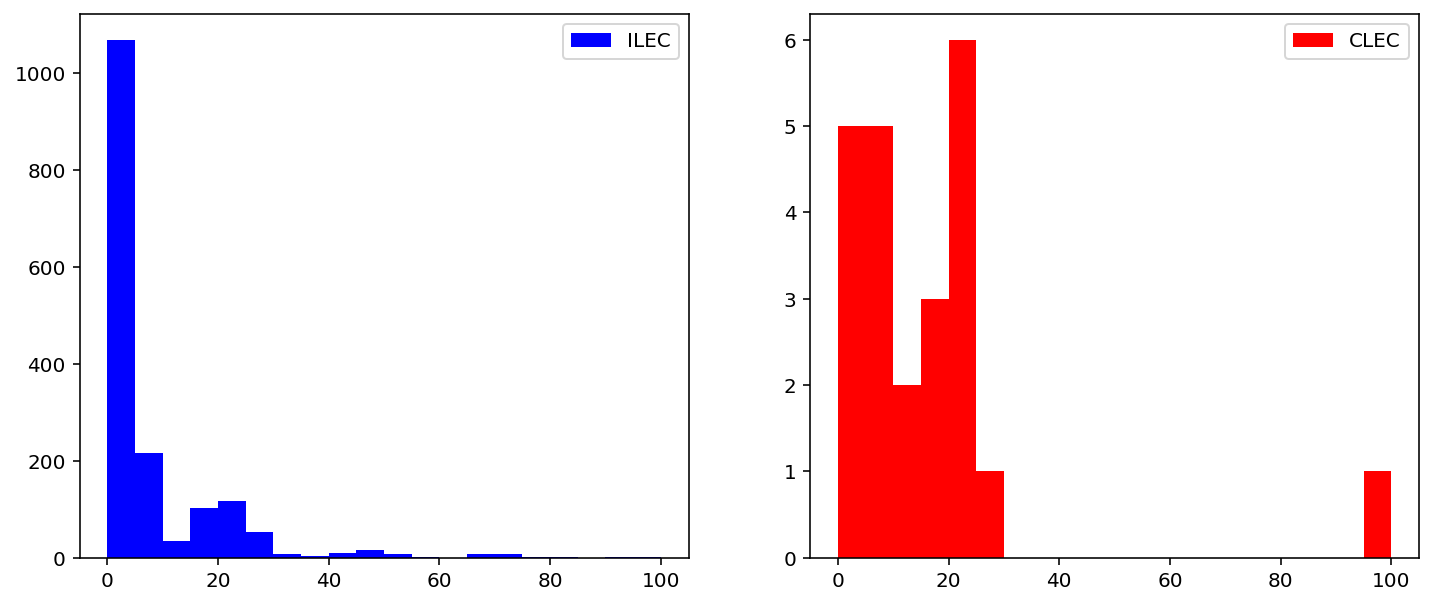

In [41]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.Group == 'ILEC'].Time, bins = 20, color = 'b', range = (0, 100), label = 'ILEC')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.Group == 'CLEC'].Time, bins = 20, color = 'r', range = (0, 100), label = 'CLEC')
pylab.legend()

pylab.show()

если посмотреть на распределение - кажется, клиенты местных компаний получают услугу лучше. Виден явный пик вблизи нуля в самой левой части диаграммы. А про клиентов остальных компаний такое не скажешь — видно, что здесь довольно много точек находится правее, ну то есть время ремонта чаще бывает дольше. Конечно, оценивать глазами такие вещи неправильно. Попробуем получить строгую формальную оценку (с помощью методологии Bootstrap)
## Bootstrap
Нам понадобятся две вспомогательные функции. 
1. get bootstrap samples. 
Эта функция будет принимать на вход данные. И количество подвыборок, количество сэмплов, которые мы хотим получить. Реализация предельно простая. Для начала давайте получим наборы индексов из range 0 размер наших данных с повторением. Это можно сделать с помощью модуля np. random функции rand Int. Указываем ей в качестве аргументов начало и конец нашего диапазона, соответственно, это ноль и размер входных данных. И теперь говорим сколько выборок нам нужно. Ну вот нам нужно выборок ровно n samples. Этот аргумент мы передаём. Ну и мы говорим, что эти выборки должны быть такого же размера, как и размер наших исходных данных. Вот получаем эти индексы, дальше получаем выборки, применяя эти индексы к исходному набору данных, и возвращаем выборки.

In [42]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

2.  stat intervals. 
Она реализована очень просто. Так как мы хотим оценивать наш интервал на некотором уровне значимости, вот просто давайте создадим функцию, которая на вход получает нужные статистики, уровень доверия, который нас интересует, и возвращает нам левую и правую границы интервала. Функция очень простая, передаём ей статистики, передаём ей α, а дальше берём наши статистики и упорядочиваем их по возрастанию, и говорим, что мы просто отрезаем слева и справа по кусочку равному α / 2 (слева) и (1 − α) / 2 (справа). 

In [43]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return (boundaries)

### Интервальная оценка медианы
Сначала получим независимые интервальные оценки медианы для клиентов двух типов. Для этого создадим два массива. В первый массив запишем время ремонта для клиентов компании Verizon, во второй массив запишем время ремонта для клиентов других компаний. Это делается очень просто с помощью сравнения групп с нужными константами. Соответственно, записываем только время.

In [44]:
ilec_time = data[data.Group == 'ILEC'].Time.values
clec_time = data[data.Group == 'CLEC'].Time.values

Нам нужно применить функцию get bootstrap samples, то есть сгенерировать набор данных. В данном случае будем генерировать тысячу выборок для каждой группы клиентов. И сразу же посчитаем нашу статистику (медиану с помощью метода np. median), поэтому сразу создадим массивы, состоящие из оценки медианы на наших подвыборках. Это делается с помощью метода map, то есть получаем сэмплы, применяем медиану и записываем результат в массив. Делаем это дважды для клиентов разных компаний. Сразу посчитаем статистику. Выведем результаты работы функции stat intervals на экран. Рассчитываем статистику на уровне доверия 0,05

In [45]:
np.random.seed(0)

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time, 1000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time, 1000)))

print ("95% confidence interval for the ILEC median repair time:",  stat_intervals(ilec_median_scores, 0.05))
print ("95% confidence interval for the CLEC median repair time:",  stat_intervals(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [3.18    3.82525]
95% confidence interval for the CLEC median repair time: [ 5.79125 20.     ]


кажется, весь интервал для клиентов компании Verizon расположен левее интервала для клиентов внешних компаний. Кажется, интерес помогать своим клиентам всё-таки есть.

### Точечная оценка разности медиан

Мы получили независимые интервальные оценки медианы времени ремонта оборудования для клиентов из разных групп, теперь усложним. Оценим разность медиан времени ремонта оборудования для этих клиентов. Но кажется, если нам нужно получить точечную оценку, то это очень просто. Независимо оцениваем медианы времени ремонта для клиентов одной группы, потом для клиентов второй группы и просто строим разность

In [46]:
print ("difference between medians:", np.median(clec_time) - np.median(ilec_time))

difference between medians: 10.74


Ну вот видим, что дельта медиан равняется 11. 
### Интервальная оценка разности медиан
Что если нам хочется получить интервальную оценку для разности медиан? Тут уже несколько сложнее. Во-первых, эти интервалы получились сильно разной длины, ну и, вообще, у нас нет никаких теоретических оснований для того, чтобы просто взять и, скажем, посчитать разность левых и правых границ этого интервала. Кажется, что так не пройдёт, нужно действовать чуть более хитро. Давайте поступим следующим образом. Снова с помощью Bootstrap сгенерируем выборки для клиентов разных групп и посчитаем на этих выборках медианы независимо. Далее, по полученным данным рассчитаем следующую статистику. Посчитаем разность полученных медиан. Это делается довольно просто. Сначала рассчитываем медианы независимо, далее, с помощью функции zip объединяем их в один список. Ну и с помощью функции map просто считаем попарные разности

In [47]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))

Теперь снова пользуемся функцией stat intervals, которую определили ранее, и рассчитываем интервал для этой статистики на уровне доверия 0,05. 

In [48]:
print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [ 2.04975 16.63   ]


Получили довольно неплохую оценку для этого интервала - разница во времени работы составляет от 2 до 16,06 разницы в медиане. 

# Week 1 - Проверка гипотез
# 3.1. Биномиальный критерий для доли (stat.binomial_test_with_plots)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Shaken, not stirred

Джеймс Бонд утверждает, что он предпочитает пить мартини взболтанным, но не смешанным. Как проверить это на практике? Можно было бы предложить Джеймсу Бонду пройти так называемый blind test, или слепое тестирование. Можно было бы завязать ему глаза, несколько раз предложить на выбор взболтанный и смешанный мартини, а после этого спросить, какой напиток он предпочитает. В данном случае если бы Джеймс Бонд выбирал взболтанный напиток, мы бы говорили, что это успех, потому что его выбор соответствует его утверждению. В противном случае мы бы говорили, что произошла неудача, так как выбор утверждению не соответствует. Как в данном случае выглядела бы проверка гипотез? Мы бы проверяли нулевую гипотезу о том, что Джеймс Бонд не различает два вида напитков и выбирает наугад, против некоторой альтернативы. Но альтернатива, вообще говоря, могла бы быть разной. С одной стороны, мы могли бы рассматривать двустороннюю альтернативу — Джеймс Бонд отличает два вида напитков, и у него есть некоторые предпочтения, — или одну из односторонних — Джеймс Бонд предпочитает взболтанный мартини, так, как он утверждает, или Джеймс Бонд предпочитает смешанный. Такой эксперимент мы провели бы n раз и в качестве T-статистики использовали бы количество единиц выборки или сумму элементов выборки. Если наша нулевая гипотеза справедлива, то есть Джеймс Бонд выбирает напиток наугад, то мы могли бы равновероятно получить любую комбинацию из нулей и единиц. Таких комбинаций ровно 2 в степени n, поэтому для того чтобы получить нулевое распределение, мы могли бы с вами сгенерировать все эти наборы данных, на каждом посчитать значение этой статистики и таким образом получить наше распределение. На самом деле, в данном случае этот шаг мы можем пропустить. Почему? Потому что мы имеем дело с выборкой, состоящей из нулей и единиц из распределения Бернулли с вероятностью успеха p. В данном случае вероятность успеха p = 0,5, потому что если нулевая гипотеза справедлива, то успех и неудачи просходят равновероятно. Соответственно, мы с вами работаем с выборкой, которая представляет из себя сумму n независимых одинаково распределенных величин из распределения Бернулли. Соответственно, нулевое распределение статистики — это биномиальное распределение с параметрами n, количество экспериментов, и p, вероятность успеха. Соответственно, давайте возьмем n, равное 16, и вероятность успеха — 0,5. 
Вот давайте посмотрим, как распределение нулевой статистики могло бы выглядеть. Давайте для начала его построим, это можно сделать с помощью функции binom, которой мы передаем количество испытаний и вероятность успеха. 

Джеймс Бонд говорит, что предпочитает мартини взболтанным, но не смешанным. Проведём слепой тест (blind test): $n$ раз предложим ему пару напитков и выясним, какой из двух он предпочитает. Получаем: 
* **выборка:** бинарный вектор длины $n$, где 1 — Джеймс Бонд предпочел взболтанный напиток, 0 — смешанный;
* **гипотеза $H_0$:** Джеймс Бонд не различает 2 вида напитков и выбирает наугад;
* **статистика $T$:** количество единиц в выборке.

Если нулевая гипотеза справедлива и Джеймс Бонд действительно выбирает наугад, то мы можем с одинаковой вероятностью получить любой из $2^n$ бинарных векторов длины $n$. 

Мы могли бы перебрать все такие векторы, посчитать на каждом значение статистики $T$ и получить таким образом её нулевое распределение. Но в данном случае этот этап можно пропустить: мы имеем дело с выборкой, состоящей из 0 и 1, то есть, из распределения Бернулли $Ber(p)$. Нулевая гипотеза выбора наугад соответствует значению $p=\frac1{2}$, то есть, в каждом эксперименте вероятность выбора взболтанного мартини равна $\frac1{2}$. Сумма $n$ одинаково распределённых бернуллиевских случайных величин с параметром $p$ имеет биномиальное распределение $Bin(n, p)$. Следовательно, нулевое распределение статистики $T$ — $Bin\left(n, \frac1{2}\right)$.

Пусть $n=16.$

In [2]:
n = 16
F_H0 = stats.binom(n, 0.5)

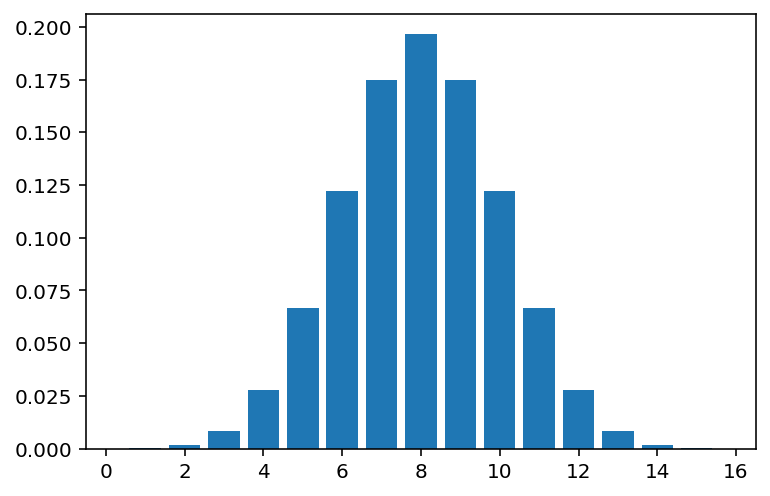

In [3]:
# И дальше давайте просто посмотрим распределение.
x = np.linspace(0,16,17)

pylab.bar(x, F_H0.pmf(x), align = 'center')
xlim(-0.5, 16.5) 
pylab.show()

Получили ожидаемое распределение с пиком в центре. Так как у нас 16 испытаний, вероятность успеха — 0,5, то пик должен приходиться на 8. 
## Односторонняя альтернатива
Теперь перейдем непосредственно к проверке гипотез. Так как Джеймс Бонд утверждает, что он предпочитает взболтанный мартини, то давайте с этого и начнем и будем тестировать гипотезу H0 против односторонней альтернативы. Соответственно, гипотеза H1: Джеймс Бонд предпочитает взболтанный мартини. При такой альтернативе более вероятно попасть в правый конец распределения, то есть более вероятно в нашей выборке получить много единиц. А вот давайте предположим, что мы действительно провели 16 испытаний и при этом в 12 из 16 испытаний Джеймс Бонд выбрал взболтанный мартини, то есть произошел успех. Давайте построим соответствующее нулевое распределение, 

**гипотеза $H_1$:** Джеймс Бонд предпочитает взболтанный мартини.

При такой альтернативе более вероятны большие значения статистики; при расчёте достигаемого уровня значимости будем суммировать высоту столбиков в правом хвосте распределения.

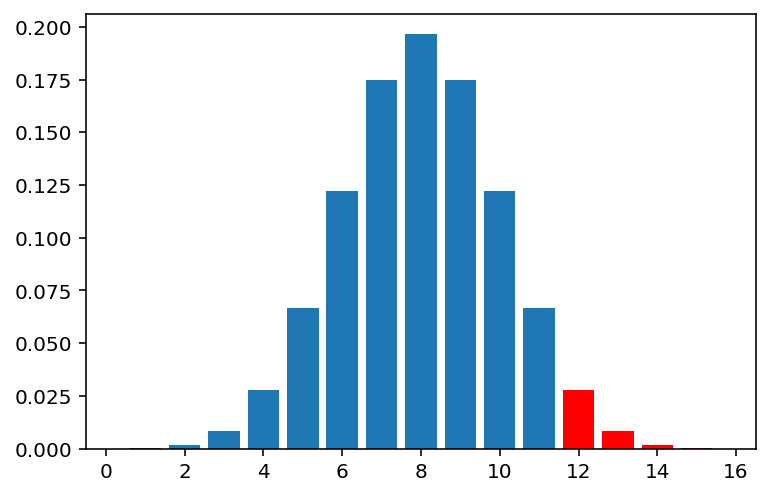

In [4]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(12,16,5), F_H0.pmf(np.linspace(12,16,5)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

и видим, что в данном случае наша T-статистика была бы равна 12 и нас бы интересовал правый «хвост» из нашего распределения. В данном случае нам нужно просуммировать высоту столбцов, начиная со столбца, соответствующего 12, и правее, то есть правый «хвост» нашего распределения, и использовать полученное значение при расчете достигаемого уровня значимости. Итак, давайте это сделаем. В данном случае передаем в метод binom_test из модуля stats следующие параметры: первый параметр — это 12, количество успехов, соответственно, следующий параметр — 16, количество испытаний, величина 0,5 — это величина p. И соответственно, вид альтернативы, в данном случае односторонняя альтернатива greater. 

In [5]:
stats.binom_test(12, 16, 0.5, alternative = 'greater')

0.0384063720703125

Посмотрим на значение p-value, оно достаточно маленькое — 0,04 => на уровне значимости 0,05 мы можем отвергать нулевую гипотезу. То есть если 12 раз из 16 у нас произойдет успех, то мы с вами можем сделать вывод о том, что Джеймс Бонд предпочитает взболтанный мартини. 

Так, давайте посмотрим, что было бы, если бы успехов было 11. Могли бы мы в этом случае прийти к такому же выводу? Построим такую гистограмму

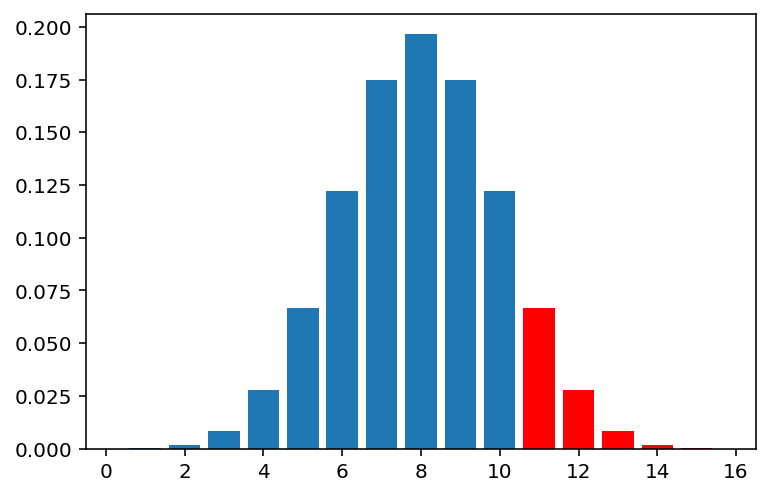

In [6]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(11,16,6), F_H0.pmf(np.linspace(11,16,6)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

Добавился еще один столбец по сравнению с предыдущим рисунком.  
Рассчитаем значение p-value. 

In [7]:
stats.binom_test(11, 16, 0.5, alternative = 'greater')

0.10505676269531246

p-value стало больше — теперь это 0,1, то есть на уровне значимости 0,05 мы уже не можем отвергнуть нулевую альтернативу.

## Двусторонняя альтернатива
Теперь давайте перейдем к двусторонней альтернативе. В данном случае гипотеза H1 переформулируется следующим образом: Джеймс Бонд предпочитает какой-то один определенный вид мартини, при этом мы не выбираем, какой именно. При такой альтернативе будут очень вероятны либо большие значения этой статистики, либо очень маленькие. При расчете достигаемого уровня значимости мы с вами будем учитывать как правый, так и левый конец нашего распределения. Соответственно, мы будем суммировать высоту правых и левых столбцов. Вот давайте для начала предположим снова, что у нас произошло 12 успехов, то есть 12 раз Джеймс Бонд выбрал взболтанный мартини, и посмотрим, какие столбцы мы с вами будем суммировать. 

**гипотеза $H_1$:** Джеймс Бонд предпочитает какой-то определённый вид мартини.

При такой альтернативе более вероятны очень большие и очень маленькие значения статистики; при расчёте достигаемого уровня значимости будем суммировать высоту столбиков в правом и левом хвостах распределения.

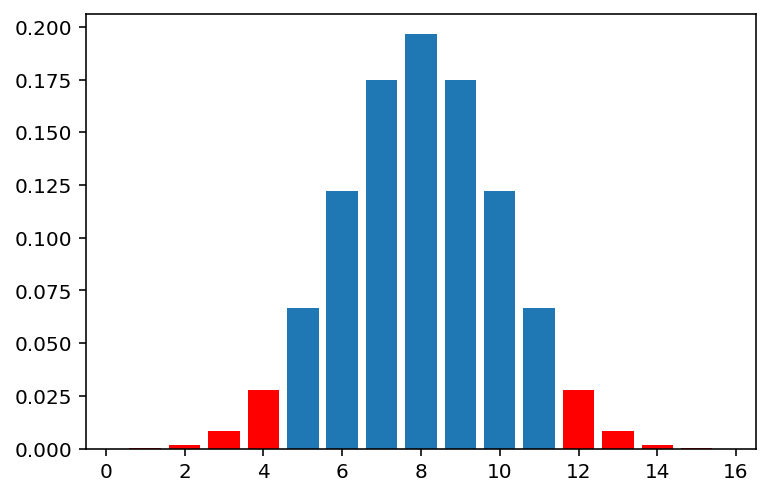

In [8]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(12,16,5), F_H0.pmf(np.linspace(12,16,5)), align = 'center', color='red')
pylab.bar(np.linspace(0,4,5), F_H0.pmf(np.linspace(0,4,5)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

Видим, что мы снова суммируем тот же самый правый конец, но теперь к нему добавляется и левый конец. Теперь рассчитаем значение p-value (с помощью той же самой функции, но  поменяем вид альтернативы — она двусторонняя). И смотрим на значение p-value.

In [9]:
stats.binom_test(12, 16, 0.5, alternative = 'two-sided')

0.076812744140625

Видим, что значение p-value — почти 0,08, т.е. больше, чем было в том случае, когда мы проверяли гипотезу H0 против односторонней альтернативы greater. Соответственно, тут мы не можем отвергнуть гипотезу на уровне значимости 0,05, однако мы можем отвергнуть нулевую гипотезу на уровне значимости 0,1.

Посмотрим, что было бы, если бы произошло 13 испытаний — может быть, их достаточно для того, чтобы отвергнуть нулевую гипотезу на уровне 0,05.

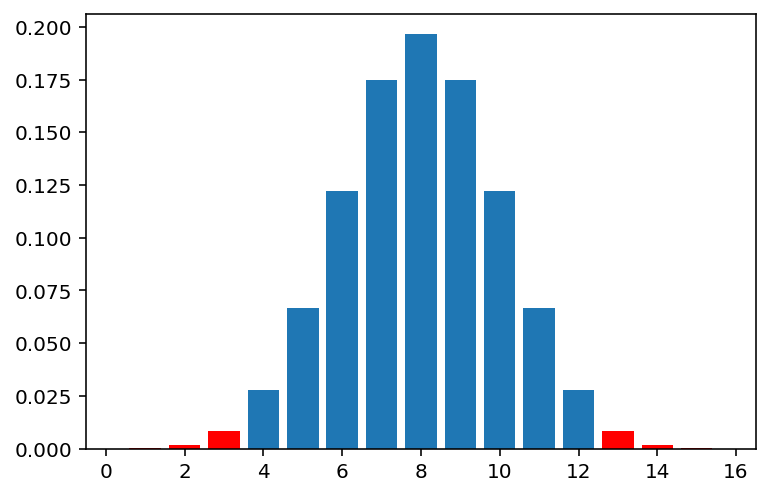

In [10]:
pylab.bar(x, F_H0.pmf(x), align = 'center')
pylab.bar(np.linspace(13,16,4), F_H0.pmf(np.linspace(13,16,4)), align = 'center', color='red')
pylab.bar(np.linspace(0,3,4), F_H0.pmf(np.linspace(0,3,4)), align = 'center', color='red')
xlim(-0.5, 16.5) 
pylab.show()

И Смотрим и видим, что мы суммируем значения, соответствующие правому левому концу, в данном случае столбцов. Красных столбцов уже меньше, то есть мы видим, что значение статистики более экстремальное. И теперь давайте посмотрим на значение p-value. 

In [11]:
stats.binom_test(13, 16, 0.5, alternative = 'two-sided')

0.021270751953125

Видим, что всего лишь 0,02. Соответственно можно отвергнуть нулевую гипотезу на уровне значимости 0,05.

# 3.2. Критерий согласия Пирсона хи-квадрат ( $\chi^2$) (stat.hi2_test) 
Потренируемся на практике применять критерии согласия Пирсона или критерий хи-квадрат. Этот критерий используется для проверки того, что некоторая наблюдаемая случайная величина подчиняется тому или иному теоретическому закону распределения. 

## Исчерпанная рождаемость
Тренироваться мы будем на примере про исчерпанную рождаемость. Этот признак связан с количеством детей, родившихся у женщины на момент окончания репродуктивного возраста. Это приблизительно 45 лет. Для 1878 женщин старше 45, участвующих в социологическом опросе жителей Швейцарии, известно количество детей. Этот признак – типичный счётчик, поэтому его можно попробовать оценить с помощью распределения Пуассона. Таким образом, работать мы будем со следующей выборкой: это будет целочисленный вектор длины n, в данном случае длины 1878, где каждые компоненты вектора характеризуют количество детей, рожденных у женщины. В данном случае гипотеза H0 – это то, что наша наблюдаемая величина имеет распределение Пуассона.   
Для начала давайте загрузим данные. Сделаем это с помощью функции open, и так как мы с вами заранее знаем, какого вида наши данные, давайте сразу отрежем от каждой строчки все нечитаемые символы и преобразуем tip в int. Делаем это с помощью простой комбинации функции map и λ. 

Исчерпанная рождаемость — количество детей, родившихся у женщины на момент окончания конвенционального репродуктивного возраста (45 лет). Для 1878 женщин старше 45, участвовавших в социологическом опросе жителей Швейцарии, известно количество детей. Этот признак — типичный счётчик, а, значит, его можно попробовать описать распределением Пуассона.

* **выборка** - целочисленный вектор длиы $n$, характеризующий количество детей у опрашиваемой женщины
* **гипотеза $H_0$** - рассматриваемая величина имеет распределение Пуассона

In [12]:
fin = open('data/fertility.txt', 'r')
data = list(map(lambda x: int(x.strip()), fin.readlines()))

In [13]:
# Вот так, готово. Давайте посмотрим на данные.
data[:20]

[0, 0, 2, 0, 2, 3, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 3, 2, 2, 4]

Это список целых чисел. Посмотрим на то, как наши данные распределены. Для того чтобы это сделать, нам нужно проссумировать сколько раз встречается каждое количество детей. Это очень легко сделать с помощью функции bincount из модуля NumPy. И построим график.

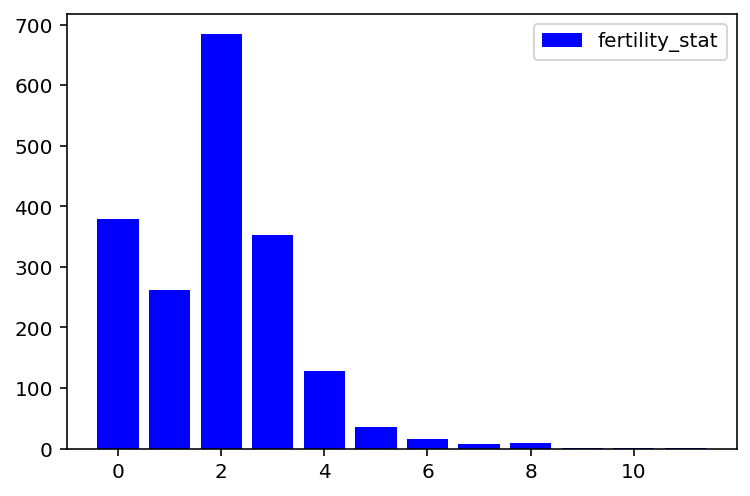

In [14]:
pylab.bar(range(12), np.bincount(data), color = 'b', label = 'fertility_stat')
pylab.legend()

Количество детей меняется от 0 до 11. Чаще всего у женщины не более четырёх детей. Наиболее часто встречающееся количество детей – это два ребёнка. Кажется, что такие данные должны хорошо описываться распределением Пуассона. Сразу оценим, какая λ должна быть в этом случае. Из предыдущих курсов помним, что лучшая оценка на параметр λ для распределения Пуассона, это просто выборочное среднее. Его посчитаем и посмотрим, сколько же это.

In [15]:
l = np.mean(data)
l

1.93716719914803

## Критерий согласия
Получается приблизительно 2. Таким образом, давайте проверять следующую гипотезу. Наша с вами наблюдаемая случайная величина имеет распределение Пуассона с λ = 2. Делать это будем с помощью критерия согласия Пирсона. Мы с вами захотим применить критерий хи-квадрат с помощью функции Chi-square из модуля stats библиотеки SciPy. Для этого нам нужно будет подготовить данные. Первое, что нас будет интересовать, это наблюдённые частоты. В данном случае мы с вами знаем, сколько раз встретилось каждое количество детей в данных, поэтому давайте это рассчитаем. Это очень просто, мы уже сегодня применяли функцию bincount. 

In [16]:
observed_frequences = np.bincount(data)
observed_frequences

array([379, 262, 684, 353, 128,  35,  16,   8,  10,   1,   1,   1])

Мы получили целочисленный вектор, где каждая компонента характеризует, сколько раз данное количество детей встретилось. То есть элемент вектора 0 говорит о том, сколько раз в нашей выборке встретилось количество детей, равное 0, в данном случае это 379, и последний 11 элемент означает, что 11 детей у нас встретилось всего лишь 1 раз. Это наблюдённые частоты. Теперь нам нужно построить ожидаемые частоты. Что это? Если бы наши данные имели ровное распределение Пуассона с параметром λ2 и размер данных был бы таким же, сколько раз мы бы встретили каждое количество детей? Вот именно эту величину нам с вами нужно рассчитать. С помощью функции pmf stats.poisson.pmf мы можем посчитать вероятность встретить некоторые значения, если данные распределены с распределением Пуассона. Эти вероятности рассчитаем, они нас будут интересовать для значений от 0 до 11, а дальше просто умножим их на размер нашей выборки. Таким образом, мы получим то распределение, которое мы бы имели, если бы данные были порождены именно распределением Пуассона с оценённым нами параметром. 

In [17]:
expected_frequences = [len(data)*stats.poisson.pmf(x, l) for x in range(min(data), max(data) + 1)]
expected_frequences

[270.6416065637888,
 524.2780429600978,
 507.80711402791167,
 327.9024282629646,
 158.80045713800124,
 61.52460735548975,
 19.863908551586047,
 5.49710172757265,
 1.3311006446292126,
 0.28650716750450117,
 0.055501228721053016,
 0.009774105435530582]

Посмотрим, какие ожидаемые частоты мы бы получили. 
Они несколько отличаются от наблюдённых частот. В общем-то, какие-то, может быть, довольно близки. Теперь посмотрим на то, как это выглядит, построим гистограмму наших наблюдённых частот, то есть то, что бы мы получили из распределения Пуассона.

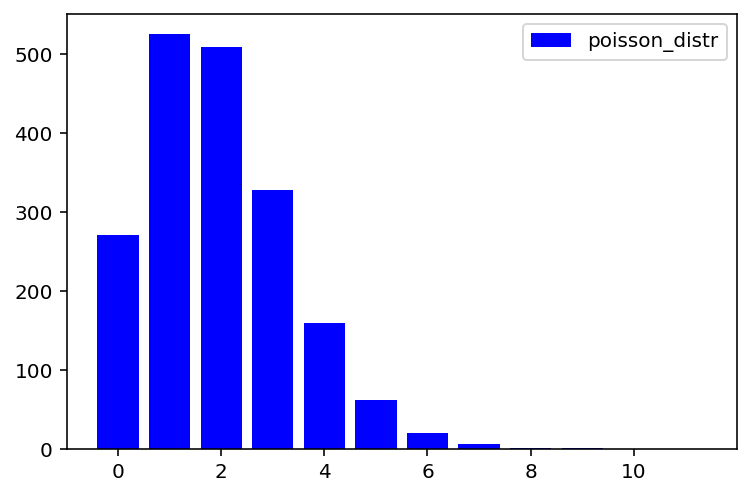

In [18]:
pylab.bar(range(len(expected_frequences)), expected_frequences, color = 'b', label = 'poisson_distr')
pylab.legend()

Этот график значительно отличается от предыдущего
Теперь это оценим строго с помощью критерия хи-квадрат. Вызываем функцию Chi-square, передаём ей наблюдённые частоты, ожидаемые частоты, и также важно указать параметры ddof, то есть difference of degrees of freedom. Это разница между степенями свободы. Дело в том, что мы с вами уже израсходовали одну степень свободы, когда оценивали параметр λ. Мы сделали это здесь, оценив его, как среднее по нашим данным, поэтому нужно сказать, что у нас теперь разница степеней свободны составляет 1, единичку мы уже потратили. 

Статистика критерия хи-квадрат: $$\chi^2=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{np_i}$$
При справедливости нулевой гипотезы имеет распределение хи-квадрат с числом степеней свободы $K-1-m$, где $m$ - число параметров распределения, оцененных по выборке.

In [19]:
stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=431.5752205284916, pvalue=1.772613180233512e-86)

Значение статистики, 431,5, а значение p-value практически 0, очень маленькое число. Это значит, что мы можем смело отвергнуть гипотезу H0. То есть это означает, что наши данные не имеют распределения Пуассона с параметром l = почти 2.

# Week 2 - 1. Параметрические критерии
# W2pynb - 1. Критерии Стьюдента

In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *

%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Treatment effects of methylphenidate

В рамках исследования эффективности препарата метилфенидат 24 пациента с синдромом дефицита внимания и гиперактивности в течение недели принимали либо метилфенидат, либо плацебо. В конце недели каждый пациент проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, и после недельного курса каждый испытуемые проходили второй тест.

Требуется оценить эффект применения препарата.

Pearson D.A, Santos C.W., Casat C.D., et al. (2004). Treatment effects of methylphenidate on cognitive functioning in children with mental retardation and ADHD. Journal of the American Academy of Child and Adolescent Psychiatry, 43(6), 677–685.

Привет! В этом видео мы потренируемся применять критерий Стьюдента на практике. Тренироваться будем на известной задаче Treatment effects of methylphenidate. Это известное исследование, в рамках которого 24 пациента с синдромом дефицита внимания и гиперактивностью в течение недели применяли препарат и плацебо. После этого пациенты проходили тест на способность к подавлению импульсивных поведенческих реакций, после чего метилфенидат и плацебо менялись местами, и пациенты вновь проходили такой же тест. В задаче требуется оценить эффективность применения препарата. Таким образом, мы имеем следующие данные. Для каждого пациента мы имеем измерения его способности к подавлению импульсивных поведенческих реакций после приема препарата и после плацебо. Вот давайте эти данные загрузим и попытаемся их визуализировать.

In [2]:
data = pd.read_csv('data/ADHD.txt', sep = ' ', header = 0)
data.columns = ['Placebo', 'Methylphenidate']

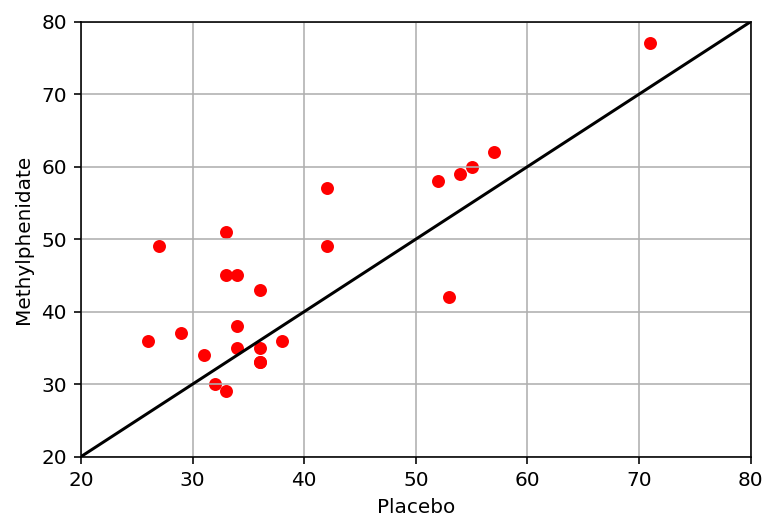

In [3]:
data.plot.scatter('Placebo', 'Methylphenidate', c = 'r', s = 30)
pylab.grid()
pylab.plot(range(100), c = 'black')
pylab.xlim((20, 80))
pylab.ylim((20, 80))
pylab.show()


По осям X и Y отметим плацебо и метилфенидат соответственно и отметим точки, соответствующие пациентам. Также проведем диагональную прямую и увидим, что практически все точки лежат выше этой прямой. Это дает нам основания предполагать, что применение препарата способно помочь пациентам, но, конечно, мы не можем это оценивать просто по графику. Нам нужен некоторый более строгий критерий для проверки таких гипотез. Вот ровно этим критерием будет выступать критерий Стьюдента. 

Для начала давайте еще немножко посмотрим на данные, а именно отобразим гистограммы распределения проверяемой способности. 

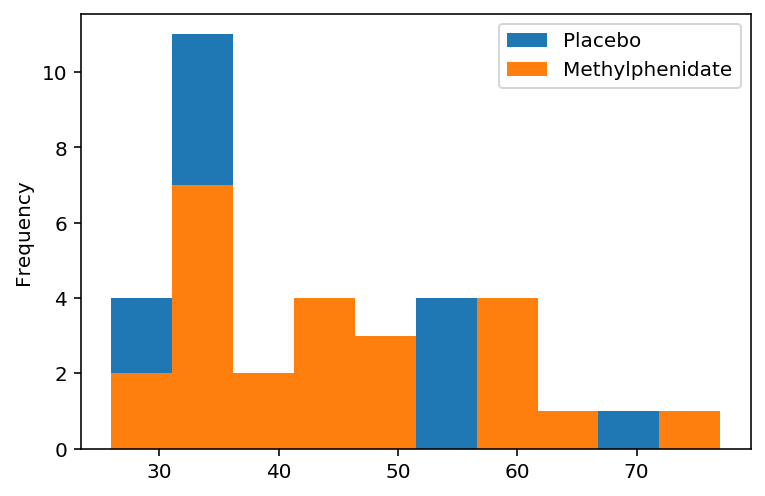

In [4]:
data.plot.hist()
pylab.show()

Видим, что гистограммы разные, их довольно сложно сравнивать, но вот можем сказать, что, например, минимальное значение способности к подавлению импульсивных реакций при приеме плацебо меньше, чем при приеме препарата, но и максимальное значение при приеме препарата больше, однако это все равно не дает нам возможности формально сказать, что препарат помогает.

## Одновыборочный критерий Стьюдента

Итак, давайте начнем с одновыборочного критерия Стьюдента. Исходя из того, что способность к подавлению импульсивных поведенческих реакций измеряется по шкале от 0 до 100, то можно предположить, что в хорошо откалиброванной сбалансированной выборке средняя способность к подавлению импульсивных поведенческих реакций составит 50. Тогда, для того чтобы проверить гипотезу о том, что наши пациенты в выборке действительно нуждаются в лечении, давайте проверим гипотезу о том, что их средняя возможность к подавлению импульсивных поведенческих реакций отличается от 50. Для этого нам понадобится одновыборочный тест Стьюдента. Гипотеза H0 будет следующая: среднее значение способности к подавлению импульсивных поведенческих реакций равна 50. Соответственно альтернатива — не равняется 50. Итак, для того чтобы воспользоваться одновыборочным тестом Стьюдента, нам понадобится библиотека scipy, воспользуемся модулем stats, функция t-test one sample, одновыборочный t-test Стьюдента. Итак, передаем туда наши данные, это data.Placebo, потому что нас интересуют пациенты до применения препарата, и передаем туда параметр 50 — это то значение, с которым мы сравниваемся. 

Исходя из того, что способность к подавлению испульсивных поведенческих реакций измеряется по шкале [0, 100], можно предположить, что при хорошей калибровке теста средняя способоность к подавлению реакций в популяции составляет 50. Тогда для того, чтобы проверить гипотезу о том, что пациенты в выборке действительно в среднем хуже справляются с подавлением импульсивных реакций (нуждаются в лечении), давайте проверим, что их способность к подавлению реакций отличается от средней (не равна 50). 

$H_0\colon$ среднее значение способности к подавлению испульсивных поведенческих реакций равно 50.

$H_1\colon$ не равно.

In [5]:
stats.ttest_1samp(data.Placebo, 50.0)

Ttest_1sampResult(statistic=-4.438003341905128, pvalue=0.00018894293251080175)

Итак, видим, что значение статистики равняется −4,4, и pvalue довольно маленькое. Это позволяет нам уверенно отвергнуть нулевую гипотезу и сказать, что среднее не равно 50. Для того чтобы на это посмотреть, давайте интервально оценим среднее по выборке. Сделаем это с помощью метода zconfint.

In [6]:
print ("95%% confidence interval: [%f, %f]" % zconfint(data.Placebo))

95% confidence interval: [35.223273, 44.276727]


Ну вот видим, что наш интервал целиком лежит левее 50, что в среднем способность измеряется от 35 до 44 пунктов. Ну это меньше 50. Итак, мы убедились, что действительно наши пациенты нуждаются в некоторой помощи.

## Двухвыборочный критерий Стьюдента (независимые выборки)
теперь давайте применим двухвыборочный критерий Стьюдента для независимых выборок, для того чтобы оценить, помогает ли исследуемый препарат. Для того чтобы использовать двухвыборочный критерий Стьюдента, сначала нужно убедиться, что распределения выборок существенно не отличаются от нормального. Для этого давайте построим Q-Q plot для каждого из распределений: для плацебо и для препарата. Итак, Q-Q plot строится достаточно просто, это делается с помощью функции probplot из модуля stats, и давайте его проанализируем. 

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.

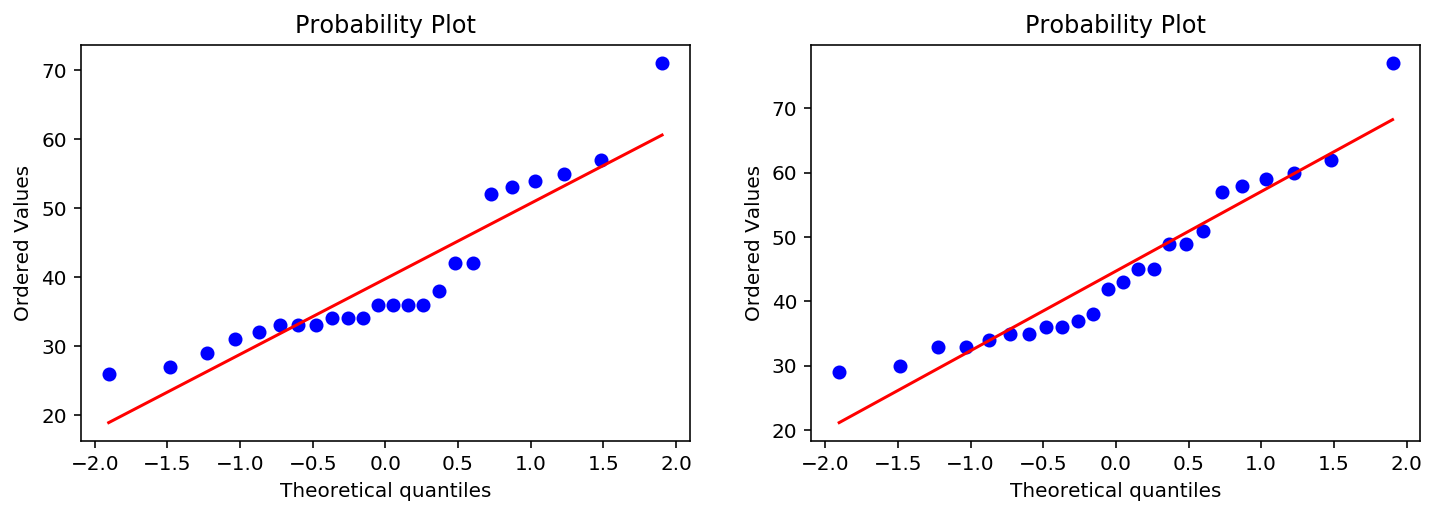

In [7]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.Placebo, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.Methylphenidate, dist="norm", plot=pylab)
pylab.show()

Итак, в общем-то, мы видим, что и в том и в другом случае наши точки не сильно отличаются от прямой, они лежат не очень далеко. Это дает нам основание предполагать, что данные распределены с некоторым распределением, которое сильно от нормального не отличается. Однако для того чтобы проверить это более строго, давайте воспользуемся критерием Шапиро-Уилка. В данном случае нулевая гипотеза будет соответствовать тому, что способность к подавлению реакций распределена нормально, соответственно, альтернатива — распределена по-другому, не нормально. Итак, сначала давайте проверим тест для плацебо.

Критерий Шапиро-Уилка:

 $H_0\colon$ способности к подавлению импульсивных реакций распредлены нормально
 
 $H_1\colon$ не нормально.

In [8]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Placebo))
# Видим, что pvalue получается 0,003

Shapiro-Wilk normality test, W-statistic: 0.857487, p-value: 0.003020


In [9]:
# теперь для Шапиро. 
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Methylphenidate))
# pvalue получается равным 0,05

Shapiro-Wilk normality test, W-statistic: 0.916445, p-value: 0.048768


Ну, в общем-то, значения получаются довольно маленькими, а значит нам придется отвергнуть гипотезу H0. Получается, что данные все-таки не распределены нормально. Однако если мы вернемся к предыдущем рисункам, мы видим, что да, действительно, распределение от нормального отличается, но не очень сильно. А мы знаем, что критерий Стьюдента работает в условиях, когда распределение не является нормальным, но существенно от него не отличается. Значит, давайте все-таки попробуем применить критерий Стьюдента. Итак, в случае применения критерия Стьюдента имеем следующую нулевую гипотезу: среднее значение способности к подавлению импульсивных поведенческих реакций после применения плацебо и после применения препарата не отличаются. Альтернативная гипотеза: средние по выборкам отличаются. Итак, для того чтобы воспользоваться готовой реализацией двухвыборочного теста Стьюдента в случае независимых выборок, нам снова понадобится библиотека scipy, модуль stats. В данном случае мы используем функцию ttest ind, от слова independent. Итак, в метод мы передаем данные, связанные с одной выборкой, с другой выборкой, а также указываем параметр equal var (equal variance) равняется false. Потому что у нас нет данных о том, что дисперсии одинаковые.

С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_0\colon$ не одинаковы.

In [10]:
scipy.stats.ttest_ind(data.Placebo, data.Methylphenidate, equal_var = False)

Ttest_indResult(statistic=-1.4521635018159091, pvalue=0.1532919977404709)

 Итак, давайте посчитаем t-test и увидим, что значение статистики равняется −1,45 и pvalue равняется 0,15, то есть pvalue достаточно большое, а значит, мы не можем отвергнуть нулевую гипотезу. Получается, что вероятнее всего, препарат все-таки помогает. Давайте интервально оценим разность средних по этим двум выборкам. Для этого воспользуемся методом CompareMeans.

In [11]:
cm = CompareMeans(DescrStatsW(data.Methylphenidate), DescrStatsW(data.Placebo))
print ("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

95% confidence interval: [-1.915927, 11.832593]


Видим, что доверительный интервал получился следующим: от −2 до 12. То есть фактически наше среднее все-таки скорее больше, чем 0, однако 0 лежит в этом интервале. Получается, что однозначно сказать все-таки довольно сложно. Итак, давайте вспомним то, что на самом деле мы с вами рассматриваем 24 пациента, каждый из которых одну неделю применял препарат, а другую неделю применял плацебо. Получается, что выборка, связанная с применением плацебо и выборка, связанная с применением препарата являются зависимыми. Таким образом, в данной задаче мы можем использовать двухвыборочный критерий Стьюдента для связанных выборок.

## Двухвыборочный критерий Стьюдента (зависимые выборки)

Для того чтобы этот критерий использовать, нам также нужно убедиться в нормальности данных. Давайте рассчитаем попарные разности и убедимся, что распределение попарных разностей существенно не отличается от нормального. Давайте снова нарисуем Q-Q plot, сделаем это с помощью метода probplot,

Для того, чтобы использовать критерй Стьюдента для связанных выборок, давайте проверим, что распределение попарных разностей существенно не отличается от нормального.

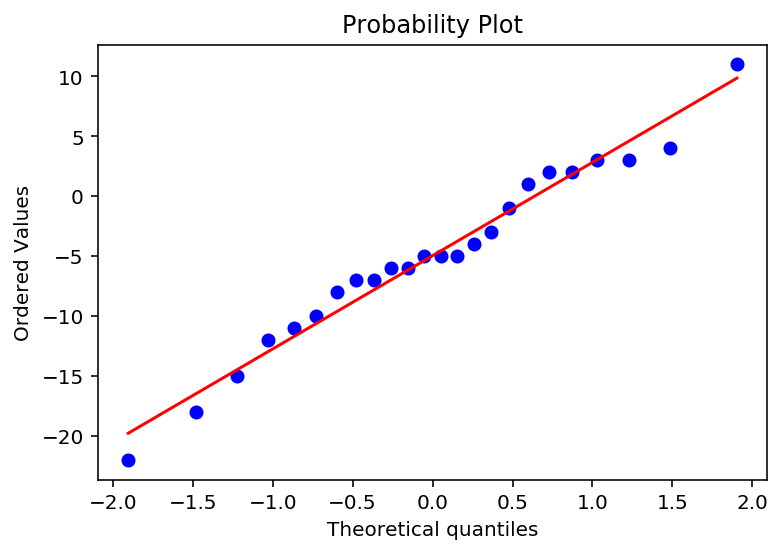

In [12]:
stats.probplot(data.Placebo - data.Methylphenidate, dist = "norm", plot = pylab)
pylab.show()

и убедимся, что наши точки находятся очень близко к прямой, значит распределение, скорее всего, похоже на нормальное. Снова применим критерий Шапиро-Уилка, в данном случае нулевая гипотеза — попарные разности распределены нормально, альтернатива — это не так. Итак, применяем критерий с помощью метода stats.shapiro, передаем туда разности и смотрим на значения.

Критерий Шапиро-Уилка:

$H_0\colon$ попарные разности распределены нормально.

$H_1\colon$ не нормально.

In [13]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Methylphenidate - data.Placebo))

Shapiro-Wilk normality test, W-statistic: 0.979806, p-value: 0.892254


Видим, что pvalue получилось большое, 0,89, а значит, нулевую гипотезу отвергать нельзя, данные распределены нормально. Отлично, можно смело применять критерий Стьюдента. В данном случае наша нулевая гипотеза имеет следующий вид: средние значения к подавлению импульсивных поведенческих реакций одинаковы для пациентов, применявших плацебо и применявших препарат. Соответственно, альтернатива: средние значения способности отличаются. Итак, воспользуемся реализацией из модуля stats библиотеки scipy, функция называется ttest rel, от слова relative (зависимые) и передаем внутрь функции данные, связанные с применением плацебо и с применением препарата. 

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_1\colon$ не одинаковы.

In [14]:
stats.ttest_rel(data.Methylphenidate, data.Placebo)

Ttest_relResult(statistic=3.2223624451230406, pvalue=0.003771488176381471)

Давайте рассчитаем и увидим, что значение статистики составляет 3,2, pvalue — всего лишь 0,004. Это значит, что мы можем уверенно откинуть нулевую гипотезу, отвергнуть ее, и прийти к выводу, что все-таки способности к подавлениям импульсивных поведенческих реакций отличаются. Давайте в данном случае оценим доверительный интервал разности, однако будем помнить, что мы работаем со связанными выборками, поэтому будем использовать соответствующую функциональность, 

In [15]:
print ("95%% confidence interval: [%f, %f]" % DescrStatsW(data.Methylphenidate - data.Placebo).tconfint_mean())

95% confidence interval: [1.775236, 8.141431]


и увидим, что весь доверительный интервал находится правее нуля, а значит, что применение препарата все-таки способствует росту способности подавления импульсивных поведенческих реакций. Видим, что разность в среднем изменяется от 2 до 8.

# W2pynb - 2.  Z-критерий для двух долей 

Привет! В этом видео мы научимся считать z-критерий для двух долей. Давайте снова рассмотрим задачу про баннеры. Напомню условия. Предположим, что мы хотим рекламировать некоторую услугу или товар с помощью рекламного баннера. Для этого у нас уже есть некоторый стандартный баннер, но дизайнеры разработали для нас новый, более прекрасный баннер. Нам с вами хочется проверить, правда ли, что новый баннер действительно лучше, чем старый, и нам имеет смысл заменить старый баннер на новый. А может быть, это не так, и имеет смысл все-таки остаться со старым. Для того чтобы это понять, мы можем провести следующий эксперимент. Создаем простую веб-формочку, в которую размещаем оба этих баннера. Далее просим некоторое количество людей, например, 1000 человек, на эти баннеры посмотреть и нажать на кнопочку like, если баннер им понравился. В результате этого эксперимента мы получим следующую выборку данных: последовательность нулей и единиц для каждого баннера, где ноль будет обозначать отсутствие клика, то есть ситуацию, когда человеку баннер не понравился, а единичка — наличие клика, ситуация, когда баннер человеку понравился. Итак, давайте загрузим соответствующие данные. Делаем это с помощью библиотеки pandas. 

In [16]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

## Загрузка данных

In [17]:
data = pd.read_csv('data/banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']
data.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


Мы увидим, что у нас ожидаемо два столбца. Каждый столбец соотвествует своему баннеру, и каждый столбец состоит из нулей и единиц. Ноль, если баннер не понравился, то есть клика не было, единичка, если клик был. Соответственно, нам с вами интересно оценить долю кликов или долю единичек в каждом случае. Давайте посмотрим на некоторые простые статистики по нашим данным.

In [18]:
data.describe()

,banner_a,banner_b
count,1000.000000,1000.000000
mean,0.037000,0.053000
std,0.188856,0.224146
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


 Видим, что количество наблюдений у нас совпадает, по тысяче наблюдений, и доля кликов в первом случае меньше, чем во втором. Остальные статистики нам не очень интересны, потому что они очевидные. Минимально-максимально ноль и единица, квантили тоже сильно ни о чем в данном случае нам не скажут. Итак, самое первое и самое простое, что мы можем сделать, это построить интервальную оценку для доли. То есть посмотреть, в каком диапазоне эта доля изменяется. Вот, напоминаю формулу Уилсона для оценки, для интервальной оценки доли. В данном случае она нам подходит больше, потому что значение нашей доли довольно близко к нулю. Мы это увидели в предыдущей таблице. Вот давайте рассчитаем интервальную оценку с помощью метода proportion_confint из модуля Stats Models и выведем результаты.

## Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [19]:
conf_interval_banner_a = proportion_confint(sum(data.banner_a), data.shape[0], method = 'wilson')
conf_interval_banner_b = proportion_confint(sum(data.banner_b), data.shape[0], method = 'wilson')

In [20]:
print ('95%% confidence interval for a click probability, banner a: [%f, %f]' % conf_interval_banner_a)
print ('95%% confidence interval for a click probability, banner b [%f, %f]' % conf_interval_banner_b)

95% confidence interval for a click probability, banner a: [0.026961, 0.050582]
95% confidence interval for a click probability, banner b [0.040747, 0.068675]


 Видим, что мы получили два интервала. Они довольно узкие, но проблема в том, что они пересекаются. Давайте рассчитаем некоторые критерии, которые позволят нам проверить гипотезу о том, что доли действительно отличаются, что они не равны. Мы с вами будем рассматривать z-критерий для разности долей. Для того чтобы его посчитать для начала нам нужно рассчитать следующую матрицу. Она довольно простая. Нам нужно посчитать количество единиц и количество нулей отдельно для каждого из баннеров. Далее, используя эти баннеры, мы с вами, с одной стороны, можем рассчитать доверительный интервал для разности долей, мы уже учились это делать. Напоминаю формулу, она перед вами. А также мы можем рассчитать z-статистику. Она также считается довольно просто, можете посмотреть на формулы. И далее, зная z-статистику, мы с вами можем оценить p.value по z-критерию, для z-критерия. Вот давайте это сделаем. Сначала давайте реализуем функцию для рассчета доверительного интервала, она довольно простая. В этой функции мы с вами рассчитаем все необходимые слагаемые, а далее подставим их вот в эту формулу для того чтобы получить левую и правую границы интервала. Вот давайте это сделаем. Реализация довольно простая.

## Z-критерий для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [21]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

 И теперь нам нужно с вами реализовать функцию для подсчета z-критерия. Ну, давайте посмотрим повнимательней. Чтобы эту функцию реализовать, нам нужно знать две вещи. Во-первых, нам нужно знать значение z-статистики, формула все еще перед вами. А во-вторых, нам с вами нужно понимать, на каком уровне мы хотим этот критерий проверить и рассчитать p.value для того чтобы понять, можем мы принять нулевую гипотезу или мы должны ее отклонить. Вот, давайте для начала рассчитаем z-статистику. Это довольно просто. Нам с вами нужно знать следующие параметры: N1 и N2 они очевидным образом получаются из размеров наших выборок. Дальше рассчитываем P1 и P2, P большое, и подставляем все это в формулу, таким образом, функция для рассчета z-статистики готова. Теперь давайте реализуем функцию для подсчета p.value. Функция получается довольно простая. В качестве первого аргумента мы передаем в нее метод для рассчета z-статистики, и, действительно, статистики же можно считать разные, можно их оценивать по-разному, поэтому давайте использовать метод для рассчета z-статистики в качестве аргумента этой функции. И вторым аргументом будет вид альтернативы. Ведь мы с вами сможем рассматривать как двустороннюю альтернативу, ну, например, так: гипотеза h0 в этом случае будет то, что у нас доли одинаковые, а альтернатива — то, что доли разные, неодинаковые. А также можем рассмотреть два вида односторонних гипотез, less и greater, меньше и больше. В этом случае альтернативная гипотеза была бы, что первая доля больше, чем другая, в противоположном — первая доля меньше, чем другая. Как это посчитать? Ну, давайте сначала сделаем небольшую проверку, что корректно введен тип альтернативы, проверим, что наши альтернативы, введенные альтернативы находятся среди трех возможных, и если это не так, выкинем в исключение ValueError, в котором напишем, что нужно задать одну из трех предусмотренных альтернатив. Если мы с вами рассматриваем двустороннюю альтернативу, то сначала нам нужно посчитать, значение функции распределения стандартного нормального распределения в точке z-stat, то есть в той точке, которая соответствует значению z-статистики, рассчитанной на ??? Дальше нам нужно из единицы вычесть это значение и, воспользовавшись свойством симметричности, просто умножить это на два. В случае, если мы рассматриваем альтернативу less, нам нужно просто посчитать значение функции распределения в точке z-stat, и если мы рассматриваем альтернативу greater, мы с вами рассматриваем другой конец, соответственно, считаем единичку минус значение функции распределения в точке z-stat. Видим, что реализация довольно простая. Итак, давайте сначала выведем доверительный интервал на разность двух долей, 

In [22]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [23]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data.banner_a, data.banner_b))

95% confidence interval for a difference between proportions: [-0.034157, 0.002157]


вот он перед вами, видим, что он включает ноль, и теперь давайте проверим критерии. Сначала давайте тестировать двустороннюю альтернативу. Соответственно, гипотеза того, что доли одинаковые, против гипотезы, что доли неодинаковые.

In [25]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b)))

p-value: 0.084379



 Итак, вводим p.value, видим, что p.value равняется 0.08. Ну, понимаем, что на уровне значимости 95 мы не можем отвергнуть нулевую гипотезу, ну, по крайней мере, на уровне значимости 0,9 можем. Что, если мы с вами воспользуемся предположением, что новый баннер все-таки лучше, чем старый, ну, он же более красивый, с котиками, и проверим гипотезу против альтернативы less.

In [26]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.banner_a, data.banner_b), 'less'))

p-value: 0.042189


## Z-критерий для разности долей (связанные выборки)

 Да, видим, что в этом случае p.value уже равняется 0,04, а значит, мы можем отвергнуть гипотезу h0 о том, что доли одинаковые, на уровне значимости 95. Теперь давайте рассмотрим следующий случай. Предположим, что люди, которые оценивали 1 и 2 баннер, это одни и те же люди. То есть мы зафиксировали выборку людей и попросили каждого из них посмотреть на оба баннера и нажать на like, если какой-то из них им понравился. Для того чтобы рассчитать z-критерий для разности долей в случае связанных выборок, нам с вами нужно рассчитать таблицу сопряженности. Фиксируем значение единицы и ноль для первого и для второго баннера и дальше рассчитываем количество наблюдений, которые этим значениям соответствуют. Напомню формулу для рассчета доверительного интервала, мы с вами с ней уже знакомы. И z-статистика принимает следующий вид. Давайте это реализуем. Для начала реализуем формулу для оценки доверительного интервала. Тоже это делается довольно просто. Сначала рассчитываем все те слагаемые, которые нам нужны. Дальше аккуратненько выписываем левую и правую границы интервала.

  $X_1$ \ $X_2$ | 1| 0 | $\sum$
  ------------- | -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n  
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

$$Z-статистика: Z({X_1, X_2}) = \frac{f - g}{\sqrt{f + g - \frac{(f-g)^2}{n}}}$$

In [27]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

 И теперь давайте реализуем формулу для подсчета z-статистики. Опять же смотрим на формулу, которая перед нами, понимаем, что нам нужно знать слагаемые f, g и n рассчитываемых, и дальше выписываем выражение для z-статистики.

In [28]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

 Для того, чтобы рассчитать p.value мы можем воспользоваться функцией, которую мы уже ранее реализовали, разница будет в том, что для оценки p.value мы просто передадим в предыдущую функцию в качестве аргумента другую статистику, ту, которую мы только что реализовали. Итак, выписываем доверительный интервал.

In [29]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(data.banner_a, data.banner_b))

95% confidence interval for a difference between proportions: [-0.026689, -0.005311]


 Мы видим, что весь доверительный интервал лежит левее нуля. Это дает нам основание предполагать, что новый баннер действительно лучше, чем старый. Ну, теперь давайте это проверим с помощью z-критерия. Итак, сначала будем использовать двустороннюю альтернативу, проверим гипотезу h0, что у нас доли одинаковые для двух баннеров против гипотезы, что доли неодинаковые. 

In [30]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(data.banner_a, data.banner_b)))

p-value: 0.003349


Итак, проверяем наш z-test, видим, что p.value получается довольно маленьким, всего 0,003. Получается, что уже на уровне значимости 99 мы можем опровергнуть гипотезу h0, но так как мы с вами изначально предполагаем, что новый баннер лучше, чем старый, давайте также выпишем p.value для односторонней альтернативы less. 

In [31]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(data.banner_a, data.banner_b), 'less'))

p-value: 0.001675


Итак, видим, что p.value стал еще меньше, значит мы еще уверенней можем отвергнуть нулевую гипотезу. 

# Week 2 - 2. Непараметрические критерии
# 2b. Непараметрические критерии (stat.two_proportions_diff_teststat.non_parametric_tests_1sample)

В этом видео мы потренируемся применять непараметрические критерии. Их так же, как параметрические критерии, можно применять для одной, двух и двух связанных выборок. В этом видео мы поговорим про одновыборочную задачу и потренируемся применять следующие критерии: знаковые, ранговые и перестановочные. Решать будем такую задачу. В рамках исследования по улучшению жизни лабораторных мышей было проведено следующее исследование. Несколько мышей посадили в клетку, состоящую из двух комнат, в одной из которых висело зеркало. Измерялась доля времени, которую каждая из мышей проведет в комнате с зеркалом. Ну хотелось понять, есть ли у мышей какие-то предпочтения насчет зеркала и если они есть, то можно было бы повесить зеркала в клетке и тем самым улучшить условия мышей. Вот давайте эти данные загрузим и проанализируем.

## Mirrors as potential environmental enrichment for individually housed laboratory mice

(Sherwin, 2004): 16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [2]:
mouses_data = pd.read_csv('data/mirror_mouses.txt', header = None)
mouses_data.columns = ['proportion_of_time']
mouses_data.head(3)

,proportion_of_time
0,0.348471
1,0.640620
2,0.549818


 Видим, что данные представляют из себя вектор, каждое значение в котором соответствует доле времени, которое мышь провела в комнате с зеркалом. Давайте соберем простенькую статистику по этим данным.

In [3]:
mouses_data.describe()

,proportion_of_time
count,16.000000
mean,0.475289
std,0.066065
min,0.348471
25%,0.444566
50%,0.477289
75%,0.488859
max,0.640620


 Видим, что у нас всего есть данные про 16 мышей, при этом в среднем мыши проводят 0,48 доли времени в комнате с зеркалом. При этом, эта доля меняется от 0,64 до 0,35, ну то есть в общем-то мы видим, что в среднем примерно половину времени, в районе половины времени, мыши проводят в комнате с зеркалом. Давайте построим гистограмму по этому параметру 

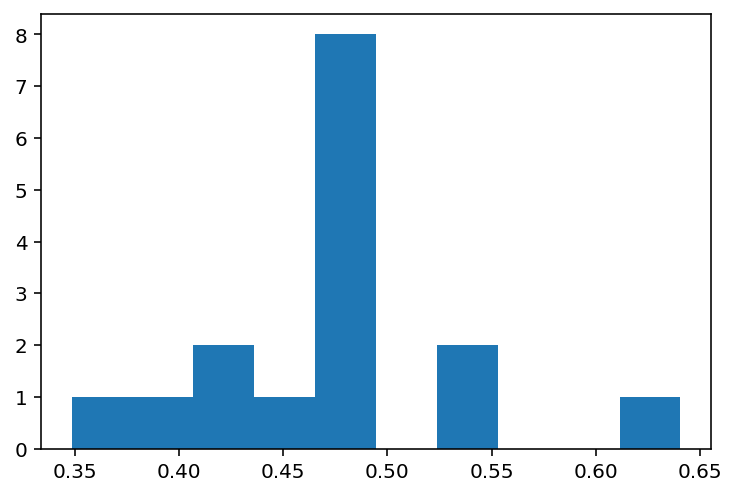

In [4]:
pylab.hist(mouses_data.proportion_of_time)
pylab.show()

и увидим, что, ну да, действительно большая часть выборки колеблется где-то в районе половины времени.
Теперь нужно ответить на вопрос, правда ли у мышей есть предпочтение относительно зеркала. Самое простое - интервально оценить среднюю долю времени которое мыши проводят в комнате с зеркалом. Для этого можно вопсользоваться zconfint

## Одновыборочные критерии

In [5]:
print ('95%% confidence interval for the mean time: [%f, %f]' % zconfint(mouses_data))

95% confidence interval for the mean time: [0.442918, 0.507660]


 Теперь давайте это строго оценим. Ну первое, что можно сделать, это посчитать интервальную оценку на медиану времени. Вот видим, что наша медиана меняется от 0,44 до 0,51, ну то есть видим, что половина времени входит, хотя интервал больше сдвинут влево относительно половины. Теперь давайте потренируемся применять критерии. Начнем с критерия знаков. В данном случае мы с вами будем проверять гипотезу о том, что медиана доли времени, которую мыши проводят в комнате с зеркалом, равняется 0,5, ну то есть половина времени. А проверять эту гипотезу можно относительно двусторонней альтернативы, то есть о том, что медиана доли времени в комнате с зеркалом не равняется 0,5, так и против любой из односторонних альтернатив. То, что медиана доли времени меньше или больше, чем 0,5. Вот мы с вами начнем с двусторонней альтернативы и начнем с критерия знаков. Для этого мы будем пользоваться функцией sign_test из библиотеки statsmodels. В эту функцию нужно передать наши данные, это mouses data, и то значение, относительно которого мы гипотезу проверяем, то есть в нашем случае это 0.5.

### Критерий знаков

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

In [6]:
print ("M: %d, p-value: %f" % sign_test(mouses_data, 0.5))

M: -5, p-value: 0.021271


 Давайте запустим функцию. Во-первых, она нам возвращает статистику −5 и p_value 0,02. Мы видим, что p_value достаточно маленькая, чтобы мы могли отклонить нулевую гипотезу на уровне значимости 0,05. Соответственно, делаем вывод о том, что медиана доли времени проведенного в клетке с зеркалом, все-таки отличается от 0,5. Значит у мышей, наверное, есть какие-то предпочтения. Вот давайте проверим это с помощью другого теста или с помощью критерия знаковых рангов Уилкоксона. В данном случае реализация находится в библиотеке SciPy, модуль stats и называется wilcoxon. Мы передаем туда наши данные. И давайте посмотрим, что мы видим.

### Критерий знаковых рангов Вилкоксона

In [7]:
m0 = 0.5
stats.wilcoxon(mouses_data.proportion_of_time - m0)

WilcoxonResult(statistic=35.0, pvalue=0.08793560714236243)

 Видим, что значение статистики равняется 0 и p-value очень маленькая, то есть этот тест так же подтверждает, что нулевую гипотезу нужно отклонить. Последний критерий, который мы применяем — это перестановочный критерий. В рамках этого критерия мы проверяем гипотезу о том, что среднее равняется 0,5 против альтернативы о том, что среднее не равняется 0,5. Готовой реализации этого критерия нету, поэтому нам придется самим его реализовать. Ну это не очень сложно. Для начала давайте рассчитаем T-статистику. Это очень просто — нам с вами нужно просто посчитать сумму значений нашей выборки, при этом из каждого значения нужно вычесть среднее. Вот ровно это здесь делается, и получаем вот такую реализацию. Можем сразу посмотреть, чему равна T-статистика в случае с нашей выборкой, передаем туда среднее и

### Перестановочный критерий

$H_0\colon$ среднее равно 0.5

$H_1\colon$ среднее не равно 0.5

In [8]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

In [9]:
permutation_t_stat_1sample(mouses_data.proportion_of_time, 0.5)

-0.3953776999999997

 видим, что в нашем случае этого назначения получается −0,4. Теперь нам нужно реализовать функцию для подсчета нулевого распределения. Так как в случае, если нулевая гипотеза справедлива и каждый из элементов выборки может с одинаковой вероятностью реализоваться как справа, так и слева от своего среднего, то для получения нулевого распределения нам нужно сделать следующее. Нужно взять все элементы выборки, вычесть из них среднее и далее сгенерировать на основе получившейся выборки набор выборок со всеми возможными перестановками знаков перед каждым элементом. Ну понятно, что таких выборок очень много, их ровно 2 в степени n, где n — размер исходной выборки. Поэтому для того, чтобы иметь возможность считать этот критерий быстрее, мы вводим дополнительный параметр max permutations, то есть максимальное количество перестановок, которые мы хотим перебрать. В данном случае у нас есть следующая логика. Вместо того чтобы генерировать все возможные комбинации знаков перед элементами выборки, мы с вами сгенерируем только несколько случайных и будем оценивать нулевое распределение относительно сгенерированных случайных выборок. Ну давайте посмотрим на реализацию. Она тоже очень понятная. Сначала мы просто вычитаем среднее из всех элементов выборки и дальше, в зависимости от того, указано ли количество max permutations, мы либо генерируем случайный набор последовательности знаков, либо честно перебираем все возможные знаки. Далее для подсчета нулевого распределения, мы просто суммируем значения элементов в получившихся подвыборках с учетом знаков, и возвращаем нулевое распределение. 

In [10]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

Вот давайте посмотрим на то, как это распределение выглядит. Помним, что это должно быть табличное распределение… Ну вот так оно и выглядит.

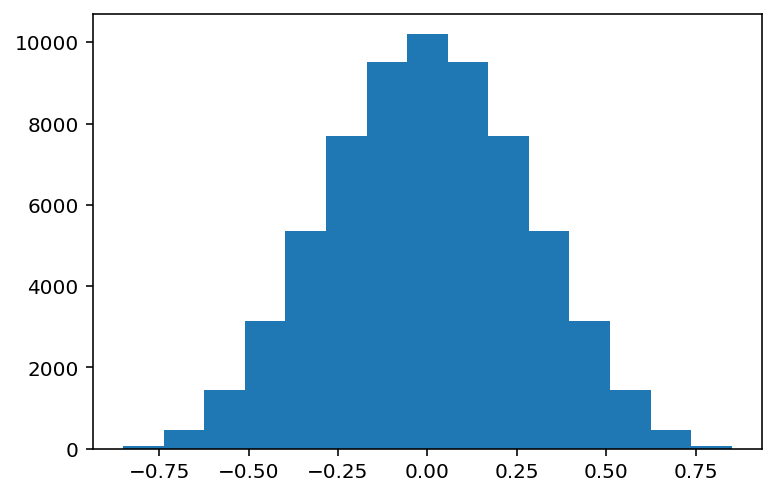

In [11]:
pylab.hist(permutation_zero_distr_1sample(mouses_data.proportion_of_time, 0.5), bins = 15)
pylab.show()

 Мы видим табличное распределение вот с центром в точке 0. Так, теперь давайте посмотрим на реализацию самого теста. Она тоже очень понятная. А так как мы с вами можем применять этот критерий как с двусторонними, так и с односторонними альтернативами, давайте сразу же помимо параметров sample mean и max permutation, добавим параметр «тип альтернативы». В данном случае two sided соответствует двусторонней альтернативе, less и greater — соответствующим односторонним. Итак, теперь для того чтобы применить тест, нам с вами нужно рассчитать T-статистику (мы уже реализовали функцию для этого), получить нулевое распределение, а дальше, в зависимости от того, какая альтернатива проверяется, вычислить p-value. Так как мы с вами имеем дело с небольшой выборкой – всего 16 элементов, мы можем честно построить все перестановки и посмотреть на значение p-value в этом случае. Вот давайте это сделаем.

In [12]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
print ("p-value: %f" % permutation_test(mouses_data.proportion_of_time, 0.5))

p-value: 0.157776


 Видим, что это занимает совсем немного времени, и мы получаем p-value 0,16. Вот давайте сделаем то же самое, но возьмем только часть перестановок. Ну, допустим всего 10 000. 

In [14]:
print ("p-value: %f" % permutation_test(mouses_data.proportion_of_time, 0.5, 10000))
# 165390

p-value: 0.162575


Метод будет работать еще быстрее и видим, что p-value отличается не очень сильно, тоже 0,16. Соответственно, на этом уровне значимости, на уровне значимости 0,05 или на уровне значимости 0,1, мы отвергнуть нулевую гипотезу не можем. А мы на этом заканчиваем и в следующем видео потренируемся применять непараметрические критерии в случае двух связанных выборок.

# 3. Непараметрические критерии (stat.non_parametric_tests_rel)

В этом видео мы поговорим про двухвыборочные непараметрические критерии для проверки статистических гипотез. Работать будем со случаем связных выборок. Решать будем следующую задачу. В рамках исследования оценивалась эффективность применения поведенческой терапии для лечения анорексии. Для 50 пациентов, проходивших эту терапию, известен вес «до» и вес «после» терапии. Соответственно, нам с вами нужно определить, являлась ли терапия эффективной. Итак, традиционно сначала загружаем данные. 

## Терапия при анорексии

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [15]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [17]:
weight_data = pd.read_csv('data/weight.txt', sep = '\t', header = 0)
weight_data.head(3)

,Before,After
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4


Видим, что структура данных довольно простая, перед нами data frame, состоящая из двух колонок, в первой для нас известен вес пациентов до операции, во второй – вес пациентов после операции. Так, давайте отрисуем гистограммы этих весов, посмотрим на них.

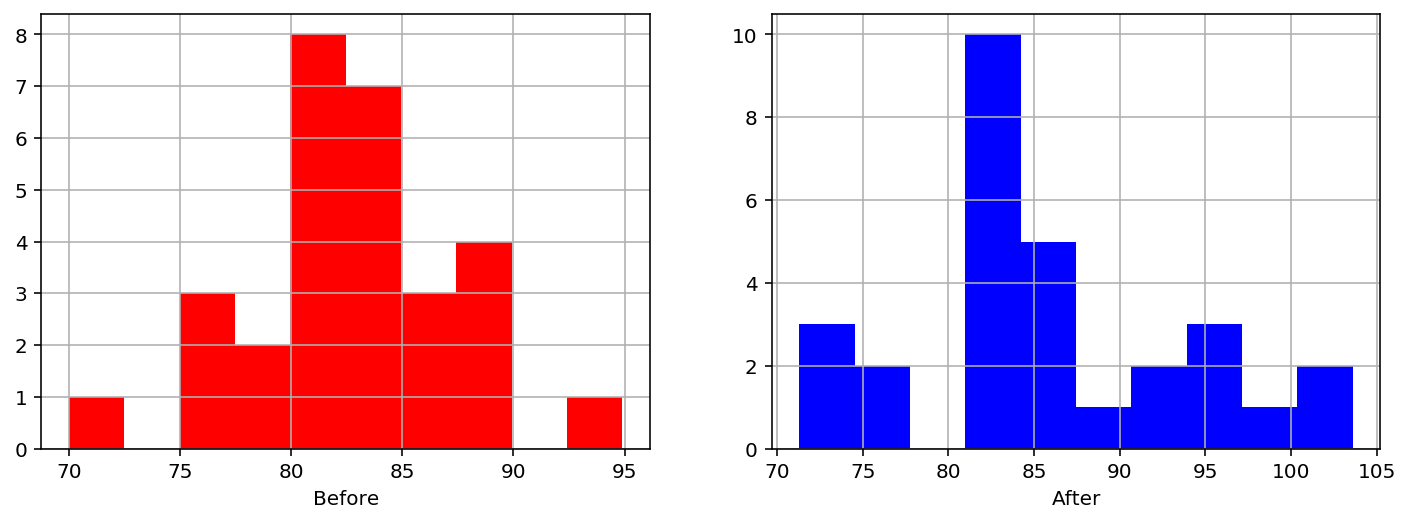

In [18]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(weight_data.Before, color = 'r')
pylab.xlabel('Before')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(weight_data.After, color = 'b')
pylab.xlabel('After')

pylab.show()

 Видим, что да, левая и правая границы гистограмм отличаются. Можно сказать, что гистограмма, построенная по данным после терапии немножечко сдвинута вправо относительно гистограммы, построенной до терапии, однако этого, конечно, недостаточно для того чтобы сделать вывод о том, что терапия оказалась эффективной. Давайте посмотрим на то, как изменялись средние веса. 

In [19]:
weight_data.describe()

,Before,After
count,29.000000,29.000000
mean,82.689655,85.696552
std,4.845495,8.351924
min,70.000000,71.300000
25%,80.400000,81.900000
50%,82.600000,83.900000
75%,85.000000,90.900000
max,94.900000,103.600000


Видим, что средний вес после терапии также стал больше, однако это тоже недостаточно неточная оценка. Ну давайте еще сделаем интервальную оценку на средний вес. Так, это можно сделать с помощью метода zconfint, мы его уже разбирали. И вот давайте посмотрим, что мы получаем. 

Видим, что интервалы весов до терапии и после терапии пересекаются. То есть все равно сложно сделать однозначный вывод о том, что терапия помогла. Нужно применять критерий для провеки гипотез. Давайте рассмотрим гипотезу о том, что медиана веса до терапии и после терапии совпадают против двусторонней альтернативы о том, что они отличаются. Для того чтобы применять двухвыборочные критерии для проверки гипотез, для начала нам нужно посчитать попарные разности весов пациентов до и после терапии. Давайте это сделаем и посмотрим на то, как эта величина распределена. 

## Двухвыборочные критерии для связных выборок

$H_0\colon$ медианы веса до и после терапии совпадает

$H_1\colon$ медианы веса до и после тепрапии отличаются

In [20]:
print ('95%% confidence interval for mean weight before therapy: [%f, %f]' % zconfint(weight_data.Before))

95% confidence interval for mean weight before therapy: [80.926107, 84.453203]


In [21]:
print ('95%% confidence interval for mean weight after therapy: [%f, %f]' % zconfint(weight_data.After))

95% confidence interval for mean weight after therapy: [82.656817, 88.736286]


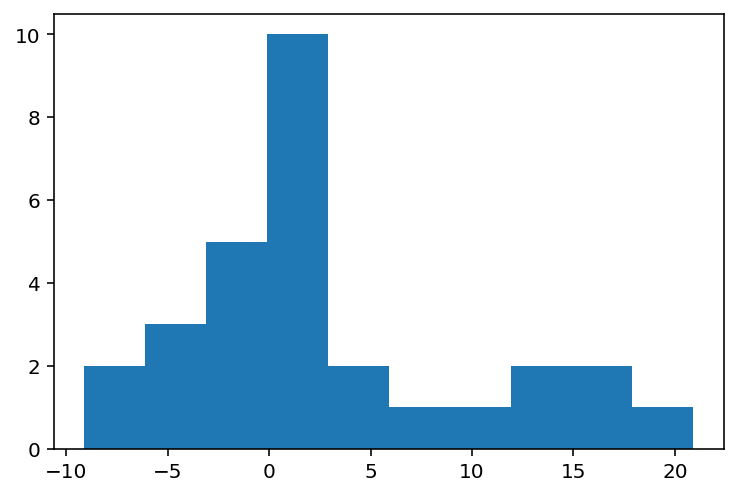

In [22]:
pylab.hist(weight_data.After - weight_data.Before)
pylab.show()

Мы видим, что основные значения колеблются около 0, ±5 килограмм. Теперь давайте применим критерий знаков. Будем тестировать гипотезу о том, что медианы весов до и после терапии равны, против альтернативы о том, что они не равны. Посчитать критерий знаков можно с помощью метода sign test из модуля StatsModules, однако, если помните, в прошлом видео мы передавали туда одну выборку, в данном случае мы сделаем то же самое, только вместо выборки передадим попарные разности на двух выборках. То есть, фактически это тоже выборка одна, но только в ней содержатся разности, посчитанные по двум связным выборкам. Давайте посмотрим, что мы получим. 

### Критерий знаков

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [23]:
print ("M: %d, p-value: %f" % sign_test(weight_data.After - weight_data.Before))

M: 3, p-value: 0.264931


Видим, что значение статистики равняется 3 и p-value = 0,26. Видим, что p-value достаточно большое, поэтому мы с вами не можем отвергнуть нулевую альтернативу, соответственно, не можем сделать вывод о том, что у нас веса изменились, что терапия оказалась эффективной. Давайте посмотрим, быть может, с помощью критерия рангов Уилкоксона получится другой результат. Здесь хочется обратить ваше внимание на то, что эту функцию можно применять по-разному. С одной стороны, мы можем передать туда две выборки, с другой стороны, мы точно так же, как и в случае с критерием знаков, можем передать туда попарные разности. Вот давайте попробуем сделать и то, и другое, и, конечно же, нам хотелось бы, чтобы результат получился одинаковый.

### Критерий знаковых рангов Уилкоксона

$H_0\colon med\left(X_1-X_2\right)=0,$

$H_1\colon med\left(X_1-X_2\right)\neq0$

In [24]:
stats.wilcoxon(weight_data.After, weight_data.Before)

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

 Итак, сначала передаем туда две выборки. Видим, что статистика равняется 131,5, и p-value получается 0,06. Ну, на самом деле p-value уже гораздо ниже, чем в предыдущем случае, однако все равно недостаточно низкое значение, чтобы, скажем, с уверенностью 0,05 отвергнуть эту гипотезу, нулевую гипотезу.

In [25]:
stats.wilcoxon(weight_data.After - weight_data.Before)

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

 Итак, пробуем запустить в другом режиме, и видим, что результат получается точно такой же. То есть можно сделать вывод о том, что можно делать обоими способами. Ну и вот, понимаем, что на уровне значимости 0,05 мы отвергнуть нулевую гипотезу не можем, но, однако, на уровне значимости 0,1 – можем. Двигаемся дальше. Подходим к перестановочному критерию. В данном случае критерий нам придется реализовать самостоятельно, однако на прошлом уроке мы уже это делали, поэтому давайте не будем подробно останавливаться на реализации. Первая функция, которая нам понадобится, это функция для вычисления t-статистики по выборке в реализуемое.

### Перестановочный критерий

$H_0\colon \mathbb{E}(X_1 - X_2) = 0$

$H_1\colon \mathbb{E}(X_1 - X_2) \neq 0$

In [26]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

In [27]:
#  Далее нам нужно обязательно уметь считать нулевое распределение. 
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

И давайте сразу же посмотрим, как это нулевое распределение будет выглядеть в случае наших данных. Ну, давайте остановимся на 10 000 перестановок. 

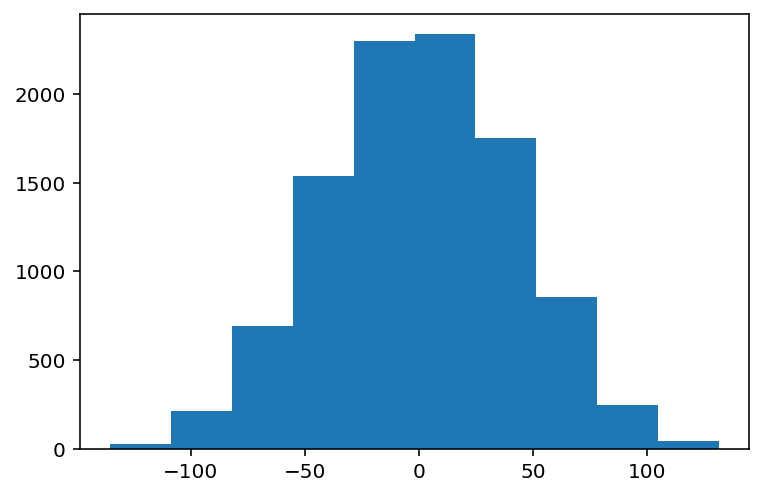

In [28]:
pylab.hist(permutation_zero_distr_1sample(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 10000))
pylab.show()

И посмотрим. Видим, что получилось табличное распределение, так, как мы и ожидали. Итак, теперь нам понадобится функция непосредственно для рассчета p-value. И теперь давайте это p-value рассчитаем.

In [29]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [30]:
print ("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 1000))
# 0.0290

p-value: 0.037000


 Ну вот, возьмем 1000 перестановок и посмотрим, что мы получили. Мы видим, что мы получили довольно маленькое значение p-value, всего лишь 0,04. Получается, что с помощью критерия перестановочного мы с вами можем отвергнуть нулевую гипотезу на уровне значимости 0,05. Может быть, мы взяли недостаточно много перестановок и нужно просто взять больше? Давайте возьмем вместо тысячи 50 000 и посмотрим, как изменится p-value. 

In [31]:
print ("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 50000))
# p-value: 0.033462

p-value: 0.033782


Так, видим, что это считается чуть дольше, но видим, что p-value на самом деле изменилось не очень сильно. Получается, что на уровне значимости 0,05 мы можем смело отвергать нулевую гипотезу и делать вывод о том, что, наверное, терапия оказалась эффективной. Наверняка вам интересно, почему же так получается, почему мы применяем разные критерии и вынуждены делать разные выводы. Давайте разбираться. Ну, во-первых, разные критерии по-разному оценивают среднее. В случае критерия знаков под «средним» мы с вами понимаем «медиану веса», а в случае перестановочного критерия под «средним» мы с вами понимаем «матожидание разности весов». Уже в этом месте начинаются разночтения. С другой стороны, разница есть в том, как много информации использует критерий. В частности, знаковые критерии используют только знаки перед нашими значениями и не учитывают абсолютные значения. Ранговые критерии используют только порядка. Перестановочный критерий уже использует гораздо больше информации, потому что он учитывает значение. Соответственно, в этом случае нам оказалось этого достаточно для того, чтобы отвергнуть нулевую гипотезу. Мы с вами на этом заканчиваем. На этом видео мы научились применять двухвыборочные непараметрические критерии в случае связных выборок. А в следующем видео мы с вами поговорим про несвязные выборки.

# 4. Непараметрические критерии (stat.non_parametric_tests_ind)

## Недвижимость в Сиэттле

В этом видео мы заканчиваем рассматривать непараметрические критерии для проверки статистических гипотез, и в этот раз мы поговорим про двухвыборочные критерии в случае независимых выборок. Решать будем довольно интересную задачу. У нас есть данные о продажной стоимости недвижимости в Сиэтле для 50 сделок 2001 года и 50 сделок 2002 года. Нам нужно понять, изменилась ли в среднем цена. Итак, давайте загрузим данные,

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [32]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [34]:
seattle_data = pd.read_csv('data/seattle.txt', sep = '\t', header = 0)
print(seattle_data.shape)
seattle_data.head()

(100, 2)


,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


 посмотрим на них и убедимся, что структура очень простая. У нас известна цена и известен год, за который эта цена измерялась. Давайте разделим данные по разным годам и построим гистограмму.

In [35]:
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

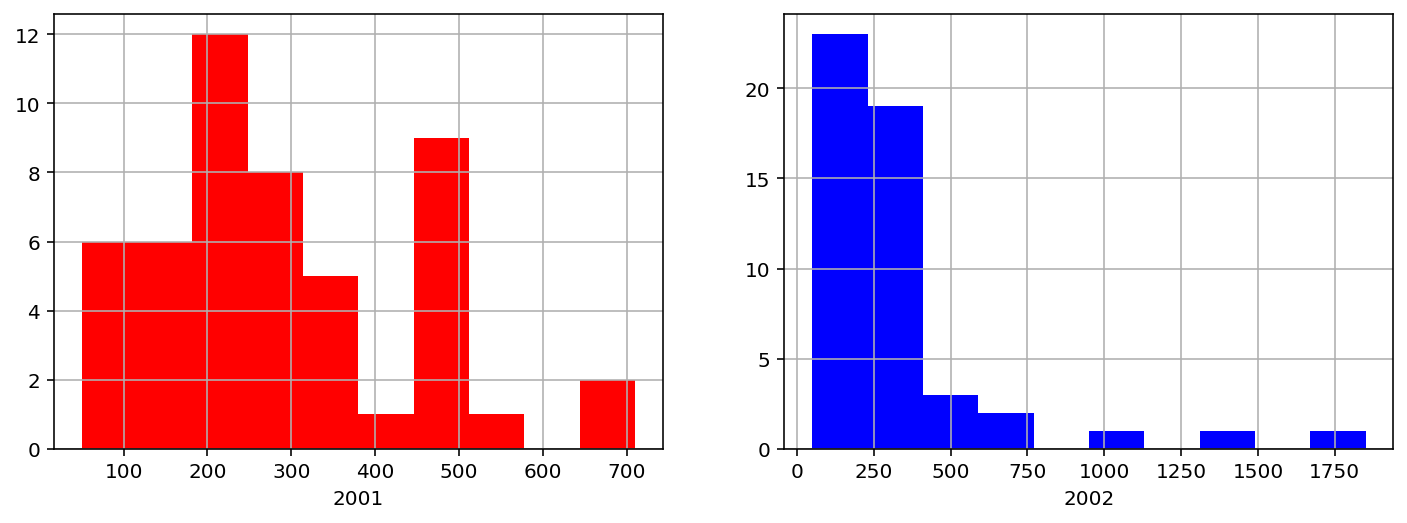

In [36]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

 Итак, видим, что по гистограмме довольно сложно понять, насколько изменились цены, поэтому давайте применим некоторые критерии, которые формально помогут нам проверить, изменилась ли цена в среднем или нет. Первый критерий, на который мы посмотрим, это ранговый критерий Манна-Уитни, то есть ранговый критерий, двухвыборочный, для независимых выборок. Будем рассматривать следующую альтернативу: медиана стоимости недвижимости в 2001 и 2002 годах совпадают. Против двусторонней альтернативы о том, что медианы не совпадают. Итак, давайте для начала выведем 95 % доверительный интервал для среднего. Сначала для 2001 года, потом для 2002 года.

## Двухвыборочные критерии для независимых выборок

In [37]:
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001))

95% confidence interval for the mean: [245.193581, 332.659499]


In [38]:
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002))

95% confidence interval for the mean: [241.437946, 417.076334]


 Видим, что они пересекаются. Пересечение довольно сильное, поэтому нам опять же сложно сделать выводы о том, изменились ли цены или нет. Единственное, что мы видим, что правый интервал доверительного интервала для 2002 года сильно правее. Поэтому мы можем предположить, что какие-то изменения были. Ну, теперь давайте это проверим. В случае рангового критерия мы проверяем гипотезу о том, что вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки. Альтернатива — то, что это не так. Для того чтобы этот критерий рассчитать, нам нужно воспользоваться функцией Манна-Уитни из модуля stats библиотеки SciPy. Передаем туда две наших выборки и смотрим, что мы получили.

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [39]:
stats.mannwhitneyu(price2001, price2002)
# MannwhitneyuResult(statistic=1295.5, pvalue=0.75638726757017483)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

 Перед нами значение статистики и p-value. p-value довольно большой, поэтому отвергнуть нулевую гипотезу мы не можем. Мы не можем сказать, что цены изменились. Давайте попробуем применить перестановочный критерий, может быть, в этом случае мы получим противоположный результат. В случае перестановочного критерия для независимых выборок, мы несколько по-другому сравниваем среднее. В данном случае мы с вами сравниваем функции распределения. Таким образом, нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке. Итак, давайте это посчитаем. Для начала нам с вами нужно реализовать рассчет t-статистики. В этом случае он очень простой. Это просто разность средних первой и второй выборки. Делаем это.

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [40]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

 И дальше нам с вами нужно научиться считать нулевое распределение. В случае справедливости нулевой гипотезы любое значение, встреченное, например, в первой выборке, мы могли бы с тем же успехом встретить и во второй выборке. То есть если нулевая гипотеза справедлива, то мы можем равновероятно получить любое разделение исходных данных на две подвыборки. Поэтому давайте поступим следующим образом. Для того чтобы получить нулевое распределение, нам нужно с вами построить все возможные комбинации, все возможные разбиения данных на подвыборки, то есть, получается, построить все сочетания. Однако мы понимаем, что в случае существенных размеров хотя бы одной из выборок это довольно долго. Давайте сделаем следующим образом. Реализуем возможность ограничивать количество перестановок, которые мы рассматриваем. Для этого заведем переменную max combinations, максимальное количество комбинаций, и будем действовать следующим образом. Сначала объединим наши выборки в одну, также рассчитаем необходимые нам параметры, это размер первой выборки и размер объединенной выборки. И дальше поступим следующим образом: если нам задано ограничение на максимальное количество комбинаций, то давайте сгенерируем индексы для разбиения данных на первую и вторую выборку случайным образом. Если же нам такого ограничения не задано, то давайте явно переберем все возможные комбинации с помощью метода combinations из модуля itertools. Далее, после того как индексы мы получили, давайте просто построим разделение нашей выборки на две по соответствующим индексам и далее рассчитаем нужную статистику, то есть разницу средних по полученным разбиениям. Вот это у нас реализовано. И отдельно можно обратить внимание, что получение случайных разбиений, случайных индексов, реализовано с помощью функции get random combinations. Вот оно также перед нами.

In [41]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [42]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

 Итак, теперь давайте построим гистограмму для нашего нулевого распределения. В общем-то, выглядеть оно должно ну, не совсем, как нормальное, но несколько похоже, то есть, пик тоже должен быть в центре, он должен быть в нуле. Давайте посмотрим, как это выглядит.

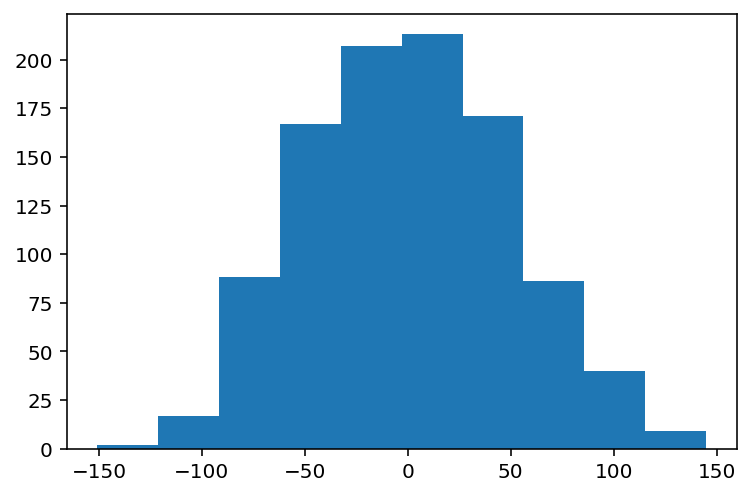

In [43]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

 Ну, да, видим, что даже довольно красиво получилось, очень похоже на нормальное. Так, теперь давайте применим сам перестановочный критерий, для этого мы снова пользуемся уже привычной нам реализацией рассчета p-value. 

In [44]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

И давайте для начала ограничимся 10 000 перестановок. Для рассчета p-value воспользуемся функцией permutation test, ее реализация вам снова знакома, однако обратите внимание, что здесь мы заменяем статистику и заменяем нулевое распределение. И давайте рассчитаем p-value в случае ограничения на количество перестановок в 10 000.

In [45]:
print ("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))
# p-value: 0.029000

p-value: 0.439700


 Видим, что мы получаем снова довольно большое значение p-value — 0,43. Оно не такое большое как в случае рангового критерия Манна-Уитни, но тоже достаточно большое для того, чтобы мы не смогли отвергнуть нулевую гипотезу. И давайте также рассчитаем значение p-value для 50 000 перестановок.

In [46]:
print ("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000))
# p-value: 0.033462

p-value: 0.443340


 Мы также получаем похожее значение 0,44. То есть мы видим, что ни один из критериев отвергнуть нулевую гипотезу нам не позволяет. То есть мы с вами не можем сказать, что цены изменились. На этом мы с вами заканчиваем изучение непараметрических критериев, а на следующей неделе вас ждет очень интересная тема «Поиск закономерностей и взаимосвязей в данных».

# 4. Непараметрические критерии (stat.non_parametric_tests_ind)

## Недвижимость в Сиэттле

В этом видео мы заканчиваем рассматривать непараметрические критерии для проверки статистических гипотез, и в этот раз мы поговорим про двухвыборочные критерии в случае независимых выборок. Решать будем довольно интересную задачу. У нас есть данные о продажной стоимости недвижимости в Сиэтле для 50 сделок 2001 года и 50 сделок 2002 года. Нам нужно понять, изменилась ли в среднем цена. Итак, давайте загрузим данные,

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [47]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [48]:
seattle_data = pd.read_csv('data/seattle.txt', sep = '\t', header = 0)
print(seattle_data.shape)
seattle_data.head()

(100, 2)


,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


 посмотрим на них и убедимся, что структура очень простая. У нас известна цена и известен год, за который эта цена измерялась. Давайте разделим данные по разным годам и построим гистограмму.

In [49]:
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

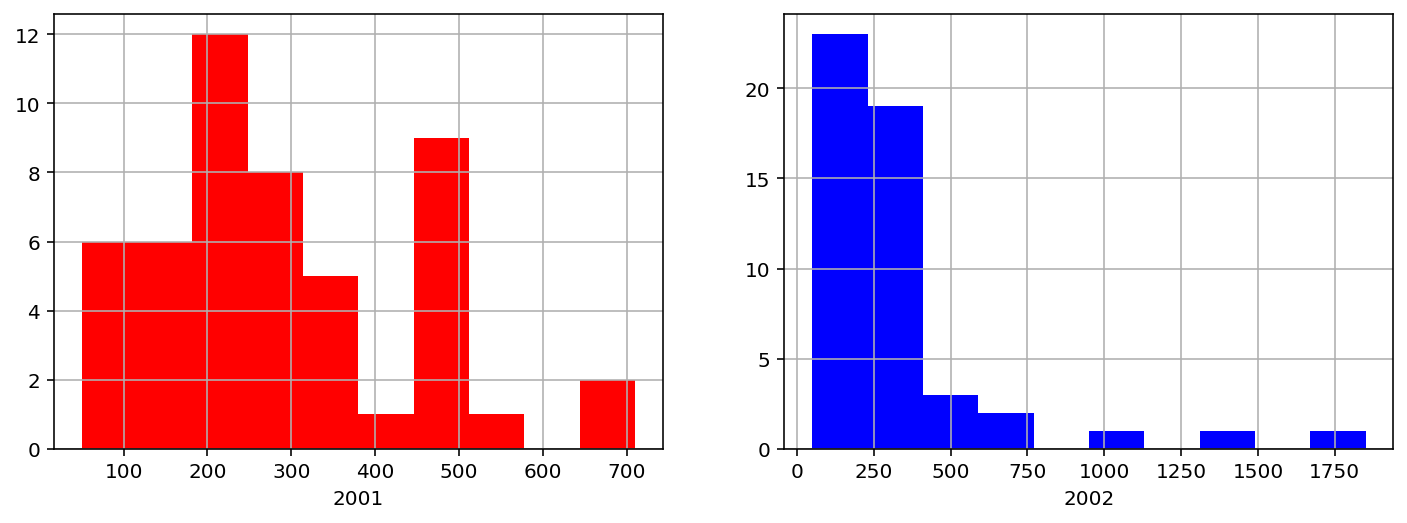

In [50]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

 Итак, видим, что по гистограмме довольно сложно понять, насколько изменились цены, поэтому давайте применим некоторые критерии, которые формально помогут нам проверить, изменилась ли цена в среднем или нет. Первый критерий, на который мы посмотрим, это ранговый критерий Манна-Уитни, то есть ранговый критерий, двухвыборочный, для независимых выборок. Будем рассматривать следующую альтернативу: медиана стоимости недвижимости в 2001 и 2002 годах совпадают. Против двусторонней альтернативы о том, что медианы не совпадают. Итак, давайте для начала выведем 95 % доверительный интервал для среднего. Сначала для 2001 года, потом для 2002 года.

## Двухвыборочные критерии для независимых выборок

In [51]:
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001))

95% confidence interval for the mean: [245.193581, 332.659499]


In [52]:
print ('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002))

95% confidence interval for the mean: [241.437946, 417.076334]


 Видим, что они пересекаются. Пересечение довольно сильное, поэтому нам опять же сложно сделать выводы о том, изменились ли цены или нет. Единственное, что мы видим, что правый интервал доверительного интервала для 2002 года сильно правее. Поэтому мы можем предположить, что какие-то изменения были. Ну, теперь давайте это проверим. В случае рангового критерия мы проверяем гипотезу о том, что вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки. Альтернатива — то, что это не так. Для того чтобы этот критерий рассчитать, нам нужно воспользоваться функцией Манна-Уитни из модуля stats библиотеки SciPy. Передаем туда две наших выборки и смотрим, что мы получили.

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [53]:
stats.mannwhitneyu(price2001, price2002)
# MannwhitneyuResult(statistic=1295.5, pvalue=0.75638726757017483

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

 Перед нами значение статистики и p-value. p-value довольно большой, поэтому отвергнуть нулевую гипотезу мы не можем. Мы не можем сказать, что цены изменились. Давайте попробуем применить перестановочный критерий, может быть, в этом случае мы получим противоположный результат. В случае перестановочного критерия для независимых выборок, мы несколько по-другому сравниваем среднее. В данном случае мы с вами сравниваем функции распределения. Таким образом, нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке. Итак, давайте это посчитаем. Для начала нам с вами нужно реализовать рассчет t-статистики. В этом случае он очень простой. Это просто разность средних первой и второй выборки. Делаем это.

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [54]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

 И дальше нам с вами нужно научиться считать нулевое распределение. В случае справедливости нулевой гипотезы любое значение, встреченное, например, в первой выборке, мы могли бы с тем же успехом встретить и во второй выборке. То есть если нулевая гипотеза справедлива, то мы можем равновероятно получить любое разделение исходных данных на две подвыборки. Поэтому давайте поступим следующим образом. Для того чтобы получить нулевое распределение, нам нужно с вами построить все возможные комбинации, все возможные разбиения данных на подвыборки, то есть, получается, построить все сочетания. Однако мы понимаем, что в случае существенных размеров хотя бы одной из выборок это довольно долго. Давайте сделаем следующим образом. Реализуем возможность ограничивать количество перестановок, которые мы рассматриваем. Для этого заведем переменную max combinations, максимальное количество комбинаций, и будем действовать следующим образом. Сначала объединим наши выборки в одну, также рассчитаем необходимые нам параметры, это размер первой выборки и размер объединенной выборки. И дальше поступим следующим образом: если нам задано ограничение на максимальное количество комбинаций, то давайте сгенерируем индексы для разбиения данных на первую и вторую выборку случайным образом. Если же нам такого ограничения не задано, то давайте явно переберем все возможные комбинации с помощью метода combinations из модуля itertools. Далее, после того как индексы мы получили, давайте просто построим разделение нашей выборки на две по соответствующим индексам и далее рассчитаем нужную статистику, то есть разницу средних по полученным разбиениям. Вот это у нас реализовано. И отдельно можно обратить внимание, что получение случайных разбиений, случайных индексов, реализовано с помощью функции get random combinations. Вот оно также перед нами.

In [55]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [56]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

 Итак, теперь давайте построим гистограмму для нашего нулевого распределения. В общем-то, выглядеть оно должно ну, не совсем, как нормальное, но несколько похоже, то есть, пик тоже должен быть в центре, он должен быть в нуле. Давайте посмотрим, как это выглядит.

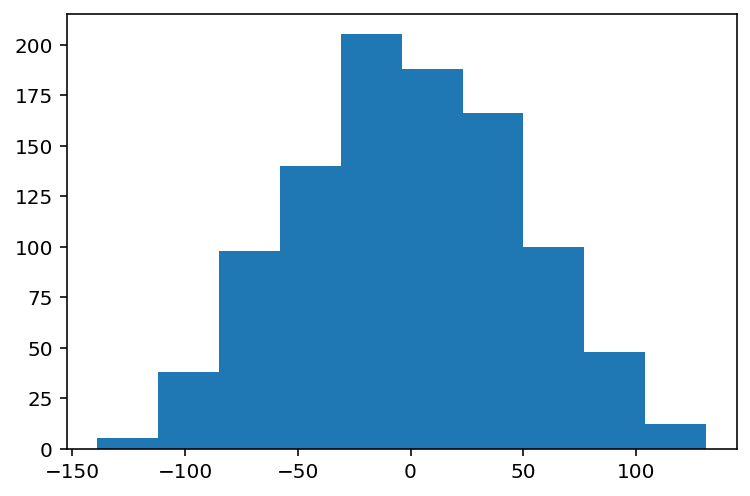

In [57]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

 Ну, да, видим, что даже довольно красиво получилось, очень похоже на нормальное. Так, теперь давайте применим сам перестановочный критерий, для этого мы снова пользуемся уже привычной нам реализацией рассчета p-value. 

In [58]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

И давайте для начала ограничимся 10 000 перестановок. Для рассчета p-value воспользуемся функцией permutation test, ее реализация вам снова знакома, однако обратите внимание, что здесь мы заменяем статистику и заменяем нулевое распределение. И давайте рассчитаем p-value в случае ограничения на количество перестановок в 10 000.

In [59]:
print ("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))
# p-value: 0.438300

p-value: 0.433600


 Видим, что мы получаем снова довольно большое значение p-value — 0,43. Оно не такое большое как в случае рангового критерия Манна-Уитни, но тоже достаточно большое для того, чтобы мы не смогли отвергнуть нулевую гипотезу. И давайте также рассчитаем значение p-value для 50 000 перестановок.

In [60]:
print ("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000))
# p-value: 0.443200

p-value: 0.438980


 Мы также получаем похожее значение 0,44. То есть мы видим, что ни один из критериев отвергнуть нулевую гипотезу нам не позволяет. То есть мы с вами не можем сказать, что цены изменились. На этом мы с вами заканчиваем изучение непараметрических критериев, а на следующей неделе вас ждет очень интересная тема «Поиск закономерностей и взаимосвязей в данных».

# Week 3 - Закономерности и зависимости
# 1. Корреляция Пирсона (stat.correlation)

В этом видео мы поговорим про поиск зависимости данных и потренируемся считать корреляцию Пирсона. Анализировать мы будем довольно интересный набор данных Foodmart product sales. В этом наборе данных для каждого продукта известно количество покупок этого продукта в некоторую дату, в определенном магазине. Мы с вами будем искать связи вида: правда ли, что покупки этого товара влияют на покупку второго товара? Правда ли, что покупки товара a приводят к увеличению или уменьшению покупок товара b? Давайте для начала загрузим данные.

In [1]:
import pandas as pd
import numpy as np

## Foodmart product sales 

 Наши данные состоят из двух файлов. Первый файл, Foodmart sales, говорит о том, сколько раз каждый продукт был продан в каждом магазине за некоторую дату. Давайте посмотрим, как это выглядит.

In [2]:
sales = pd.read_csv('data/foodmart.sales.tsv', sep = '\t', header = 0, parse_dates = [2])
sales.head()

,product_id,store_id,date,sales
0,4,6,1997-01-01,4
1,25,6,1997-01-01,3
2,48,6,1997-01-01,3
3,76,6,1997-01-01,4
4,119,6,1997-01-01,3


 Видим, что у нас всего 4 столбца. Первый столбец соответствует id продукта, второй — id магазинов, в которых произошли покупки, третий столбец — это дата в которую это произошло, ну и, соответственно, количество покупок. Второй файл, foodmart products, содержит огромное количество полей. На самом деле, нам далеко не все отсюда интересно. Нам просто не очень удобно работать с id продуктов, потому что они не несут смысловой нагрузки, нам хочется получить их имена. Соответственно, этот файл содержит столбец с id и столбец с именами, поэтому с помощью него мы сможем связать информацию о id продукта с его именем.

In [3]:
products = pd.read_csv('data/foodmart.products.tsv', sep = '\t', header = 0)
products.head()

,product_class_id,product_id,brand_name,product_name,SKU,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,shelf_width,shelf_height,shelf_depth
0,30,1,Washington,Washington Berry Juice,90748583674,2.85,8.39,6.39,False,False,30,14,16.9,12.60,7.40
1,52,2,Washington,Washington Mango Drink,96516502499,0.74,7.42,4.42,False,True,18,8,13.4,3.71,22.60
2,52,3,Washington,Washington Strawberry Drink,58427771925,0.83,13.10,11.10,True,True,17,13,14.4,11.00,7.77
3,19,4,Washington,Washington Cream Soda,64412155747,3.64,10.60,9.60,True,False,26,10,22.9,18.90,7.93
4,19,5,Washington,Washington Diet Soda,85561191439,2.19,6.66,4.65,True,False,7,10,20.7,21.90,19.20


 Это довольно просто делается, для этого мы будем пользоваться функцией merge. Вызываем функцию merge у первого dataframe sales. Дальше в качестве первого аргумента передаем второй dataframe. Давайте сразу отрежем только те столбцы, которые нам интересны, а так же указываем по какому столбцу можно производить соединение, в данном случае это столбец product id. И говорим, что мы хотим делать inner join, то есть мы хотим оставить только свое совпадающее значение. Ну в данном случае у нас с вами все значения совпадают, поэтому размер исходной таблицы будет совпадать с размером получившейся таблицы.

In [4]:
sales = sales.merge(products[['product_id', 'product_name']], 
                    on = ['product_id'], how = 'inner')
sales.head()

,product_id,store_id,date,sales,product_name
0,4,6,1997-01-01,4,Washington Cream Soda
1,4,7,1997-01-05,3,Washington Cream Soda
2,4,6,1997-01-06,2,Washington Cream Soda
3,4,17,1997-01-11,2,Washington Cream Soda
4,4,24,1997-01-11,2,Washington Cream Soda


 Давайте посмотрим, как это выглядит. Видим, что наша таблица sales теперь содержит дополнительное поле product name. Давайте проанализируем взаимное влияние продуктов друг на друга. Для этого давайте рассчитаем корреляцию Пирсона между каждой парой продуктов. Будем это делать по рассчитанной на предыдущем шаге таблице sales. Однако в таком виде, в каком она сейчас существует, это делать не очень удобно. Дело в том, что в этой таблице у нас есть информация только о покупках товара, и нет информации об отсутствии покупок некоторого товара. Ну то есть в некоторую дату в некотором магазине продукт a, скажем, не покупали, то у нас нет соответствующей строчки со значением sales = 0. Вот давайте эти строчки получим и вообще в целом немножечко изменим внешний вид таблицы. Давайте будем работать с таблицей, у которой индексом является дата и магазин, а в столбцах расположена информация о покупках продуктов. То есть каждый столбец соответствует своему продукту. Тогда в каждой строчке мы получим значение покупок этого продукта за соответствующую дату в соответствующем магазине. Таким образом, мы сможем добавить туда эти самые нулевые значения, которых нам не хватало, и сможем рассчитать корреляцию между всеми парами столбцов. Давайте сначала получим правильную таблицу, это делается с помощью метода pivot table. Передаем туда исходную таблицу. Указываем, что нас интересует значение столбца sales, в качестве значений, которые мы будем заполнять. Дальше индексами будут являться дата и id магазина, как мы уже говорили, и в качестве столбцов будут выбраны продукты. Ну в данном случае мы могли бы взять, как product id, так и product name. Но с именами работать немножко удобней, поэтому давайте остановимся на них.

## Взаимное влияние продуктов друг на друга

In [5]:
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                     columns=['product_name'], fill_value = 0)
sparse_sales.head()

product_name         ADJ Rosy Sunglasses  Akron City Map  \
date       store_id                                        
1997-01-01 6                           0               0   
           14                          0               0   
1997-01-02 11                          0               0   
           23                          0               0   
1997-01-03 7                           0               0   

product_name         Akron Eyeglass Screwdriver  American Beef Bologna  \
date       store_id                                                      
1997-01-01 6                                  0                      0   
           14                                 0                      0   
1997-01-02 11                                 0                      0   
           23                                 0                      0   
1997-01-03 7                                  0                      0   

product_name         American Chicken Hot Dogs  American Cole Slaw  \
date       store_id                                                  
1997-01-01 6                                 0                   0   
           14                                0                   0   
1997-01-02 11                                0                   0   
           23                                0                   0   
1997-01-03 7                                 0                   0   

product_name         American Corned Beef  American Foot-Long Hot Dogs  \
date       store_id                                                      
1997-01-01 6                            0                            0   
           14                           0                            0   
1997-01-02 11                           0                            0   
           23                           0                            0   
1997-01-03 7                            0                            0   

product_name         American Low Fat Bologna  American Low Fat Cole Slaw  \
date       store_id                                                         
1997-01-01 6                                0                           0   
           14                               0                           0   
1997-01-02 11                               0                           0   
           23                               0                           0   
1997-01-03 7                                0                           0   

product_name         ...  Washington Apple Juice  Washington Berry Juice  \
date       store_id  ...                                                   
1997-01-01 6         ...                       0                       0   
           14        ...                       0                       0   
1997-01-02 11        ...                       0                       0   
           23        ...                       0                       0   
1997-01-03 7         ...                       0                       4   

product_name         Washington Cola  Washington Cranberry Juice  \
date       store_id                                                
1997-01-01 6                       0                           0   
           14                      0                           0   
1997-01-02 11                      0                           0   
           23                      0                           0   
1997-01-03 7                       0                           0   

product_name         Washington Cream Soda  Washington Diet Cola  \
date       store_id                                                
1997-01-01 6                             4                     0   
           14                            0                     0   
1997-01-02 11                            0                     0   
           23                            0                     0   
1997-01-03 7                             0                     0   

product_name         Wa

 Итак, давайте соответствующую таблицу получим и посмотрим, как она выглядит. Понятно, что она будет очень большая. Ну давайте выведем только начало. Видим, что, действительно, индексами у нас являются дата и id магазина, и, соответственно, каждый столбец соответствует своему продукту. Вот мы видим, что их очень-очень-очень много. Добавилось огромное количество нулей. Ну и вот мы видим, что в тех местах, где у нас были покупки, вот эти значения остались, их можно найти. Что ж, теперь давайте рассчитывать корреляции. Так как мы с вами работаем с pandas dataframe, это делает очень просто — для этого достаточно просто вызвать метод corr. Запишем результат в новый dataframe, в новую таблицу. И так же давайте выведем только ее начало.

In [6]:
sales_correlation = sparse_sales.corr()
sales_correlation.head()

product_name,ADJ Rosy Sunglasses,Akron City Map,Akron Eyeglass Screwdriver,American Beef Bologna,American Chicken Hot Dogs,American Cole Slaw,American Corned Beef,American Foot-Long Hot Dogs,American Low Fat Bologna,American Low Fat Cole Slaw,...,Washington Apple Juice,Washington Berry Juice,Washington Cola,Washington Cranberry Juice,Washington Cream Soda,Washington Diet Cola,Washington Diet Soda,Washington Mango Drink,Washington Orange Juice,Washington Strawberry Drink
product_name,,,,,,,,,,,,,,,,,,,,,
ADJ Rosy Sunglasses,1.000000,0.076608,-0.006581,0.038685,0.041105,-0.045887,-0.008466,0.062309,0.033752,-0.009656,...,0.053533,0.072249,0.061736,-0.000735,0.000843,0.028226,0.012653,0.089932,0.072668,0.035745
Akron City Map,0.076608,1.000000,0.026297,0.088709,0.061144,0.039347,0.019767,-0.005998,0.010270,0.078176,...,-0.021793,0.020514,0.051956,-0.001018,-0.032582,0.007142,0.035274,0.033875,0.078070,0.051952
Akron Eyeglass Screwdriver,-0.006581,0.026297,1.000000,-0.040851,0.034345,0.108726,0.007573,0.162355,0.020933,0.074292,...,-0.000237,-0.001297,0.049793,0.055047,0.031202,0.013510,-0.017855,0.022714,0.003156,0.163519
American Beef Bologna,0.038685,0.088709,-0.040851,1.000000,0.014780,-0.039118,-0.007890,-0.008264,-0.045949,0.085975,...,0.000197,0.081151,-0.053404,-0.021832,0.003286,0.090774,-0.031954,0.043843,0.080638,0.055211
American Chicken Hot Dogs,0.041105,0.061144,0.034345,0.014780,1.000000,-0.005336,0.017765,0.057972,0.071549,0.052460,...,0.098935,-0.024224,0.066212,0.043765,0.077541,0.045038,-0.037246,0.025975,0.129795,-0.008498


 Мы видим, что корреляция выглядит приблизительно так, как бы нам хотелось. По диагонали мы видим значения, соответствующие 1, ну по понятным причинам это корреляции между одним и тем же продуктом. И в остальных ячейках мы видим корреляции между парами продуктов. Такую таблицу очень удобно анализировать. По этой таблице для каждого продукта мы можем посмотреть, как его покупки коррелируют с покупками других продуктов и найти наиболее сильные корреляции. Причем, как в положительную, так и в отрицательную сторону. Вот давайте попробуем что-то такое сделать. Зафиксируем некоторый продукт, например, american chicken hot dogs и посмотрим, какие продукты, покупки каких продуктов, коррелируют с ним сильней всего. Для этого сначала просто выберем столбец, соответствующий этому продукту. На самом деле, можно было бы и строчку выбрать, данные будут те же самые. И просто отсортируем этот столбец по корреляциям. Сортировать будем по убыванию: ascending = false. 

In [7]:
product_name = 'American Chicken Hot Dogs'
sales_correlation[[product_name]].sort_values(product_name, ascending = False).head()

product_name,American Chicken Hot Dogs
product_name,
American Chicken Hot Dogs,1.000000
Mighty Good Monthly Home Magazine,0.240269
Big Time Frozen Chicken Wings,0.223398
Carlson Sour Cream,0.220726
Great Cranberry Muffins,0.217509


Давайте выведем тоже самое начало. Ну понятно, что со значением 1 в топ попадает этот же самый продукт, это нам не так интересно. Давайте смотреть следующее. Вот следующий продукт, это какой-то журнал. Мы вот видим, что его покупки коррелируют с покупками хот-догов на 0,24. Ну вот следующий, это frozen chicken wings (замороженные крылышки). Потом идет сметана, маффины. Мы видим, что довольно такой понятный топ продуктов. 

В принципе, мы можем посмотреть продукты, которые коррелируют меньше всего. Для этого давайте отсортируем просто в обратном порядке. Вернее, неверно сказать, что они меньше всего коррелируют, они коррелируют просто с отрицательным знаком. По сути, если корреляция по модулю большая, но перед ней стоит знак минус, значит, что покупки этих продуктов отрицательно влияют на покупки этого продукта. Ну давайте посмотрим. Меняем порядок, которым мы хотим сортировать и выводим топ. 

In [8]:
# Самые отрицательно коррелируемые
product_name = 'American Chicken Hot Dogs'
sales_correlation[[product_name]].sort_values(product_name, ascending = True).head()

product_name,American Chicken Hot Dogs
product_name,
Lake Pimento Loaf,-0.065509
Fast Low Fat Chips,-0.061037
PigTail Frozen Sausage Pizza,-0.058960
Plato Decaf Coffee,-0.058481
Kiwi Lox,-0.057037


Ну вот видим, что есть некоторые продукты, которые коррелируют с одним отрицательным знаком, нельзя сказать, что очень сильно, потому что все эти значения очень близки к нулю. Поэтому тут сложно сделать выводы. Давайте сделаем следующее. Давайте посмотрим, в принципе, максимальное по модулю отрицательное значение корреляции, чтобы понять, есть ли они в наших данных. Возможно, все отрицательные значения близки к 0 и мы просто ничего не сможем найти.

In [9]:
min_corr = pd.DataFrame(sales_correlation.min())
min_corr.columns = ['min']
min_corr.sort_values(by = 'min').head()

,min
product_name,
Carlson Whole Milk,-0.085064
Pearl Chardonnay Wine,-0.085064
Gulf Coast Malted Milk Balls,-0.082598
Sunset Economy Toilet Brush,-0.082598
Fast Fudge Brownies,-0.082317


 Да, мы видим, что так и есть. У нас нет больших по модулю отрицательных значений. Так, давайте посмотрим тогда на положительные значения. Может быть, они есть. Ну вот видим, что с положительными значениями корреляции ситуация обстоит несколько лучше. Вот есть довольно большие значения по модулю. 

In [10]:
max_corr = pd.DataFrame(sales_correlation.apply(lambda x : np.max(list(filter(lambda x : x != 1., x))), axis = 1))
max_corr.columns = ['max']
max_corr.sort_values(by = 'max', ascending = False).head()

,max
product_name,
Plato French Roast Coffee,0.340598
Just Right Vegetable Soup,0.340598
Nationeel Grape Fruit Roll,0.322176
Great Muffins,0.322176
Club Low Fat Cottage Cheese,0.306701


Вот давайте посмотрим на первый продукт и видим, что есть какие-то продукты, которые неплохо с ним коррелируют. 

In [11]:
product_name = 'Plato French Roast Coffee'
sales_correlation[[product_name]].sort_values(product_name, ascending = False).head()

product_name,Plato French Roast Coffee
product_name,
Plato French Roast Coffee,1.000000
Just Right Vegetable Soup,0.340598
Hermanos Macintosh Apples,0.289095
Tell Tale Macintosh Apples,0.273905
Consolidated Whitening Toothpast,0.247477


Ну, вот, да, видим, что с кофе покупают внезапно молочный суп. Ну то есть по таким таблицам достаточно просто можно получить представление о том, как покупки одного товара коррелируют с покупками другого товара и попытаться сделать соответствующие выводы. Мы с вами на этом заканчиваем. В этом видео мы поговорили о том, как считать корреляцию Пирсона. В следующем видео мы продолжим говорить о поиске взаимосвязи в данных.

# 2. Множественная проверка гипотез (stat.multiple_hypothesis_testing)

В этом видео мы продолжим анализировать взаимосвязи в данных и теперь поговорим про множественную проверку гипотез. Анализировать мы будем тот же набор данных, что и на прошлом занятии — foodmart product sales. Это данные о том, сколько продуктов было продано в каждом магазине за известные нам даты. Давайте традиционно начнем с загрузки набора данных. 

In [12]:
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests 

## Foodmart product sales 

In [13]:
sales = pd.read_csv('data/foodmart.sales.tsv', sep = '\t', header = 0, parse_dates = [2])

In [14]:
sales.head(3)

,product_id,store_id,date,sales
0,4,6,1997-01-01,4
1,25,6,1997-01-01,3
2,48,6,1997-01-01,3


Напомню, как это выглядит. Видим таблицу, состоящую из четырех столбцов: ID продукта, ID магазина, дата и количество продаж этого продукта. Нам также понадобится дополнительная информация о продуктах, в частности нас будет интересовать название каждого продукта, чтобы мы понимали, о каких данных идет речь.

In [15]:
products = pd.read_csv('data/foodmart.products.tsv', sep = '\t', header = 0)

In [16]:
products.head(3)

,product_class_id,product_id,brand_name,product_name,SKU,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,cases_per_pallet,shelf_width,shelf_height,shelf_depth
0,30,1,Washington,Washington Berry Juice,90748583674,2.85,8.39,6.39,False,False,30,14,16.9,12.60,7.40
1,52,2,Washington,Washington Mango Drink,96516502499,0.74,7.42,4.42,False,True,18,8,13.4,3.71,22.60
2,52,3,Washington,Washington Strawberry Drink,58427771925,0.83,13.10,11.10,True,True,17,13,14.4,11.00,7.77


 И давайте теперь объединим эти две таблицы, чтобы добавить в первую таблицу информацию о названии. Делаем это с помощью метода merge. Посмотрим, что получилось.

In [17]:
sales = sales.merge(products[['product_id', 'product_name']], on = ['product_id'], how = 'inner')

In [18]:
sales.head(3)

,product_id,store_id,date,sales,product_name
0,4,6,1997-01-01,4,Washington Cream Soda
1,4,7,1997-01-05,3,Washington Cream Soda
2,4,6,1997-01-06,2,Washington Cream Soda


 Видим, что у нас добавилась еще одна колонка с названием. Теперь давайте перейдем непосредственно к анализу данных. Так же, как и в прошлый раз, нам придется видоизменить таблицу, чтобы было удобнее с ней работать. В данном случае нам захочется представить таблицу в таком виде, чтобы каждому продукту соответствовал отдельный столбец. Соответственно, значения будут соответствовать количеству продаж данного продукта в некотором магазине за известную дату. Давайте такую таблицу получим. Снова используем метод pivot_table и посмотрим, как она выглядит.

## Корреляция Пирсона

In [19]:
sparse_sales = pd.pivot_table(sales, values='sales', index=['date', 'store_id'],
                              columns=['product_name'], fill_value = 0)

In [20]:
sparse_sales.head()

product_name         ADJ Rosy Sunglasses  Akron City Map  \
date       store_id                                        
1997-01-01 6                           0               0   
           14                          0               0   
1997-01-02 11                          0               0   
           23                          0               0   
1997-01-03 7                           0               0   

product_name         Akron Eyeglass Screwdriver  American Beef Bologna  \
date       store_id                                                      
1997-01-01 6                                  0                      0   
           14                                 0                      0   
1997-01-02 11                                 0                      0   
           23                                 0                      0   
1997-01-03 7                                  0                      0   

product_name         American Chicken Hot Dogs  American Cole Slaw  \
date       store_id                                                  
1997-01-01 6                                 0                   0   
           14                                0                   0   
1997-01-02 11                                0                   0   
           23                                0                   0   
1997-01-03 7                                 0                   0   

product_name         American Corned Beef  American Foot-Long Hot Dogs  \
date       store_id                                                      
1997-01-01 6                            0                            0   
           14                           0                            0   
1997-01-02 11                           0                            0   
           23                           0                            0   
1997-01-03 7                            0                            0   

product_name         American Low Fat Bologna  American Low Fat Cole Slaw  \
date       store_id                                                         
1997-01-01 6                                0                           0   
           14                               0                           0   
1997-01-02 11                               0                           0   
           23                               0                           0   
1997-01-03 7                                0                           0   

product_name         ...  Washington Apple Juice  Washington Berry Juice  \
date       store_id  ...                                                   
1997-01-01 6         ...                       0                       0   
           14        ...                       0                       0   
1997-01-02 11        ...                       0                       0   
           23        ...                       0                       0   
1997-01-03 7         ...                       0                       4   

product_name         Washington Cola  Washington Cranberry Juice  \
date       store_id                                                
1997-01-01 6                       0                           0   
           14                      0                           0   
1997-01-02 11                      0                           0   
           23                      0                           0   
1997-01-03 7                       0                           0   

product_name         Washington Cream Soda  Washington Diet Cola  \
date       store_id                                                
1997-01-01 6                             4                     0   
           14                            0                     0   
1997-01-02 11                            0                     0   
           23                            0                     0   
1997-01-03 7                             0                     0   

product_name         Wa

 Видим, что появилось очень много столбцов, соответствующих каждому продукту, и в качестве значений мы видим количество продаж. Теперь давайте рассчитаем корреляцию. Какую задачу мы с вами ставим? Мы хотим проверить, есть ли корреляция между покупками пары продуктов. При этом мы хотим не только посчитать значение корреляции, а также проверить гипотезу о том, что корреляция присутствует. Для расчета корреляции мы можем воспользоваться методом corr класса DataFrame, однако в данном случае нам интересно не только само значение корреляции, но и также p-value, потому что мы с вами хотим проверить гипотезу о том, что корреляция присутствует, против альтернативы о том, что ее нет. Для того чтобы это получить, нам понадобится функция pearsonr, это функция модуля stats библиотеки SciPy, поэтому мы с вами сделаем следующее: мы пройдемся циклом по парам продуктов и для каждой пары рассчитаем корреляцию и значение p-value, и дальше соберем всё это в удобный DataFrame. В DataFrame мы хотим видеть четыре столбца. Первые два столбца должны соответствовать названиям продуктов, в третий мы запишем корреляцию, и в четвертый — значение p-value. Вот давайте это сделаем.

In [21]:
%%time 
corr_data = []

for i, lhs_column in enumerate(sparse_sales.columns):
    for j, rhs_column in enumerate(sparse_sales.columns):
        if i >= j:
            continue
        
        corr, p = pearsonr(sparse_sales[lhs_column], sparse_sales[rhs_column])
        corr_data.append([lhs_column, rhs_column, corr, p])

CPU times: user 3min 41s, sys: 2.69 s, total: 3min 43s
Wall time: 4min 21s


 Эта процедура занимает существенное время, потому что у нас довольно много продуктов — порядка 1500. Соответственно, для всех пар мы с вами хотим получить корреляцию. Давайте подождем. Итак, расчет завершен. Мы видим, что на это потребовалось порядка двух минут, и теперь давайте посмотрим на DataFrame, который мы получили. 

In [22]:
sales_correlation = pd.DataFrame.from_records(corr_data)
sales_correlation.columns = ['product_A', 'product_B', 'corr', 'p']
sales_correlation.head(3)

,product_A,product_B,corr,p
0,ADJ Rosy Sunglasses,Akron City Map,0.076608,0.032414
1,ADJ Rosy Sunglasses,Akron Eyeglass Screwdriver,-0.006581,0.854396
2,ADJ Rosy Sunglasses,American Beef Bologna,0.038685,0.280546


Мы видим его начало, видим, что действительно в нем четыре столбца, первые два соответствуют названиям продуктов, в третьем мы видим значение корреляции, и в четвертом — p-value. Теперь давайте посчитаем, сколько же гипотез об отсутствии корреляции отвергает без правки на множественную проверку гипотез. Сделаем это с помощью метода value_counts(), посмотрим, сколько мы видим p-value больше и меньше, чем 0,05.

Сколько гипотез об отсутствии корреляции отвергается без поправки на множественную проверку?

In [23]:
(sales_correlation.p < 0.05).value_counts()

False    982453
True     232008
Name: p, dtype: int64

 Мы видим, что отвергается довольно много гипотез, порядка 200000. Теперь давайте сделаем правку на множественную проверку гипотез и посмотрим, насколько ситуация изменится. Первая поправка на множественную проверку гипотез, которой мы будем пользоваться, называется метод Холма. В рамках этой поправки мы ограничиваем вероятность того, что хотя бы на одном объекте будет ошибка, 5 %. Вот давайте эту правку применим, это делается довольно просто, соответствующий метод реализован в библиотеке StatsModels, он называется multipletests, и для того чтобы передать внутрь набор наших p-value, мы их уже получили, также нужно передать уровень значимости, с которым мы работаем. Ну вот если мы хотим ограничить вероятность ошибки 5 %, тогда нам нужно передать уровень значимости 0,05. И также нужно указать метод, с помощью которого будет делаться правка. Мы используем метод Холма. Итак, давайте это рассчитаем.

## Поправка на множественную проверку

### Метод Холма

In [24]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, alpha = 0.05, method = 'holm') 

 Данный метод возвращает нам результат, должны ли мы отвернуть гипотезу или нет, то есть этот результат типа true/false, и также скорректированное значение p-value. Давайте полученное значение добавим к нашему DataFrame в виде пятого и шестого столбца, это довольно просто делается, и посмотрим, как это выглядит.

In [25]:
sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject
sales_correlation.head(3)

,product_A,product_B,corr,p,p_corrected,reject
0,ADJ Rosy Sunglasses,Akron City Map,0.076608,0.032414,1.0,False
1,ADJ Rosy Sunglasses,Akron Eyeglass Screwdriver,-0.006581,0.854396,1.0,False
2,ADJ Rosy Sunglasses,American Beef Bologna,0.038685,0.280546,1.0,False


 Ну вот, видим, что после оригинального значения функции p-value, которое мы рассчитали с помощью pearsonr, мы получили скорректированное значение p-value с учетом поправки на множественную проверку гипотез, а также результат, должны ли мы отвергнуть или принять гипотезу о том, что корреляции нет. Теперь давайте посчитаем, сколько гипотез об отсутствии корреляции отвергаются с учетом правки на множественную проверку гипотез методом Холма. Делаем это с помощью метода value_counts(), но уже делаем это по столбцу reject.

In [26]:
sales_correlation.reject.value_counts()

False    1212733
True        1728
Name: reject, dtype: int64

 Видим, что результат очень сильно отличается. В данном случае мы с вами отвергаем всего 1700 гипотез, то есть намного меньше. Давайте посмотрим, как это выглядит. Возьмем только те гипотезы, которые мы отвергаем, это делается с помощью ограничения reject == True, а также давайте их отсортируем по корреляции, сортировать будем в порядке убывания.

In [27]:
sales_correlation[sales_correlation.reject == True].sort_values(by='corr', ascending=False)

,product_A,product_B,corr,p,p_corrected,reject
1063670,Just Right Vegetable Soup,Plato French Roast Coffee,0.340598,1.226033e-22,1.488970e-16,True
885574,Great Muffins,Nationeel Grape Fruit Roll,0.322176,2.688803e-20,3.265443e-14,True
473067,Club Low Fat Cottage Cheese,Skinner Strawberry Drink,0.306701,1.883995e-18,2.288034e-12,True
1181001,Robust Monthly Home Magazine,Tri-State Lemons,0.303269,4.674973e-18,5.677558e-12,True
1160248,Pleasant Regular Ramen Soup,Shady Lake Ravioli,0.298502,1.619119e-17,1.966350e-11,True
...,...,...,...,...,...,...
662127,Ebony Potatos,Just Right Fancy Canned Anchovies,0.194914,4.073740e-08,4.940380e-02,True
565740,Cutting Edge Cole Slaw,Horatio Potato Chips,0.194875,4.099170e-08,4.971215e-02,True
615865,Discover Ravioli,High Quality Soft Napkins,0.194869,4.103075e-08,4.975947e-02,True
559150,Cormorant Toilet Bowl Cleaner,Plato Chunky Peanut Butter,0.194863,4.107241e-08,4.980995e-02,True


 Видим, что на самом деле значение p-value скорректированное от оригинального отличается на несколько порядков, то есть довольно большая разница. Теперь давайте сделаем поправку на множественную проверку гипотез другим методом, например, давайте воспользуемся методом Бенджамини-Хохберга. Если в случае метода Холма мы с вами ограничивали вероятность сделать хотя бы одну ошибку, то в данном случае мы будем пытаться ограничить среднюю вероятность ошибок. Вот давайте ограничим среднюю вероятность ошибок 5 %, для этого нам снова придется использоваться коэффициент α = 0,05, и построим скорректированное значение p-value, а также снова рассчитаем, сколько же гипотез мы отвергнем с учетом данной правки. Для того чтобы это посчитать, нам снова придется воспользоваться той же самой функцией (функция multipletests из библиотеки StatsModels), однако в этом случае нам нужно передать ей другой метод (название перед вами). Давайте это рассчитаем и заменим столбцы p_corrected и rejected, которые мы с вами рассчитали предыдущим методом, на новые значения.

### Метод Бенджамини-Хохберга

In [28]:
reject, p_corrected, a1, a2 = multipletests(sales_correlation.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 

In [29]:
sales_correlation['p_corrected'] = p_corrected
sales_correlation['reject'] = reject

In [30]:
sales_correlation.head()

,product_A,product_B,corr,p,p_corrected,reject
0,ADJ Rosy Sunglasses,Akron City Map,0.076608,0.032414,0.203716,False
1,ADJ Rosy Sunglasses,Akron Eyeglass Screwdriver,-0.006581,0.854396,0.956078,False
2,ADJ Rosy Sunglasses,American Beef Bologna,0.038685,0.280546,0.630699,False
3,ADJ Rosy Sunglasses,American Chicken Hot Dogs,0.041105,0.251529,0.600790,False
4,ADJ Rosy Sunglasses,American Cole Slaw,-0.045887,0.200484,0.541916,False


 Итак, заменяем и смотрим, как изменился DataFrame, как изменилась таблица. Структура осталась та же самая, единственное что скорректированные значения p-value и reject у нас теперь рассчитаны другим методом. Вот давайте посчитаем, сколько же гипотез мы отклоним в этом случае. 

In [31]:
sales_correlation.reject.value_counts()

False    1138407
True       76054
Name: reject, dtype: int64

Так, смотрим, что в этом случае мы отклоним на порядок больше — 76000 гипотез, ну потому что вместо того, чтобы ограничивать вероятность хотя бы одной ошибки, мы ограничивали среднюю вероятность ошибок. Вот давайте посмотрим, как меняются p-value.

In [32]:
sales_correlation[sales_correlation.reject == True].sort_values(by='corr', ascending=False)

,product_A,product_B,corr,p,p_corrected,reject
1063670,Just Right Vegetable Soup,Plato French Roast Coffee,0.340598,1.226033e-22,1.488970e-16,True
885574,Great Muffins,Nationeel Grape Fruit Roll,0.322176,2.688803e-20,1.632723e-14,True
473067,Club Low Fat Cottage Cheese,Skinner Strawberry Drink,0.306701,1.883995e-18,7.626793e-13,True
1181001,Robust Monthly Home Magazine,Tri-State Lemons,0.303269,4.674973e-18,1.419393e-12,True
1160248,Pleasant Regular Ramen Soup,Shady Lake Ravioli,0.298502,1.619119e-17,3.932713e-12,True
...,...,...,...,...,...,...
108018,Best Choice Dried Dates,Tell Tale Party Nuts,0.105665,3.130716e-03,4.999516e-02,True
419799,Carrington Frozen Carrots,Sphinx Muffins,0.105664,3.130854e-03,4.999649e-02,True
1184578,Skinner Diet Cola,Special Wheat Puffs,0.105664,3.130881e-03,4.999649e-02,True
821999,Gauss Monthly Fashion Magazine,PigTail Beef TV Dinner,0.105664,3.130969e-03,4.999724e-02,True


 Для тех случаев, когда мы с вами отклоняем гипотезу, видим, что p-value всё еще меняется на несколько порядков. Итак, мы с вами договорили про поправку на множественную проверку гипотез, а также научились ее рассчитывать с помощью функции multipletests из библиотеки StatsModels. Мы потренировались рассчитывать поправку методом Холма, а также методом Бенджамини-Хохберга.

# 3. Линейная регрессия (stat.regression)

В этом видео мы оценим влияние внешней привлекательности на уровень заработной платы с помощью линейной регрессии. А заодно, по ходу, разберём некоторые полезные практические трюки. Давайте посмотрим, какие у нас есть данные. У нас есть 1260 опрошенных, и про каждого из них мы знаем, сколько в час они зарабатывают в долларах, какой у них опыт работы в годах, сколько лет они получали образование, насколько они привлекательны внешне в баллах от 1 до 5. Эти оценки выставляли независимые участники исследования. И кроме того, мы знаем ряд демографических показателей, таких как пол, семейное положение, состояние здоровья (хорошее либо плохое), членство в профсоюзе, цвет кожи, занятость в сфере обслуживания — все эти признаки в нашей выборке бинарные. Мы хотим понять, насколько внешняя привлекательность влияет на средний уровень заработной платы с учётом всех остальных факторов. Давайте загрузим данные, посмотрим, как они выглядят.

In [33]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


## Постановка

По 1260 опрошенным имеются следующие данные:

* заработная плата за час работы, $;
* опыт работы, лет;
* образование, лет;
* внешняя привлекательность, в баллах от 1 до 5;
* бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).

Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.

Hamermesh D.S., Biddle J.E. (1994) Beauty and the Labor Market, American Economic Review, 84, 1174–1194.

Данные:

In [34]:
raw = pd.read_csv("data/beauty.csv", sep=";", index_col=False) 
raw.head(3)

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4


 Вот примерно так. Вот наш целевой признак — wage, именно его мы будем предсказывать с помощью всех остальных, в том числе и признака looks, который оценивает внешнюю привлекательность. Ну давайте начнём с того, что посмотрим на данные. Только четыре признака из всех, что у нас есть, количественные. Поэтому довольно легко построить графики. Используем матрицу диаграмм рассеяния. Здесь в каждой клеточке построен график, где каждая точка — это один испытуемый. И по одной из осей отложен один признак, по другой — другой. На диагонали у этой матрицы стоят гистограммы.

Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

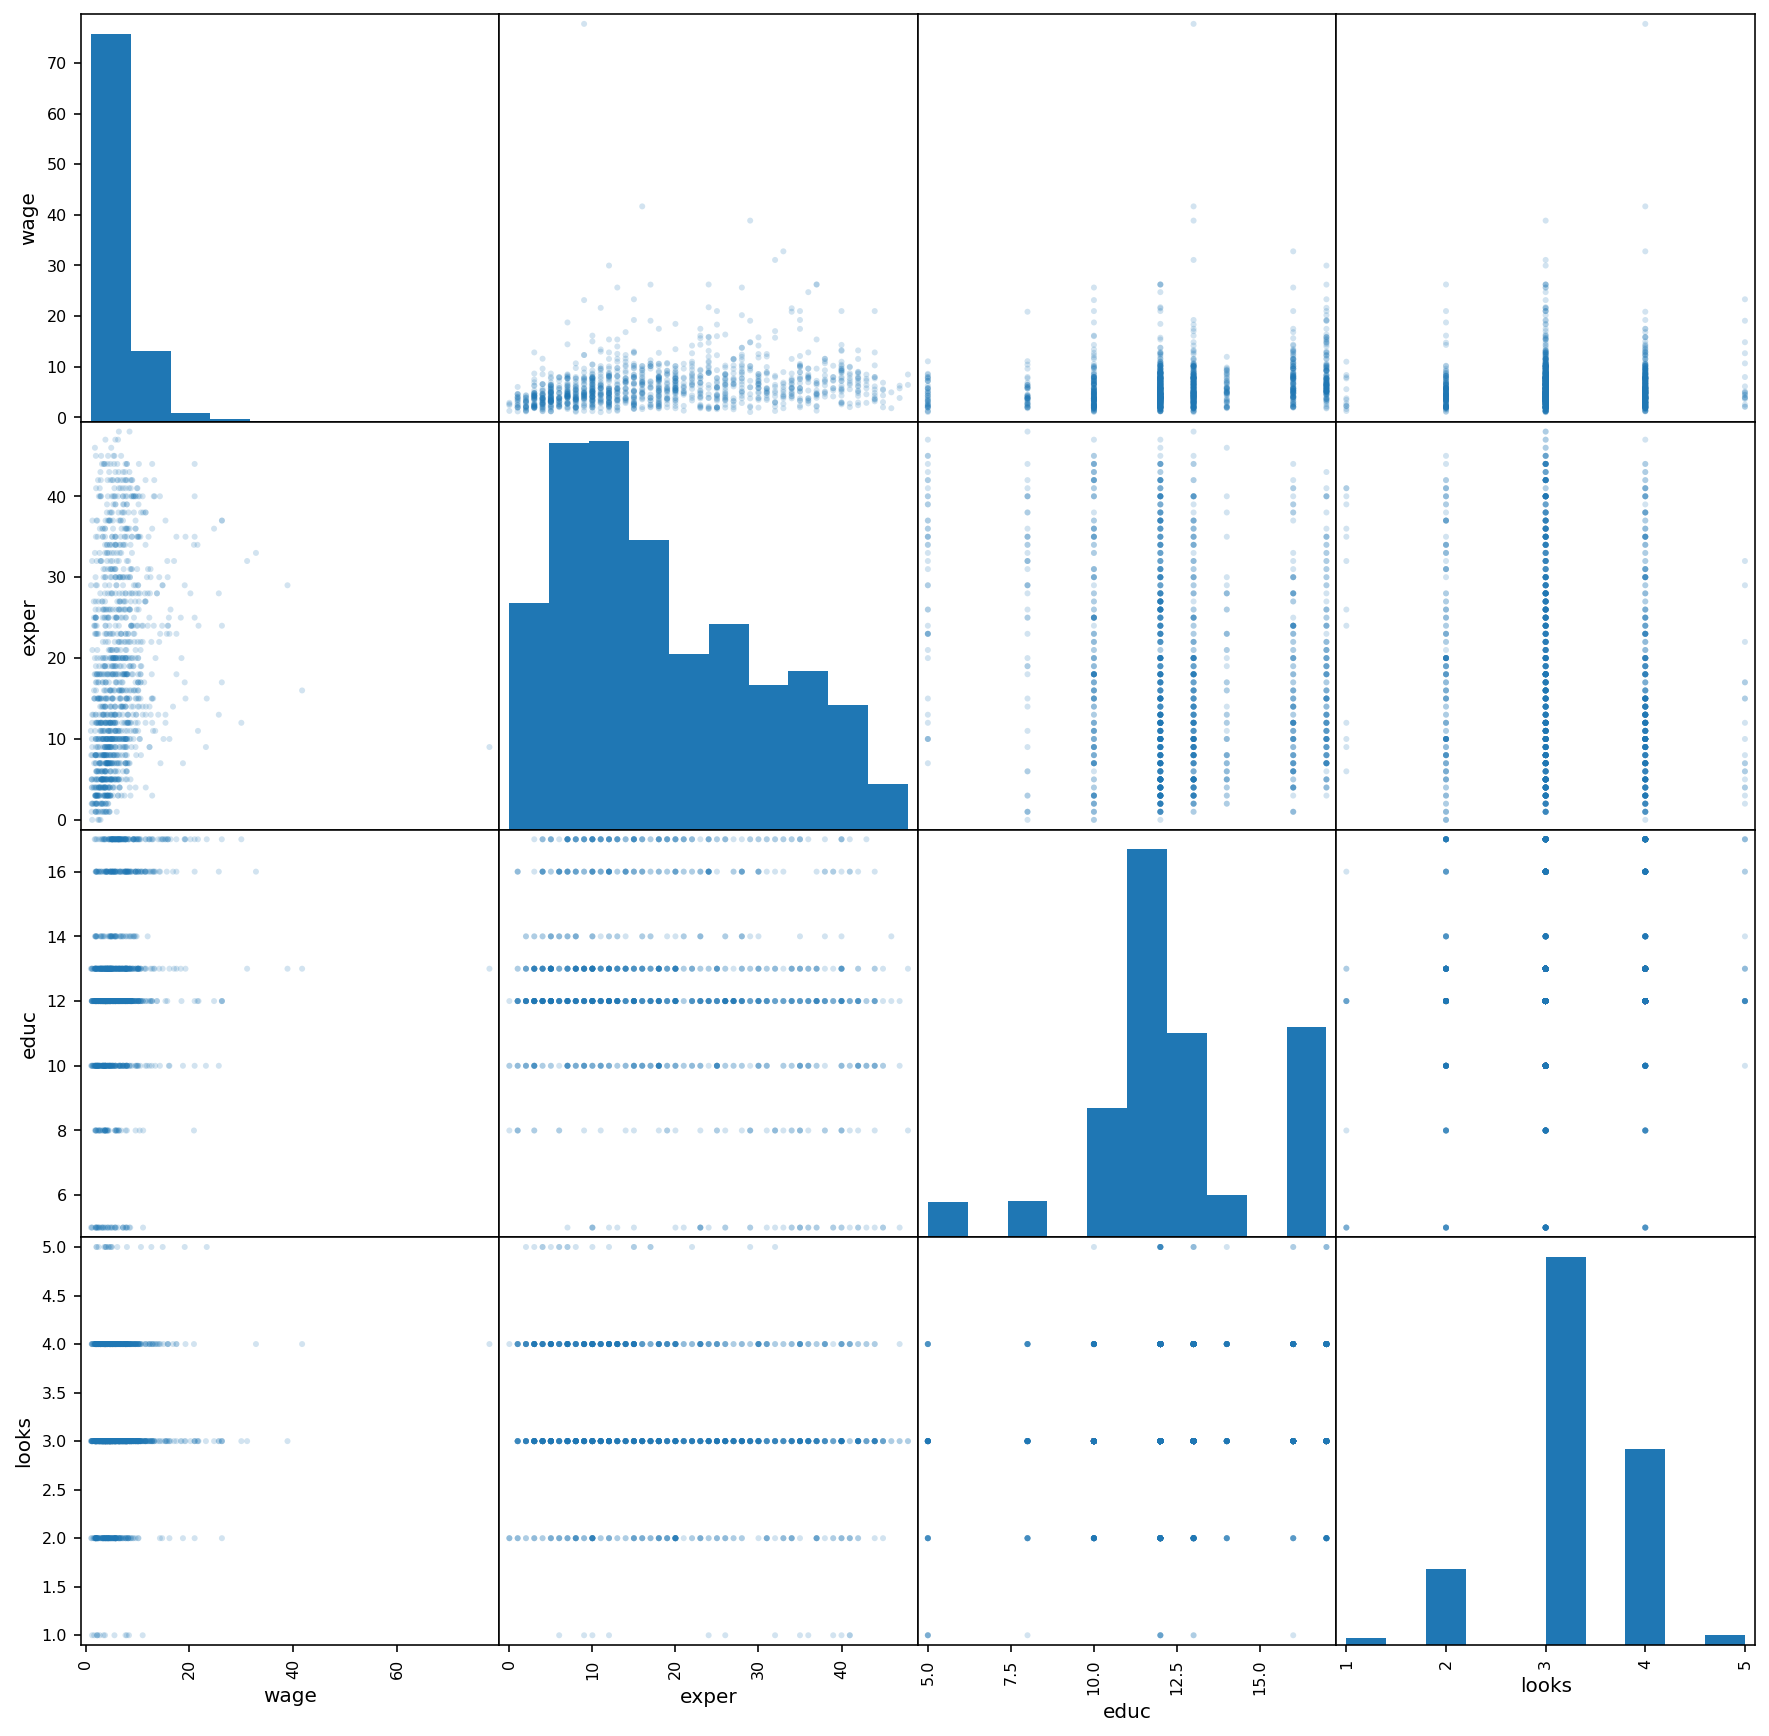

In [35]:
pd.plotting.scatter_matrix(raw[['wage', 'exper', 'educ', 'looks']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

 Что мы здесь сразу видим? Ну что признак образования достаточно дискретный, то есть есть достаточно немного уровней, которые он может принимать. Это логично, поскольку это количество лет, которые опрошенный наш получал образование, ну оно не может варьироваться абсолютно произвольно. Видно, что распределение уровня заработных плат достаточно скошенное. Наверное, с этим надо будет что‐то сделать. Кроме того, на этом графике с уровнем привлекательности видно, что у нас довольно много испытуемых со средним уровнем привлекательности 3, и достаточно мало испытуемых с уровнем привлекательности 1 и 5, то есть привлекательности намного выше среднего и намного ниже среднего. По всем остальным признакам категориальным давайте оценим сбалансированность выборки. Просто посчитаем количество раз, которое каждый из уровней вот этих всех категориальных факторов встречается в выборке. Это делается для того, чтобы, например, убедиться, что в нашей выборке не три человека, которые состоят в профсоюзе, из 1260. Потому что, если это так, то вряд ли наша регрессия может на такой признак правильно и хорошо настроиться. И может быть, лучше его вообще удалить.

Оценим сбалансированность выборки по категориальным признакам:

In [36]:
print (raw.union.value_counts())
print (raw.goodhlth.value_counts())
print (raw.black.value_counts())
print (raw.female.value_counts())
print (raw.married.value_counts())
print (raw.service.value_counts())

0    917
1    343
Name: union, dtype: int64
1    1176
0      84
Name: goodhlth, dtype: int64
0    1167
1      93
Name: black, dtype: int64
0    824
1    436
Name: female, dtype: int64
1    871
0    389
Name: married, dtype: int64
0    915
1    345
Name: service, dtype: int64


У каждого признака все значения встречаются достаточно много раз, так что всё в порядке.

 Ну мы видим, что здесь это не так, здесь по каждому из признаков — членство в профсоюзе, здоровье, цвет кожи, пол, семейное положение, работа в сфере обслуживания, по каждой есть достаточно много объектов на каждом уровне фактора. Прежде чем строить регрессию, давайте немного предобработаем данные.

## Предобработка

In [37]:
data = raw

Посмотрим на распределение целевого признака — уровня заработной платы: 

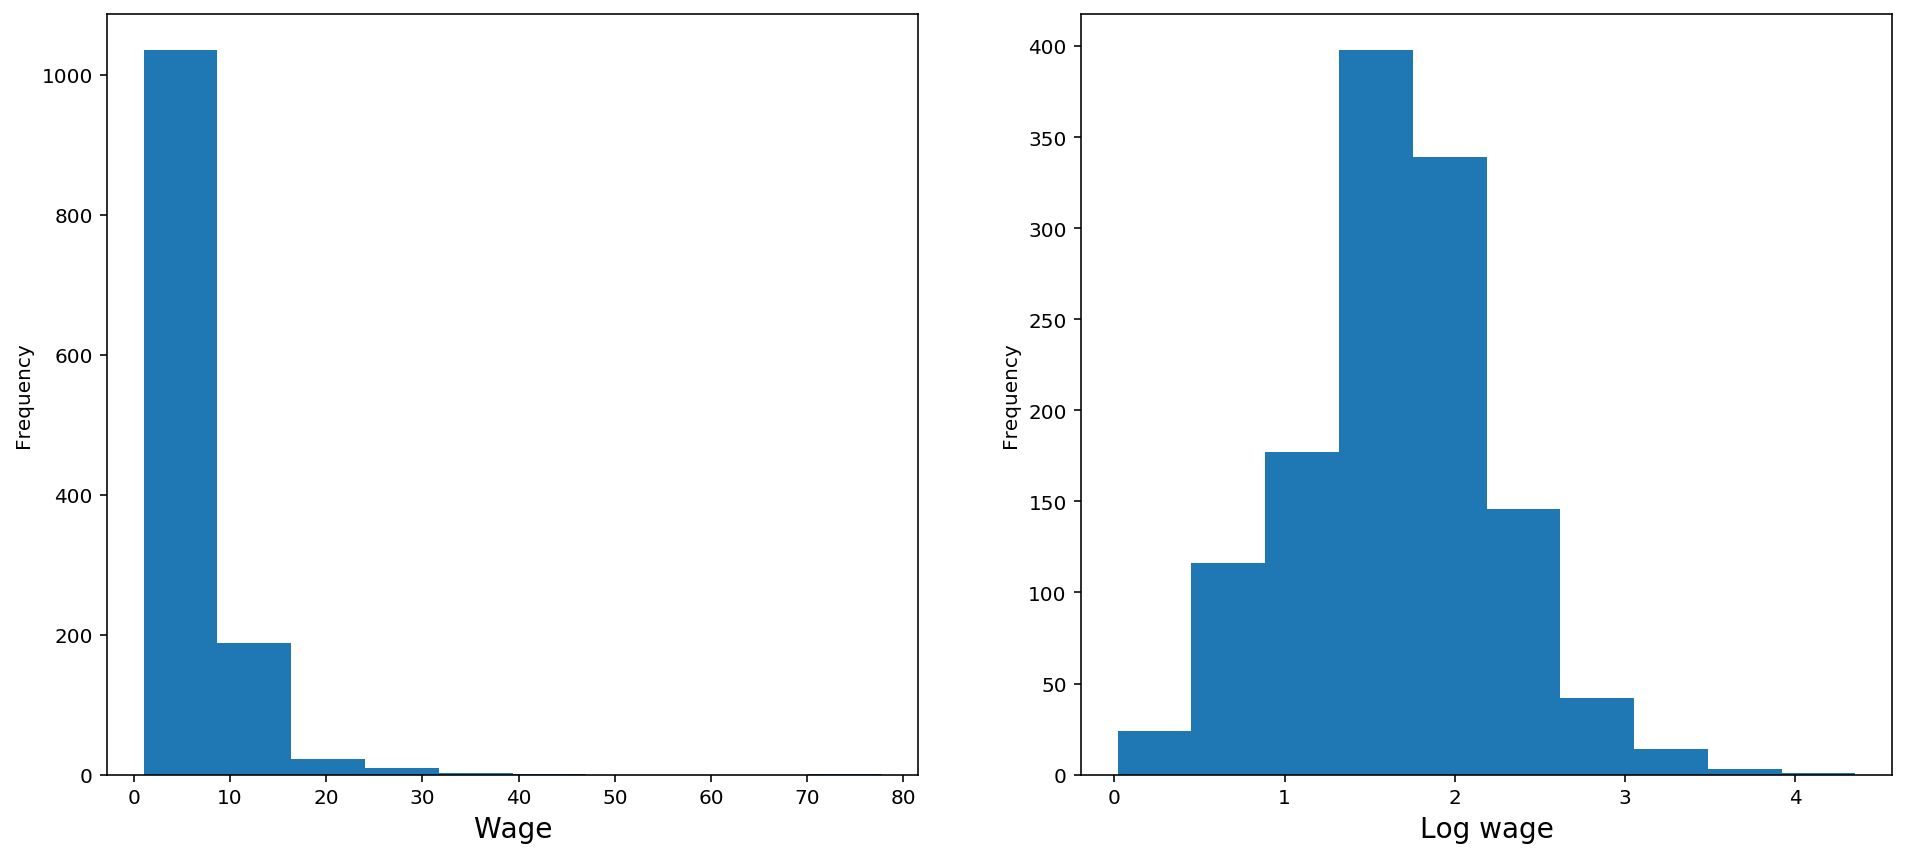

In [38]:
plt.figure(figsize(16,7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('Wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14)
pylab.show()

 Посмотрим ещё раз на распределение нашего целевого признака — уровня заработной платы в час. На левом графике сам уровень заработной платы, на правом — он же, но в логарифмической шкале. Что мы здесь видим важного? Во‐первых, вот на левой гистограмме видно, что есть достаточно немного наблюдений, далеко отстоящих от всей выборки, с большим значением уровня заработной платы. На самом деле, это всего лишь один человек. Один человек в нашей выборке получает 77,72 доллара в час, а остальные все — меньше 45. Вот этого одного человека лучше удалить, потому что регрессия на него перенастроится, и это наблюдение какое‐то достаточно нетипичное. Убираем его.

Один человек в выборке получает 77.72 доллара в час, остальные — меньше 45 долларов; удалим этого человека, чтобы регрессия на него не перенастроилась.

In [39]:
data = data[data['wage'] < 77]

Посмотрим на распределение оценок привлекательности: 

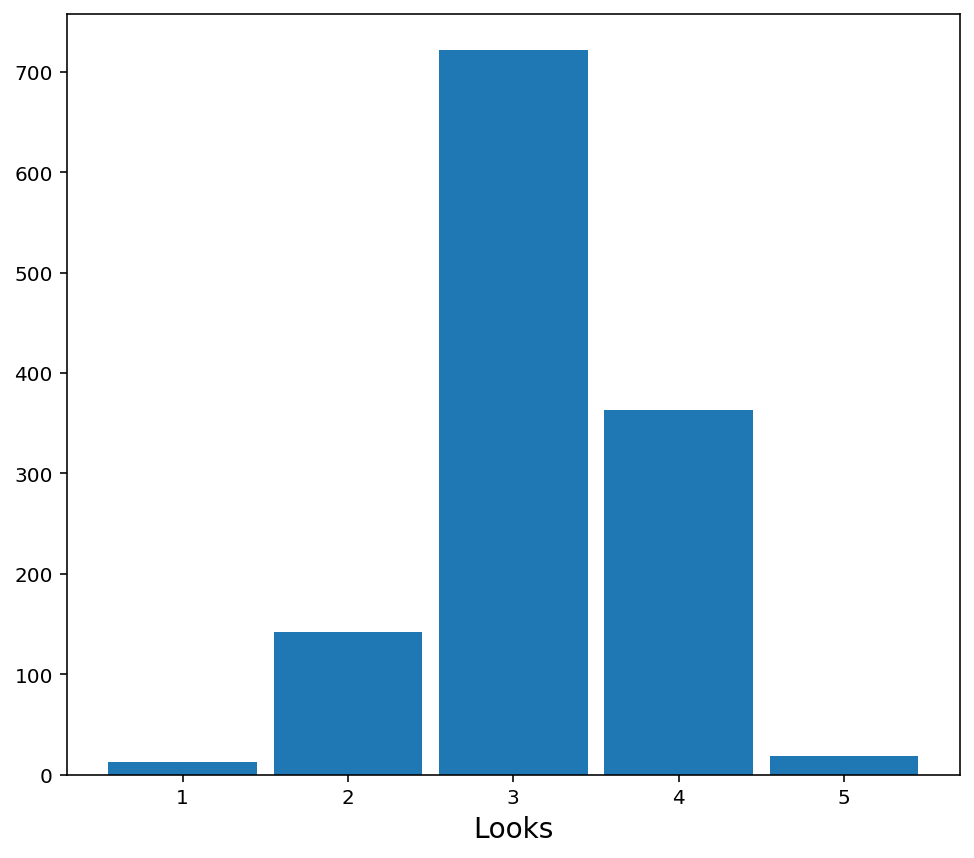

In [40]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Looks', fontsize=14)
pylab.show()

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:

In [41]:
data.loc[:,'belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data.loc[:,'aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)
data

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1255,1.61,25,0,1,1,1,0,1,12,0,0
1256,1.68,4,0,1,0,1,1,1,12,1,0
1257,3.29,35,0,1,1,1,0,1,12,0,0
1258,2.31,15,0,1,1,1,1,1,10,0,0


 Ну вот мы снова видим, что у нас здесь довольно мало людей с привлекательностью 1 и 5. Мы можем поступить так. Давайте создадим вместо вот этого числового признака looks два бинарных признака. Один из них, выше среднего, будет равен 1, если привлекательность у опрошенного выше среднего. Второй, ниже среднего, будет равен 1, если привлекательность опрошенного ниже среднего, то есть 3. Таким образом, у нас появляется два новых признака, именно влияние их на уровень заработной платы мы будем исследовать, а исходный признак looks, ну пожалуй, можно удалить.

Данные теперь:

In [42]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


 Вот так теперь выглядят данные, которые мы будем анализировать. Давайте начнем строить на них линейную регрессию. Давайте построим обычную линейную регрессионную модель по всем имеющимся у нас признакам и начнём её постепенно модифицировать, анализируя по ходу. Строить эту линейную регрессию мы будем с помощью функции OLS из пакета statsmodels. Мы будем использовать именно его, потому что эта функция позволяет автоматически рассчитывать большое количество разных диагностических метрик, которые полезны для понимания того, как именно устроена модель, которую вы построили. На вход эта функция принимает вот такую формулу: здесь слева стоит название признака, который в нашей регрессии является откликом. А справа через «+» перечислены все признаки, которые мы хотим использовать при прогнозировании нашего отклика. Хорошо. Давайте посмотрим на диагностику этой вот простой, обычной линейной модели.

## Построение модели

### Простейшая модель

Построим линейную модель по всем признакам.

In [43]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + belowavg + aboveavg', 
             data=data)
fitted = m1.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           1.42e-75
Time:                        15:18:09   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4

 Что здесь печатается полезного? Во‐первых, мы видим R². Коэффициент детерминации этой модели не слишком высок — 0,26 всего лишь. Здесь есть статистика и достигаемый уровень значимости критерия Фишера при проверке гипотезы о том, что модель вообще имеет какой‐то смыл. То есть о том, что все коэффициенты при всех признаках модели, на самом деле, можно приравнять к 0 и оставить одну только константу. Вот эта гипотеза, как мы видим, по достигаемому уровню значимости отвергается достаточно уверенно. То есть как бы наша модель ни мало дисперсий исходного отклика описывала, она намного лучше, чем ничего. Ниже у нас таблица, в которой выписаны все коэффициенты получившейся регрессии. В первом столбце сами коэффициенты, во втором — их стандартные отклонения, в третьем — значения статистики t-критерия Стьюдента при проверке гипотезы о том, что этот коэффициент равен 0. В следующем столбце — достигаемый уровень значимости, соответствующий этим статистикам, ну и далее — доверительный интервал для коэффициентов. Чтобы понять, насколько наша модель хороша, давайте посмотрим на распределение её остатков. Слева – ку-ку график, а справа — гистограммы этого распределения. 

Посмотрим на распределение остатков:

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


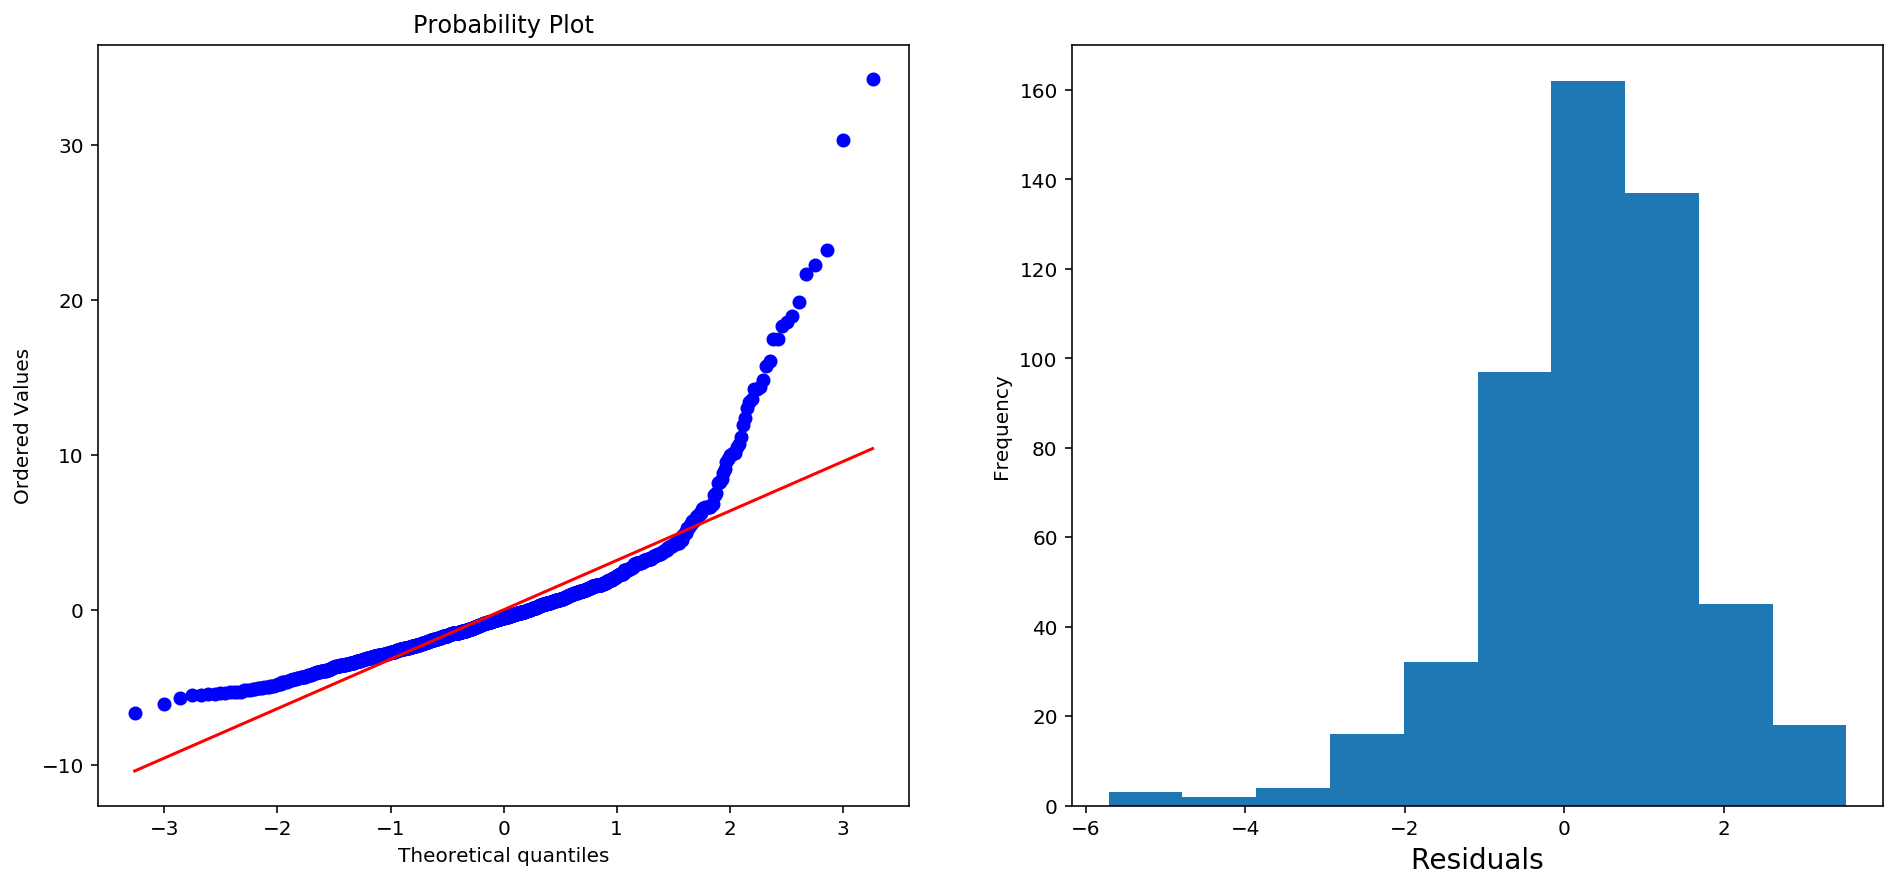

In [44]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Что же мы здесь видим? Мы видим, что точки на ку-ку графике лежат довольно сильно не на прямой. Распределение остатков не очень‐то похоже на нормальное. Это проблема, потому что мы хотим использовать значения достигаемых уровней значимости критериев Стьюдента и Фишера, и на их основании как‐то модель модифицировать, отбирать значимые признаки. Если предположения о нормальности ошибки в модели не выполняются, то критерии Стьюдента и Фишера перестают работать. С этим можно что‐то сделать. Например, можно поступить так. Мы видели, что наш отклик тоже имеет какое‐то одностороннее распределение, то есть у него такой достаточно длинный правый хвост, и оно обрезано в нуле с левой стороны. Остатки точно так же имеют скошенное распределение. В таких случаях часто помогает логарифмирование, мы просто будем делать регрессию не исходного признака, а его логарифма. Ну давайте это попробуем. Повторим всё то же самое, только на этот раз будем строить регрессию не на сам признак, а на его натуральный логарифм. Давайте посмотрим на получившуюся модель. 

Оно скошенное, как и исходный признак. В таких ситуациях часто помогает перейти от регрессии исходного признака к регрессии его логарифма.

### Логарифмируем отклик

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          1.18e-123
Time:                        15:18:10   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


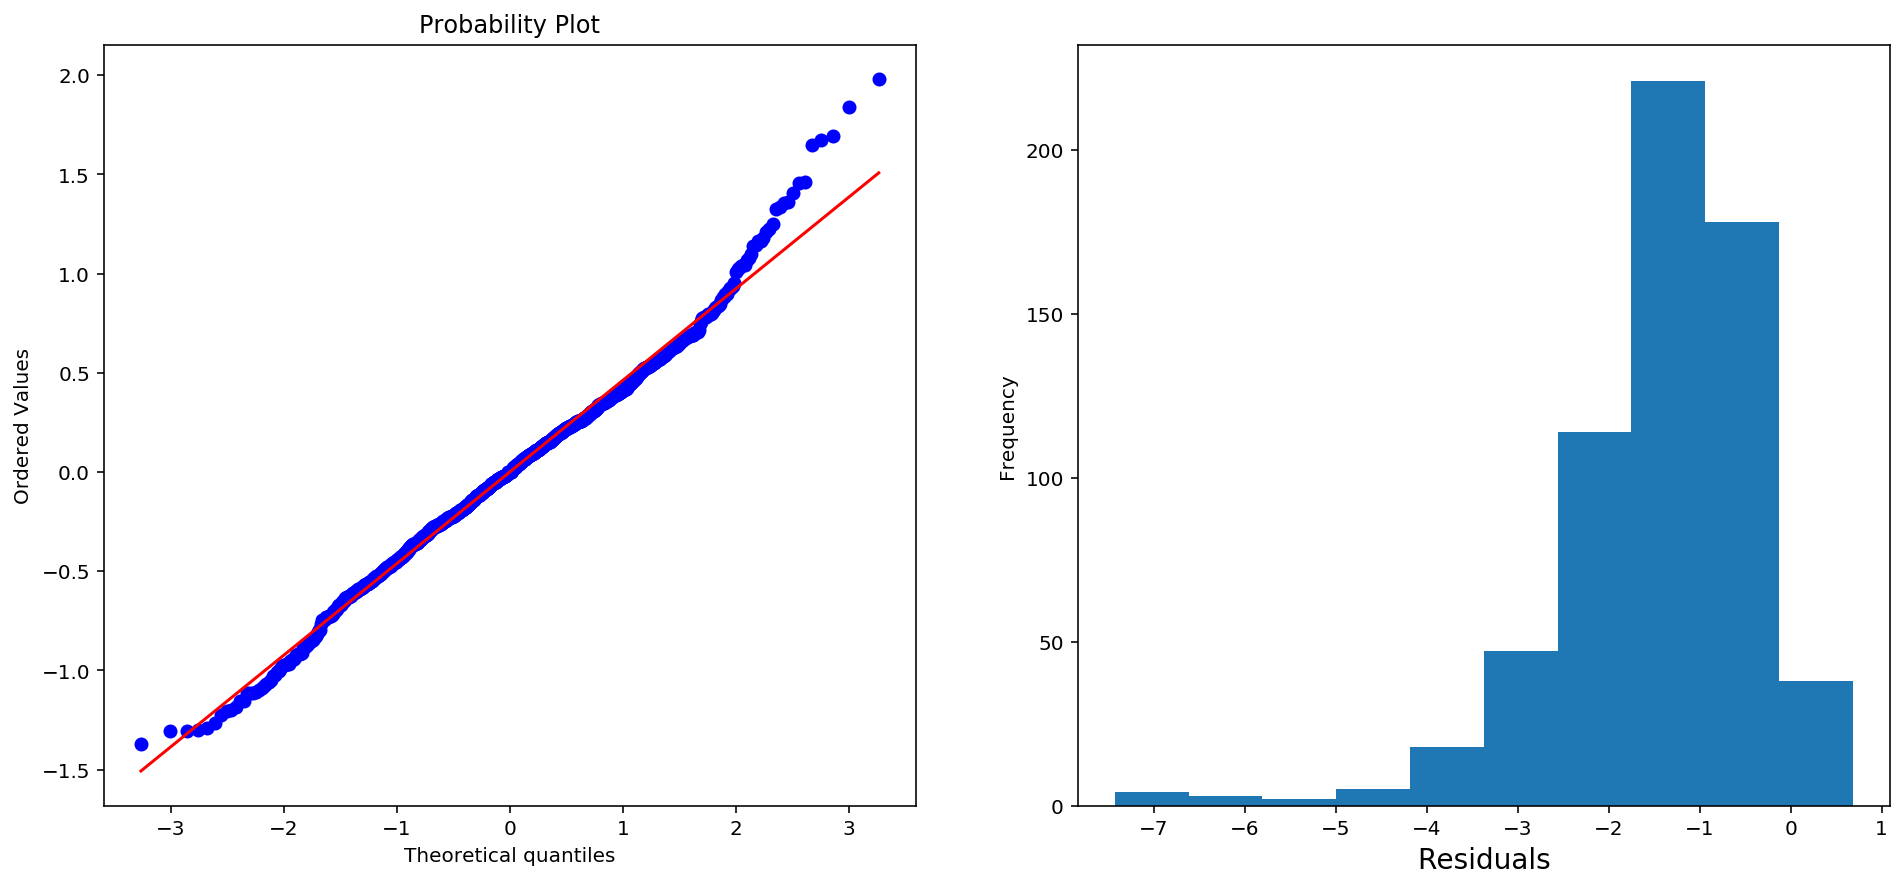

In [45]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + belowavg + aboveavg', data=data)
fitted = m2.fit()
print (fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Во‐первых, у неё довольно сильно вырос R², коэффициент детерминации теперь 0,38. Мы видим, что распределение остатков, кажется, стало больше похоже на нормальное: на ку-ку графике точки лежат уже более‐менее на прямой. Всё ещё сохраняется небольшой левый хвост, который мы видим на распределении остатков на гистограмме, но он стал существенно меньше, чем в предыдущем примере. Давайте теперь посмотрим, как остатки меняются в зависимости от разных значений непрерывных признаков, которые стоят в регрессии. Непрерывных признаков у нас всего два: это опыт работы и образование. И вот по ним графики.

Теперь стало лучше. Посмотрим теперь на зависимость остатков от непрерывных признаков:

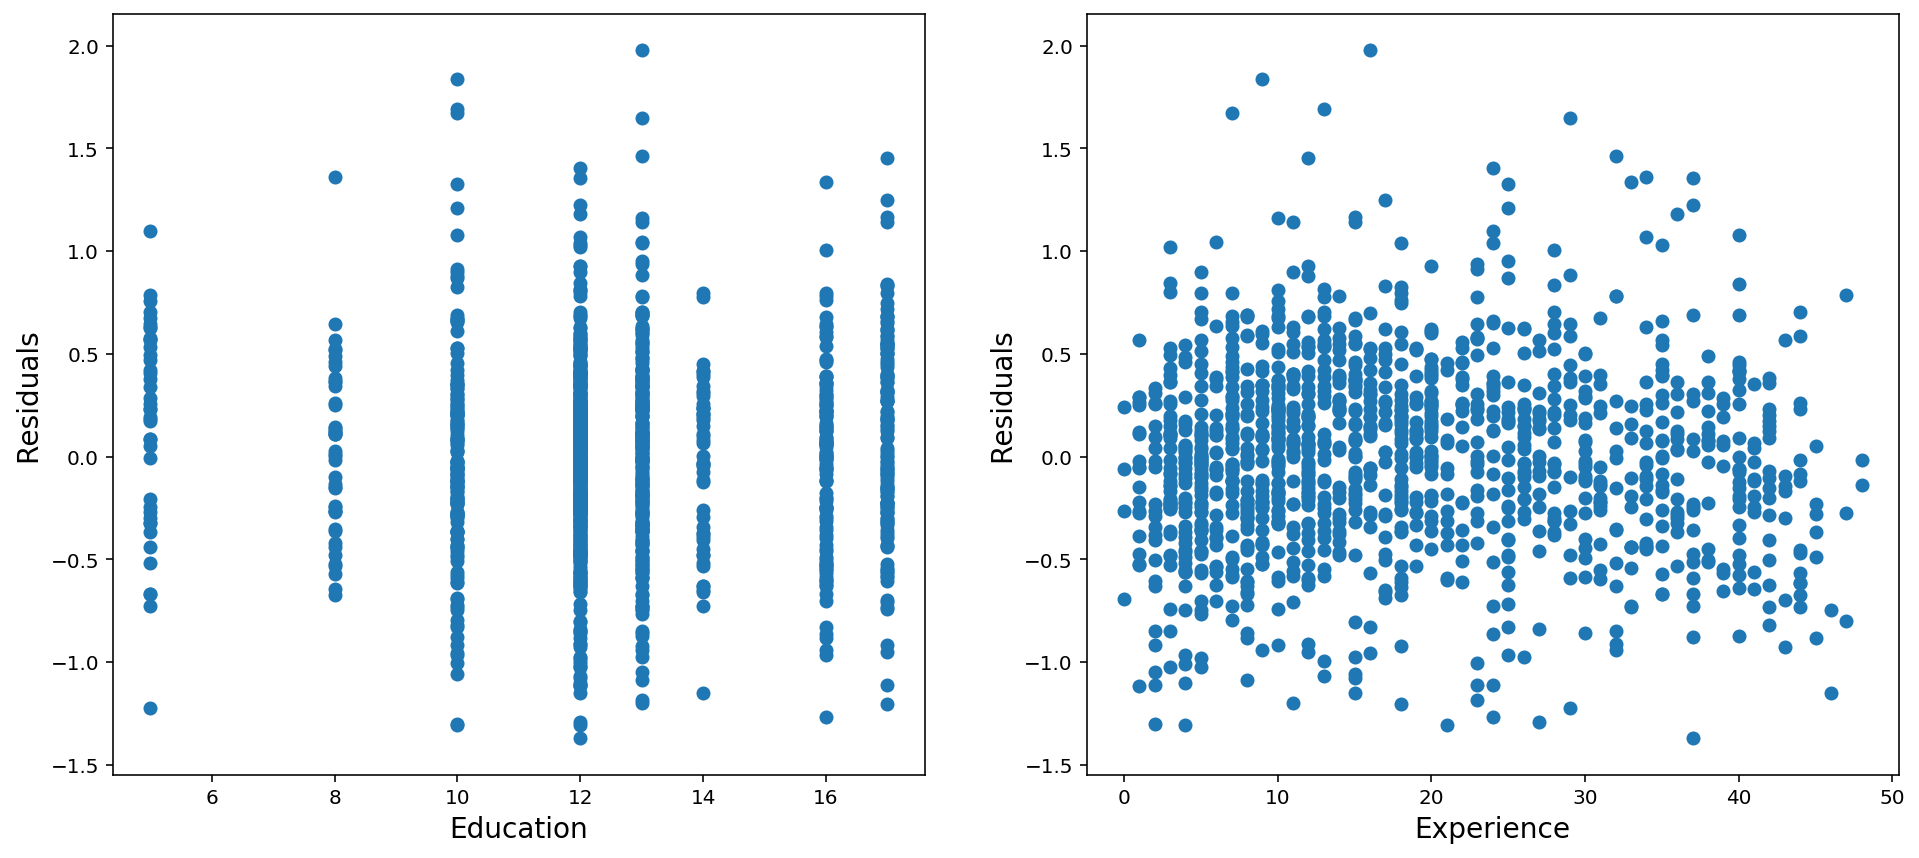

In [46]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

 На графике для опыта работы мы видим интересный эффект: кажется, что точки на этом графике лежат вот на такой дуге. Это означает, что в наших остатках есть какая‐то квадратичная зависимости от признака «опыт работы». Когда мы видим, что что‐то такое происходит, мы можем просто в нашу линейную регрессию подставить дополнительно какие‐то преобразования от наших исходных признаков. Например, в данном случае мы можем подставить квадрат «опыта работы». Давайте это сделаем. Добавляем. Единственное, что при этом меняется, это вот в нашей формуле для модели, которая строит линейную регрессию, добавляется ещё одно слагаемое — вот это. Посмотрим на результат.

На втором графике видна квадратичная зависимость остатков от опыта работы. Попробуем добавить к признакам квадрат опыта работы, чтобы учесть этот эффект.

### Добавляем квадрат опыта работы

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          3.19e-131
Time:                        15:18:12   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


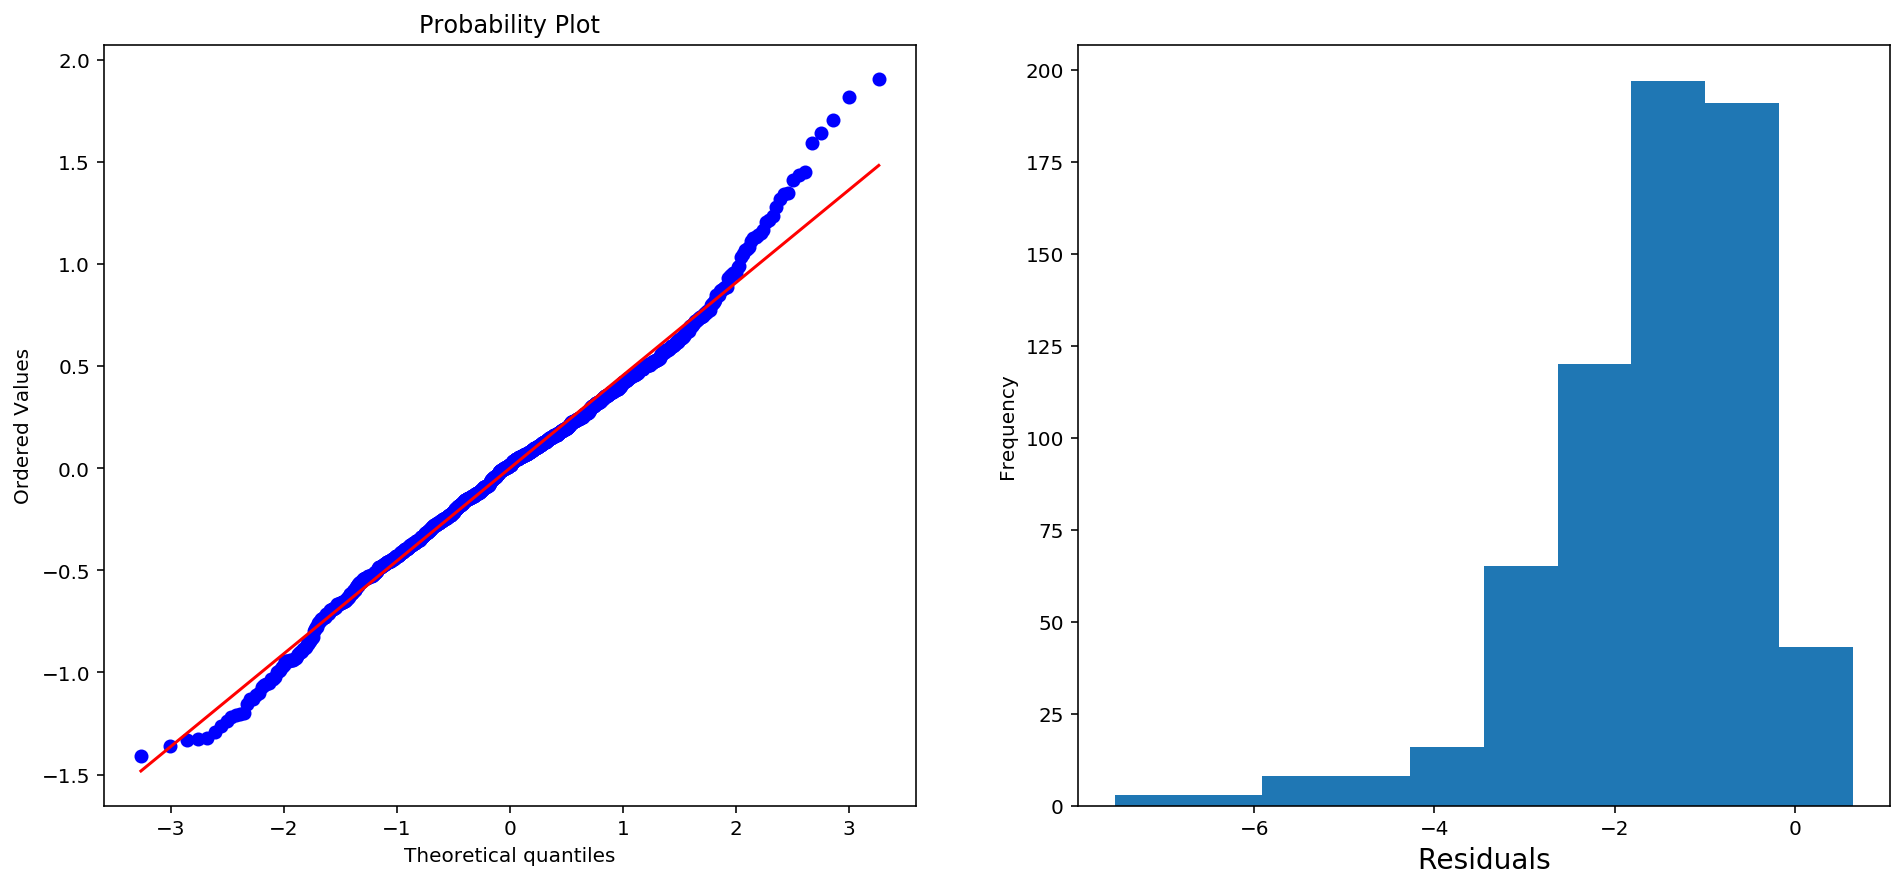

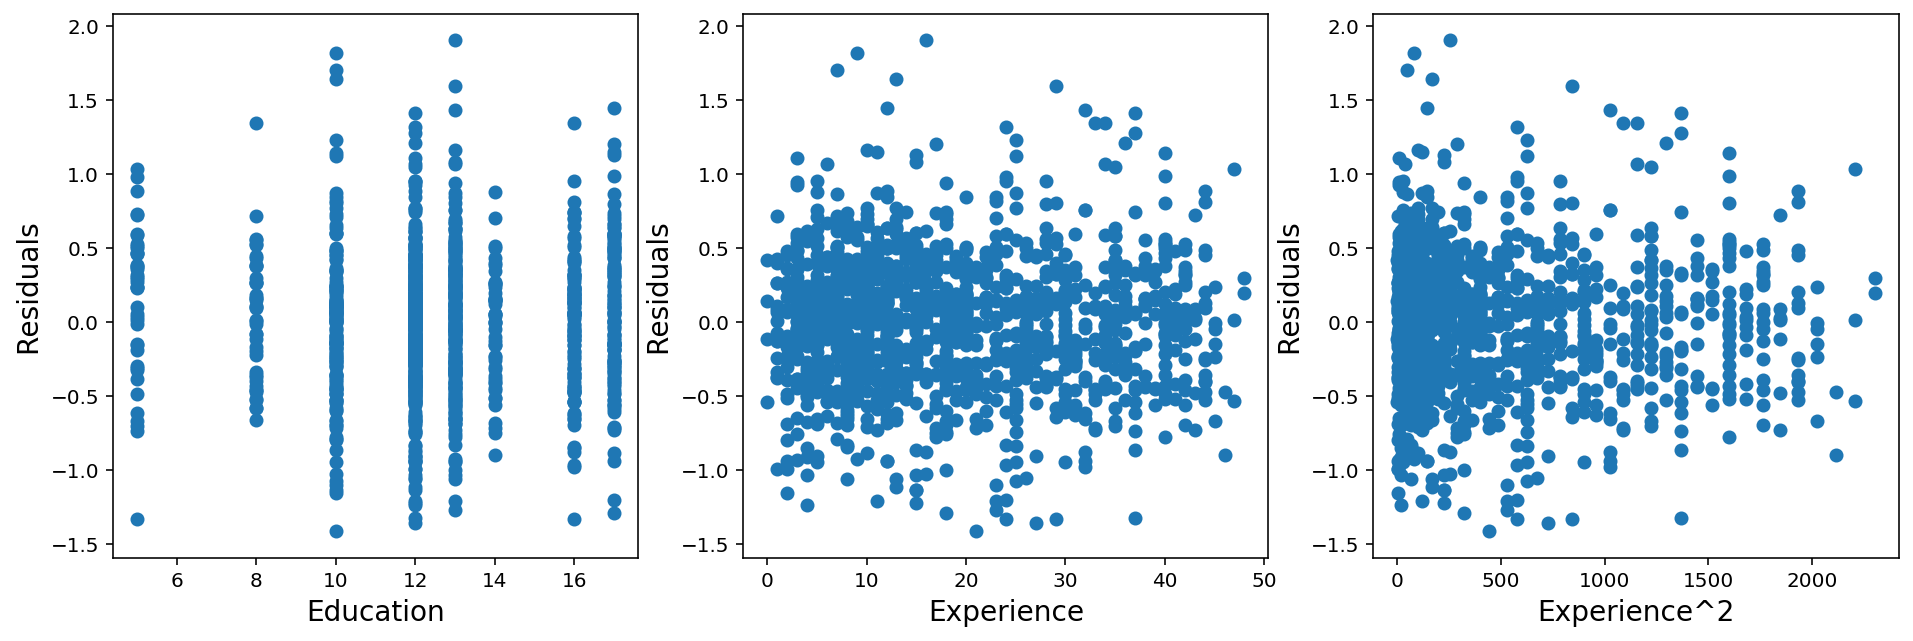

In [47]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m3.fit()
print (fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.figure(figsize(16,5))
plt.subplot(131)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['exper']**2,fitted.resid)
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

 R² ещё увеличился. Теперь нам удаётся объяснить 40 % дисперсии исходного признака. Распределение остатков не слишком изменилось, но, по крайней мере, теперь в остатках больше нет зависимости от квадрата опыта работы: как мы видим вот по этом графикам, она полностью ушла. Прежде чем переходить к интерпретации достигаемых уровней значимости и критерия Стьюдента для всех признаков и делать, таким образом, отбор признаков, давайте убедимся, что выполняется предположение о гомоскедастичности, без которого критерий Стьюдента будет работать непредсказуемо плохо. Используем критерий Бройша – Пагана, вот эта функция возвращает его достигаемый уровень значимости,

Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок:

In [48]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000004


 мы видим, что он очень маленький. То есть гипотеза о гомоскедастичности остатков отвергается. Что можно в этом случае делать? Оказывается, можно сделать на это специальную поправку, которая называется поправка Уайта. Она пересчитывает значения дисперсии коэффициентов регрессии с учетом того, что в модели присутствует гетероскедастичность. Казалось бы, почему не использовать этот метод всегда, если он устойчив в гетероскедастичности? Ну дело в том, что он просто менее точен, если на самом деле гетероскедастичности нет. Поэтому прежде чем его включать, лучше проверять, действительно ли в этом есть какая-то необходимость. Давайте сделаем эту поправку Уайта. Это очень просто, делается вот так. Когда вы делаете fit, в качестве параметра cov_type вы указываете HC1, например. HC — это гетероскедастичность, а 1 — это номер типа поправки Уайта. Их есть, если я не ошибаюсь, 4 или 5. Ну можно всегда использовать номер 1, например, потому что никто не знает, какая из них равномерно лучше. Давайте посмотрим, что от этого изменилось. 

Ошибки гетероскедастичны, значит, значимость признаков может определяться неверно. Сделаем поправку Уайта:

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          4.23e-146
Time:                        15:18:14   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


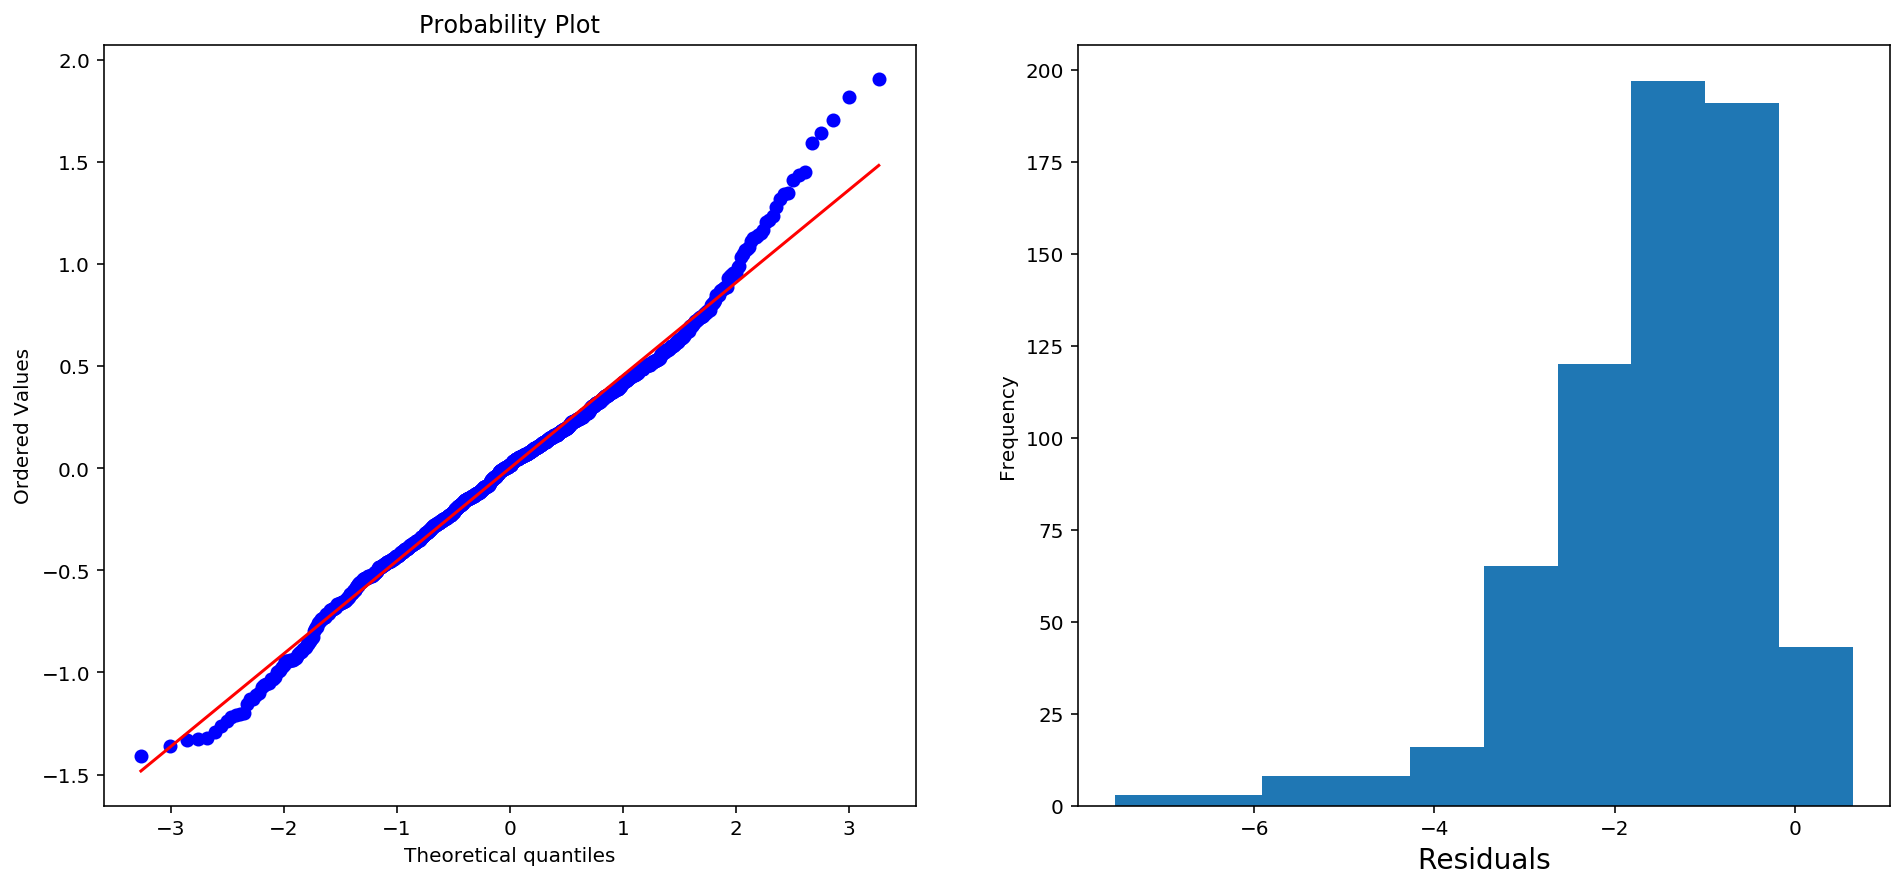

In [49]:
m4 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m4.fit(cov_type='HC1')
print (fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

На каком-то верхнем, самом грубом уровне регрессионная модель осталась практически такая же, потому что R² у нее не изменился, и достигаемый уровень значимости критерия Фишера все такой же. Это неудивительно, потому что от использования поправки Уайта на гетероскедастичность, меняются у нас только оценки дисперсий наших коэффициентов регрессии. И если мы сравним вот эту таблицу с предыдущей, мы увидим, что они действительно немного отличаются. Это значит, что наша модель в каком-то смысле устойчива к гетероскедастичности, или гетероскедастичность в данных была не слишком сильной, потому что когда мы на нее скорректировали, мы получили практически то же самое. Ну небольшие отличия все-таки есть, достигаемые уровни значимости немного поменялись, и теперь, когда мы уверены в том, что их можно правильно интерпретировать, потому что критерии, которые их считают, действительно работают, предположения для них выполняются, давайте сделаем на их основе отбор признаков. Что мы здесь видим? Какие признаки у нас незначимые? Это признаки: состояние здоровья, раса, семейное положение и признак привлекательность выше среднего. Первые три мы удалим, а самый последний оставим. Несмотря на то, что он в модели незначим, мы все равно его будем там держать, потому что мы хотим в самом конце интерпретировать коэффициент перед ним. Ну неважно в таких случаях, что признак незначим. Давайте построим следующую регрессионную модель, удалив незначимые признаки: цвет кожи, здоровье и семейное положение. Можно ожидать, что в целом качество нашей модели немного ухудшится, поскольку какие бы признаки бессмысленные ни были, когда мы их просто удаляем, у нас R², например, всегда понижается.

### Удаляем незначимые признаки

В предыдущей модели незначимы: цвет кожи, здоровье, семейное положение. Удалим их. Индикатор привлекательности выше среднего тоже незначим, но удалять его не будем, потому что это одна из переменных, по которым на нужно в конце ответить на вопрос.

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Tue, 21 Apr 2020   Prob (F-statistic):          6.49e-150
Time:                        15:18:14   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


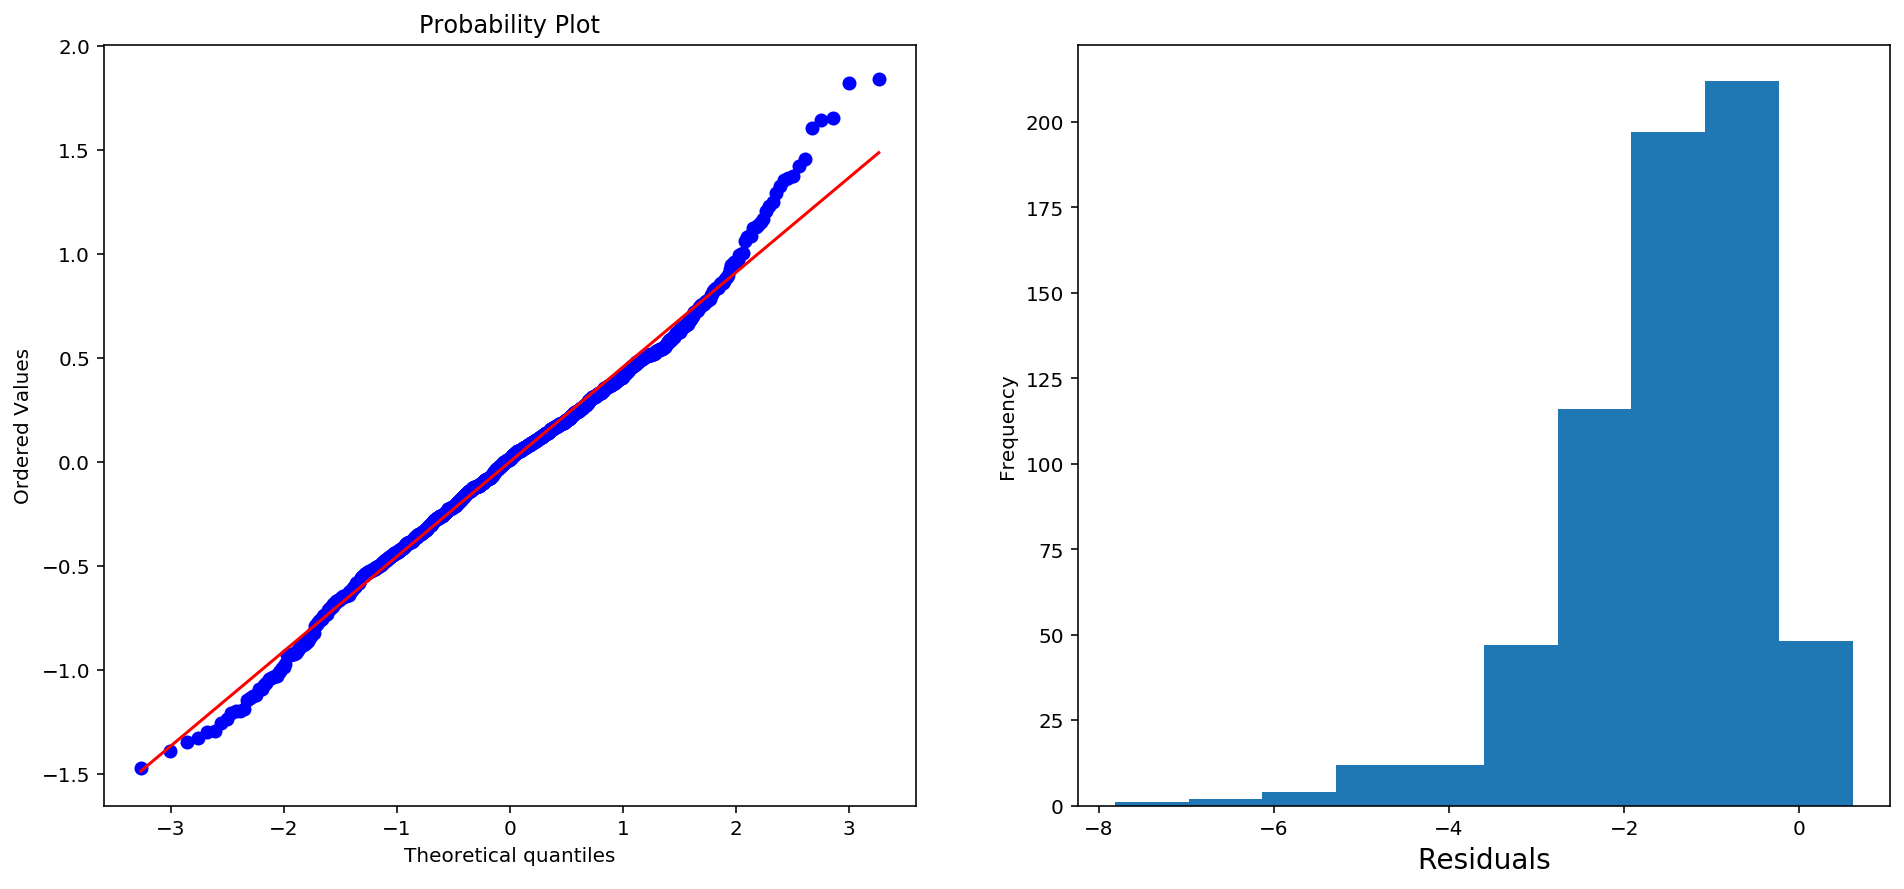

In [50]:
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female + service + educ +'\
                            'belowavg + aboveavg', data=data)
fitted = m5.fit(cov_type='HC1')
print (fitted.summary())

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

 Но видно, что здесь R² уменьшился совсем немножко, всего на 0,003, так что, видимо, эти признаки действительно мало что добавляли в нашу модель. Давайте посмотрим теперь на значимость признаков. Ну и мы видим, что достигаемые уровни значимости для всех из них, кроме опять же привлекательности выше среднего, очень маленькие. То есть признаки действительно, по всей видимости, хорошие, то есть Y они помогают предсказывать. Давайте теперь убедимся с помощью критерия Фишера, что удаление сразу трех незначимых по Стьюденту признаков не привело к значимому ухудшению модели. Критерий Фишера в данном случае вызывается вот такой функцией. Это compare_f_test, и здесь вы в качестве первой модели указываете модель бо́льшую, а в качестве второй, вот здесь, в скобках — модель, которая меньше и вложена в эту первую бо́льшую. 

Посмотрим, не стала ли модель от удаления трёх признаков значимо хуже, с помощью критерия Фишера:

In [51]:
print ("F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit()))

F=1.611478, p=0.184911, k1=3.000000


Мы видим, что достигаемый уровень значимости здесь 0,18, то есть мы не можем отвергнуть гипотезу о том, что признаки, которые мы выбросили, были действительно не нужны. Давайте сделаем еще одну диагностику: посчитаем влиятельность всех наблюдений в нашей выборке. Дело в том, что регрессия склонна перенастраиваться на нетипичные наблюдения. Если у нас есть какие-то точки, которые лежат далеко от основного облака, из-за того, что в регрессии минимизируются квадраты отклонений, если мы проведем регрессионную прямую через основное облако, вот эта далекая точка даст огромный вклад в минимизируемую нами ошибку, в среднеквадратичное отклонение. Поэтому регрессионная прямая будет стремиться пройти как можно ближе вот к таким далеко лежащим точкам. В результате, на большей части точек мы получим плохое качество предсказаний. Для того чтобы убедиться, что таких точек в нашей выборке нет, построим следующий график. На этом графике по горизонтальной оси отложены квадраты остатков, то есть квадрат ошибки предсказания на каждой точке, а по вертикальной оси отложена влиятельность наблюдений. Вот чем она больше, тем сильнее это наблюдение влияет на регрессионное уравнение. Как эта штука вычисляется? Очень просто. Мы просто берем нашу исходную выборку и по очереди из нее удаляем одну точку, одно наблюдение. Перестраиваем регрессионное уравнение по вот этой вот выборке без одной точки и смотрим, насколько оно похоже на регрессионное уравнение, построенное по полной выборке. Вот разница между этими двумя уравнениями как раз и определяет влиятельность точки.

Не стала.

Проверим, нет ли наблюдений, которые слишком сильно влияют на регрессионное уравнение:

<Figure size 576x504 with 0 Axes>

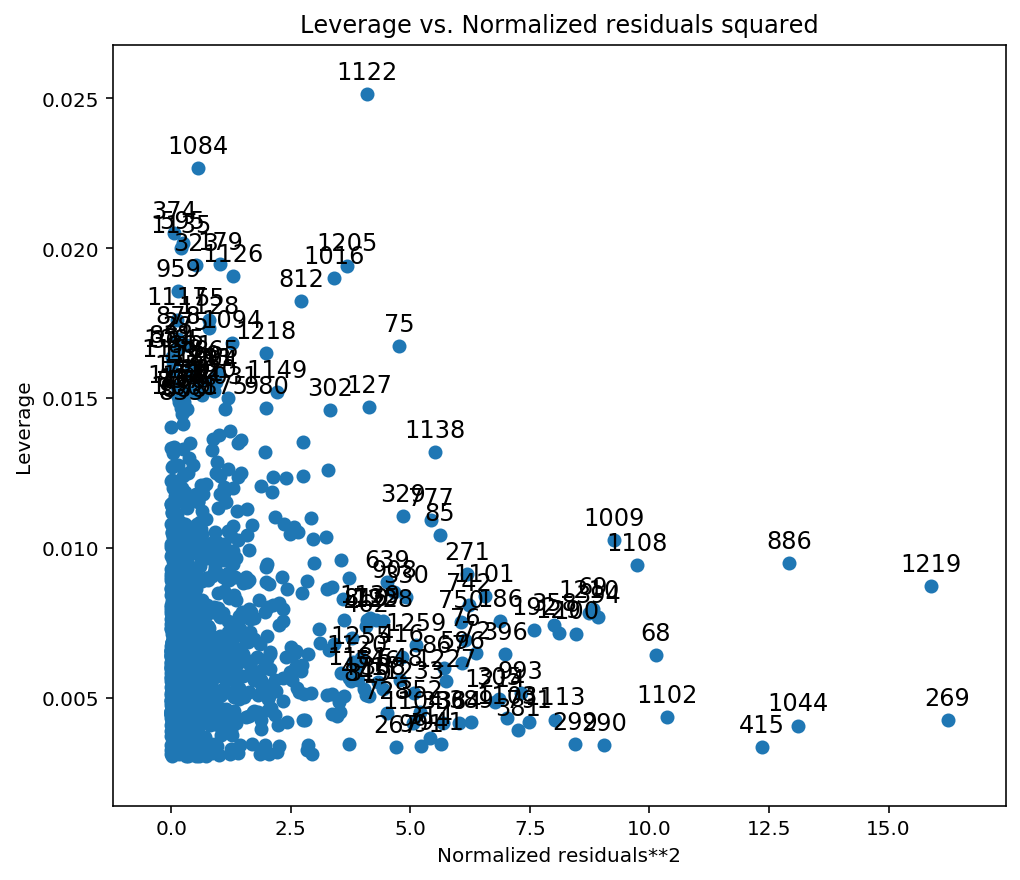

In [52]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

 Что мы видим на этом графике? Мы видим, что у нас нет точек, которые лежат как-то экстремально далеко от основного облака по влиятельности. Ну вот точка с самой большой влиятельностью — это точка 1122. Точка, на который мы сильнее всего ошибаемся — это точка 269. Давайте на них посмотрим и подумаем, действительно ли с ними что-то не так. 

In [53]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
1122,6.25,47,0,0,1,1,1,0,5,0,1


Первая точка с самой большой влиятельностью соответствует темнокожей замужней женщине с небольшим уровнем образования и привлекательностью выше среднего и очень большим опытом работы. Вот, по всей видимости, влиятельность этого наблюдения определяется как раз нетипичностью значения опыта работы на этой точке.

In [54]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
269,41.67,16,0,0,0,0,1,0,13,0,1


 Точка, на которой мы сильнее всего ошибаемся — это женатый белый мужчина, достаточно образованный, с большим опытом работы (но не слишком большим), привлекательностью выше среднего и практически максимальной в нашей выборке заработной платой. По все видимости, для него мы предсказываем заработную плату недостаточно высокой, то есть мы недопредсказываем в этом случае. Но тем не менее, поскольку на графике мы видели, что все точки лежат более-менее плотно, нет каких-то точек экстремально влиятельных, мы можем сказать, что наша модель уже достаточно хороша и на этом остановиться. Давайте теперь сделаем по ней выводы. Наша итоговая модель объясняет 40 % вариаций логарифма нашего отклика. На следующих двух графиках: на первом отложен отклик, то есть заработная плата, а по вертикали — экспонента от наших предсказаний, на втором графике отложен логарифм заработной платы и наши предсказания этого логарифма. 

## Выводы

Итоговая модель объясняет 40% вариации логарифма отклика. 

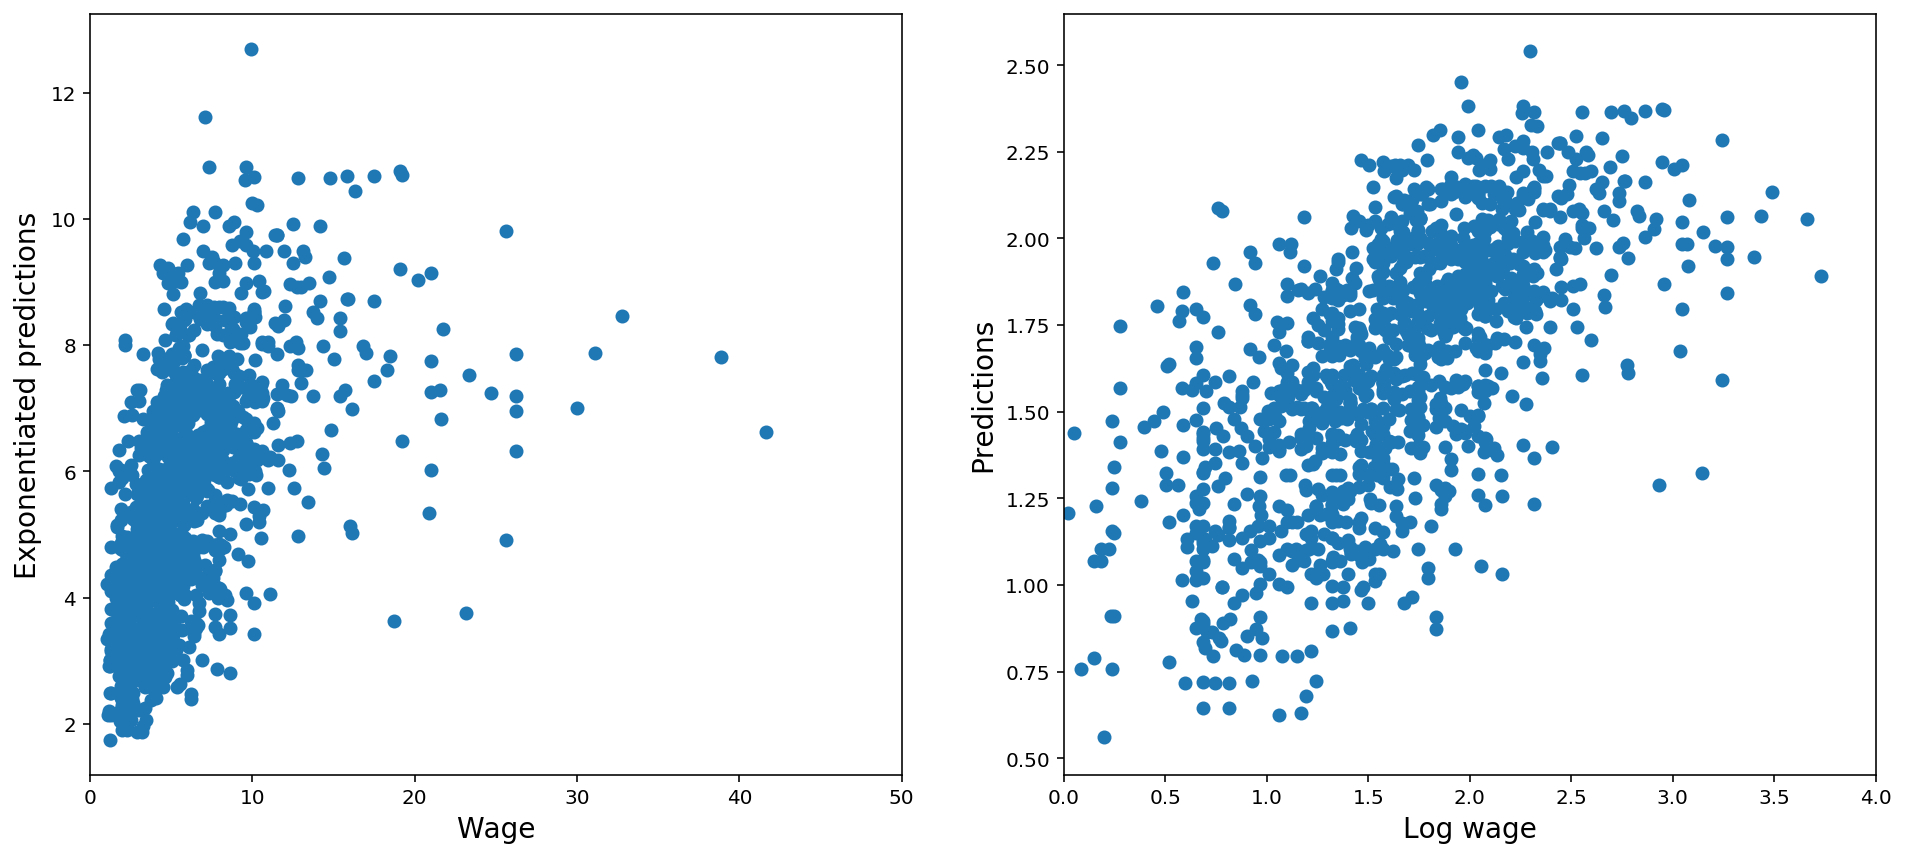

In [55]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['wage'],np.exp(fitted.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
scatter(np.log(data['wage']),fitted.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
pylab.show()

При интересующих нас факторах привлекательности стоят коэффициенты -0.1307 (ниже среднего) и -0.0010 (выше среднего). 

Поскольку регрессия делалась на логарифм отклика, интерпретировать их можно как прирост в процентах. С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают в среднем:

* на 13% меньше, если их привлекательность ниже среднего (p=0.001, 95% доверительный интервал — [5,21]%);
* столько же, если их привлекательность выше среднего (p=0.972, 95% доверительный интервал — [-6,6]%).

Ну мы видим, что на самом деле это облако точек не слишком диагонально. То есть действительно наша модель неидеальна, она объясняет всего лишь 40 % вариаций нашего отклика. Но по всей видимости, эта задача — достаточно сложная. Предсказать уровень заработной платы точно по таким признакам, которые у нас есть, сложно. Поэтому 40 % — это результат достаточно неплохой. На самом деле, нас интересует не вся модель, а только коэффициенты при привлекательности выше среднего и ниже среднего. Давайте на них посмотрим и проанализируем их. При привлекательности ниже среднего стоит коэффициент −0,13. Поскольку это коэффициент в регрессии на логарифм отклика, его можно интерпретировать как прирост в процентах. То есть когда наш признак – привлекательность ниже среднего – меняется с 0 на 1, наш отклик уменьшается на 13 %. Таким образом, выводы, которые можно сделать по построенной регрессионной модели, выглядят следующим образом. Представители генеральной совокупности, из которой взята наша выборка, с учетом рассмотренных нами дополнительных признаков, получают в среднем на 13 % меньше, если их привлекательность ниже среднего. Достигаемый уровень значимости — 0,001. 95% доверительный интервал для вот этого прироста — от 5 до 21 %. Этот доверительный интервал можно взять из диагностики последней построенной нами модели выше. А вот люди с привлекательностью выше среднего получают столько же, сколько и люди со среднем уровнем привлекательности. Достигаемый уровень значимости при проверке значимости этого признака для предсказания нашего отклика очень большой — 0,97. 95% доверительный интервал для изменения среднего уровня заработной платы при повышении привлекательности до выше среднего — от −6 до 6 %. Он очень большой и содержит 0, то есть этот признак полностью неинформативен. 

В этом видео мы построили регрессионную модель и, интерпретируя ее, проанализировали взаимосвязь между двумя интересующими нас признаками. Модель, которую мы строили, мы постепенно улучшали. Но интересно, что шаги, которые мы делали, чтобы ее улучшить: отбор признаков, использование гетероскедастичной поправки Уайта — все эти шаги не слишком сильно повлияли на наши итоговые выводы. Коэффициент в регрессии при признаке, который нас больше всего интересовал, практически не изменился. Это хорошо. Если модель не слишком сильно меняется при добавлении/ удалении признаков, то значит, что она достаточно устойчива и, возможно, действительно как-то правильно описывает механизм, лежащий в основе явления, которое мы с ее помощью анализируем.